In [1]:
%run shared_functions.ipynb
bg_events=readEventsForScenes()
n_bg, bg_labels = countBackgrounds('inputsounds\\background\\train\\')
print(bg_labels, n_bg)
import math
from librosa import display

{'bus1': 0, 'bus10': 1, 'bus2': 2, 'bus3': 3, 'bus4': 4, 'bus5': 5, 'bus6': 6, 'bus7': 7, 'bus8': 8, 'bus9': 9, 'busystreet1': 10, 'busystreet10': 11, 'busystreet2': 12, 'busystreet3': 13, 'busystreet4': 14, 'busystreet5': 15, 'busystreet6': 16, 'busystreet7': 17, 'busystreet8': 18, 'busystreet9': 19, 'office1': 20, 'office10': 21, 'office2': 22, 'office3': 23, 'office4': 24, 'office5': 25, 'office6': 26, 'office7': 27, 'office8': 28, 'office9': 29, 'openairmarket1': 30, 'openairmarket10': 31, 'openairmarket2': 32, 'openairmarket3': 33, 'openairmarket4': 34, 'openairmarket5': 35, 'openairmarket6': 36, 'openairmarket7': 37, 'openairmarket8': 38, 'openairmarket9': 39, 'park1': 40, 'park10': 41, 'park2': 42, 'park3': 43, 'park4': 44, 'park5': 45, 'park6': 46, 'park7': 47, 'park8': 48, 'park9': 49, 'quietstreet1': 50, 'quietstreet10': 51, 'quietstreet2': 52, 'quietstreet3': 53, 'quietstreet4': 54, 'quietstreet5': 55, 'quietstreet6': 56, 'quietstreet7': 57, 'quietstreet8': 58, 'quietstreet9

{'bus': 0, 'busystreet': 1, 'office': 2, 'openairmarket': 3, 'park': 4, 'quietstreet': 5, 'restaurant': 6, 'supermarket': 7, 'tube': 8, 'tubestation': 9}
{'clearthroat': 10, 'cough': 11, 'keys': 12, 'laughter': 13, 'phone': 14, 'speech': 15, 'doorclose': 16, 'keylock': 17, 'knock': 18, 'buspassby': 19, 'motorbike': 20, 'wind': 21, 'footsteps': 22, 'running': 23, 'doorslam': 24, 'drawer': 25, 'switch': 26, 'chairsmoving': 27, 'cooking': 28, 'money': 29, 'bagrustle': 30, 'lightrain': 31, 'footstepsongrass': 32, 'birdsong': 33, 'lake': 34, 'gate': 35, 'pushbike': 36, 'trolley': 37, 'checkoutbeeps': 38, 'slidingDoorclose': 39, 'train': 40, 'mindthegap': 41}
syntheticSoundscenes\train\tubestation10_5.wav
float64 (128, 1292) 1385.31210122
float64 (128, 1292) -1052451.4774
logMelSpecPckl\train\tubestation10_5_logMelSpec.pckl


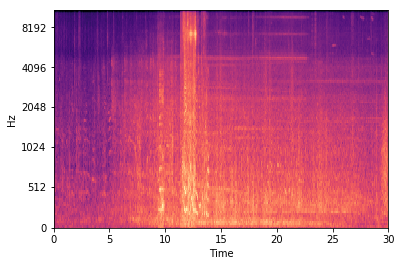

In [2]:
#feature extraction
from librosa import display

def shrinkBgLabels(bg_labels):
    newBg={}
    for bg in bg_labels.keys():
        bgs=''.join(i for i in bg if not i.isdigit())
        if bgs not in newBg:
            newBg[bgs]=len(newBg)
    return newBg

def secsFromFrame(frame):
    fps=float(1292/30)
    return float(frame*fps)    

def createSentenceAsMelSpectrogram(filename):
    #convert all wav files into mel spectrogram features
    y,sr = librosa.load(filename)
    inputfeatureVectorMatrix=librosa.feature.melspectrogram(y=y,sr=sr,power=1) #power=1 is energys
    #keep ground truth labels for all vectors - can get this from filenames for soundscapes - should do a dictionary tbh
    #convert list of lists to 2Dnumpy array 
 #   librosa.display.specshow(inputfeatureVectorMatrix,y_axis='mel', x_axis='time')
    featVecMat=np.array(inputfeatureVectorMatrix)
    print(featVecMat.dtype, featVecMat.shape, np.sum(featVecMat))
    #log of melspec
    featVecMat=np.log(featVecMat) 
    print(featVecMat.dtype, featVecMat.shape, np.sum(featVecMat))
 #   librosa.display.specshow(featVecMat,y_axis='mel', x_axis='time')
    # labels need to be a hot vector. scenes = 1*10, events 1*35. 
    labels=np.zeros((1292,10+n_fg))    
    #only one of first ten should be 1 based on filename
    #have bg_labels from datageneration - this is order of scenes
    for f in range(0,1292):
        lab=filename.split('.')[0].split('_')[0].split('\\')[-1]
        lab=''.join(i for i in lab if not i.isdigit())
        labels[f,noNumBgLabels[lab]]=1
    
    #now need to add one's to label vector for present events
    #open related text(annotation) file
    annotationfile=filename.split('.')[0]+'.txt'
    annotationfile=annotationfile.replace('_upshift','')
    annotationfile=annotationfile.replace('_downshift','')
    with open(annotationfile, "r" ) as ac:
        for line in ac.readlines():
            if line.strip() == '':
                continue
            line=line.strip().split('\t')
            f_pos=secsFromFrame(1)  #getFramePerSecondRate
            onset=int(float(line[0])*f_pos)
            offset=int(float(line[1])*f_pos)    
            labels[onset:offset,fg_labels[line[2]]]=1  # fg label is last column of text file
  #  print(sum(labels[:,10:-1]))
    # need to save labels with feature
    savefilename = filename.split('.')[0]+'_logMelSpec.pckl'
    savefilename = savefilename.replace('syntheticSoundscenes','logMelSpecPckl')
    print(savefilename)
    with open(savefilename, 'wb') as sf:
        pickle.dump((labels,featVecMat), sf, protocol=pickle.HIGHEST_PROTOCOL)

labelDictionary={}
eventlist=[]
scenelist=[]
noNumBgLabels=shrinkBgLabels(bg_labels)
print(noNumBgLabels)
n_fg, fg_labels=foregroundLabels()
print(fg_labels)
#this creates scene files - will slice for events afterwards
src_soundscenes='syntheticSoundscenes\\**\\*.wav'
audiofilelist=glob.glob(src_soundscenes)
#for afile in audiofilelist:
testfile='syntheticSoundscenes\\train\\tubestation10_5.wav'
afile=testfile
print(afile)
scenelist.append(afile.split('.')[0]+'_logMelSpec.pckl')
createSentenceAsMelSpectrogram(afile)
    
        
#print(labelDictionary.keys())

In [33]:
# Get long term statistics of scene information 
#option 1 - aggregate & interpolate


                                                                ## OLD incorrect stuf!!!!

def eachFrameMean(fv,af):
    fv=np.transpose(fv)
    r,c=fv.shape
    aggScene=np.zeros((r,c))
    for i in range(0,c):
        if i+af > c:
            aggScene[:,i]=np.mean(fv[:,i:c],axis=1)
        else:
            aggScene[:,i]=np.mean(fv[:,i:i+af],axis=1)
    return np.transpose(aggScene)

src_soundscenes='logMelSpecPckl\\**\\*_logMelSpec.pckl'
audiofilelist=glob.glob(src_soundscenes)
for scene in audiofilelist:
#testfile='logMelSpecPckl\\train\\bus1_1_logMelSpec.pckl'
#scene=testfile    
#print(scene)
    with open(scene, "rb" ) as scenesample:
        (labels,featVecMat) = pickle.load(scenesample)
     #   print(featVecMat.shape)
        aggregated_scene = eachFrameMean(featVecMat,25)
     #   print(aggregated_scene.shape)
        savefilename = scene.split('_log')[0]+'_aggScenes.pckl'
     #   print(savefilename)
        with open(savefilename, 'wb') as sf:
            pickle.dump((labels, aggregated_scene), sf, protocol=pickle.HIGHEST_PROTOCOL)


In [12]:
# Get long term statistics of scene information 
#option 1 - aggregate & interpolate
import pdb
def eachFrameMean(fv,af):
    fv=np.transpose(fv)
    r,c=fv.shape
    aggScene=np.zeros((r,c))
    for i in range(0,r):
        #print(i)
        #print(i+af)
        if i+af > r:
            
            aggScene[i,:]=np.mean(fv[i:r,:],axis=0)
            #pdb.set_trace()
            
        else:
            aggScene[i,:]=np.mean(fv[i:i+af,:],axis=0)
            
    #pdb.set_trace()      
    return np.transpose(aggScene)

src_soundscenes='logMelSpecPckl\\**\\*_logMelSpec.pckl'
audiofilelist=glob.glob(src_soundscenes)
for scene in audiofilelist:
#testfile='logMelSpecPckl\\train\\bus1_1_logMelSpec.pckl'
#scene=testfile    
#print(scene)
    with open(scene, "rb" ) as scenesample:
        (labels,featVecMat) = pickle.load(scenesample)
        #print(featVecMat.shape)
        aggregated_scene = eachFrameMean(featVecMat,25)
        #print(aggregated_scene.shape)
        savefilename = scene.split('_log')[0]+'_aggScenes.pckl'
        #print(savefilename)
     #
    with open(savefilename, 'wb') as sf:
        pickle.dump((labels, aggregated_scene), sf, protocol=pickle.HIGHEST_PROTOCOL)
#with open(savefilename, "rb" ) as scenesample:
#    (labelsteste,featVecMatteste) = pickle.load(scenesample)
 #   librosa.display.specshow(featVecMatteste,y_axis='mel', x_axis='time')
#    print(featVecMatteste)

In [13]:
#need to normlise the features before performing dimension reduction/transformations. 
#YOGI - MEANS PER TRAINING/VALIDATION FOLD. CUT out test files first
#to match dcase scenes 13 to keep source scenes separate; 
#test files per fold are F1=S1&S6, F2=S2&S7, F3=S3&S8, F4=S4&S9, F5=S5&S10
import string, pickle,glob
import numpy as np
testfolds={}
for i in range(0,5):
    testfolds[i+1]=(i+1,i+6)
print(testfolds)

def splitFileList(filelist,foldIdx):
    trainlist=[]
    testlist=[]
    for file in filelist:
        f=file.strip()
        f=f.replace('logMelSpecPckl\\','')
        f=f.split('_')[0]
        f=''.join(filter(lambda x: x.isdigit(), f))
        if 'test' in file:
            if int(f) in testfolds[foldIdx]: #it should go in test if true
                testlist.append(file)
        else:
            if int(f) not in testfolds[foldIdx]:
                trainlist.append(file)
    print(foldIdx, 'trainfiles: ', str(len(trainlist)))
    print(foldIdx, 'testfiles: ', str(len(testlist)))
    return trainlist,testlist

def processfold(fold,audiofilelist,folder,sore):
    if folder == 'train':
        print('processing fold...'+str(fold))
        first=True
        N=len(audiofilelist)*1292
        for scene in audiofilelist:
            with open(scene, "rb" ) as scenesample:
                (_,featVecMat) = pickle.load(scenesample)
               # print('***')
               # print(np.sum(featVecMat))
                if first:
                    first=False
                    sumssofar=featVecMat
                    sqsofar=np.square(featVecMat)
                else:
                    sumssofar=np.add(sumssofar,featVecMat)
                    sqsofar=np.add(np.square(featVecMat),featVecMat)
        sqsums=np.zeros(128)
        sqmeans=np.zeros(128)
        for i,e in enumerate(sqsofar):
            sqsums[i]=np.sum(e[i])
            sqmeans[i]=np.sum(sumssofar[i,:])
     #   print('**means**')
        freq_means=sqmeans/N
        freq_stds=np.zeros((128))
     #   print('***std*')
        freq_stds=np.sqrt(abs((sqsums/N)-np.square(freq_means)))
        print(freq_stds.shape)
        #=math.sqrt(np.mean(abs(sqsofar-freq_means)**2))
        savefoldstats=folder+'\\'+str(fold)+'\\mean_and_sdev_'+sore+'.pckl'
    #    print(savefoldstats)
        with open(savefoldstats, 'wb') as sf:
            pickle.dump((freq_means,freq_stds), sf, protocol=pickle.HIGHEST_PROTOCOL)
       
    else:
        openfoldstats='train'+'\\'+str(fold)+'\\mean_and_sdev_'+sore+'.pckl'
        with open(openfoldstats, "rb" ) as stats:
            (freq_means,freq_stds) = pickle.load(stats)
    
   # print(freq_means, freq_stds)
    print('Normalizing over time')
    freq_means=np.transpose(np.tile(freq_means,(1292,1)))
    freq_stds=np.transpose(np.tile(freq_stds,(1292,1)))
    print('below shoul be 128,1292')
    print(freq_means.shape)
    for scene in audiofilelist:
        with open(scene, "rb" ) as scenesample:
            (labels,featVecMat) = pickle.load(scenesample)
          #  librosa.display.specshow(featVecMat,y_axis='mel', x_axis='time')
            featVecMat=featVecMat-freq_means
            featVecMat=featVecMat/freq_stds
         #   librosa.display.specshow(featVecMat,y_axis='mel', x_axis='time')
        savefilename = scene.replace('logMelSpecPckl',folder)  #change folder
        savefilename = savefilename.split('\\')
        fname=savefilename[-1]
        fname=fname.split('.')[0]+'_norm.pckl'
        fname=fname.replace('_logMelSpec','_events')
        fname=fname.replace('_aggScenes','_scenes')
        savefilename=savefilename[0]+'\\'+str(fold)+'\\'+fname
        print(savefilename)
        with open(savefilename, 'wb') as sf:
            pickle.dump((labels,featVecMat), sf, protocol=pickle.HIGHEST_PROTOCOL)
    print('NEXT!')
#  on logMelSpec and aggScenes      
for f in range(1,6):
    print(f)
    #normalise scenes by fold
    src_files='logMelSpecPckl\\**\*_aggScenes.pckl'    
    audiofilelist=glob.glob(src_files)
    trainlist,testlist=splitFileList(audiofilelist,f)
    processfold(f,trainlist,'train','agg')  
    processfold(f,testlist,'test','agg')  
    #normalise events by fold
    print('**EVENTS**')
    src_files='logMelSpecPckl\\**\\*_logMelSpec.pckl'
    audiofilelist=glob.glob(src_files)
    trainlist,testlist=splitFileList(audiofilelist,f)
    processfold(f,trainlist,'train','mel')
    processfold(f,testlist,'test','mel')  
    

print('ta da!')

{1: (1, 6), 2: (2, 7), 3: (3, 8), 4: (4, 9), 5: (5, 10)}
1
1 trainfiles:  2400
1 testfiles:  600
processing fold...1
(128,)
Normalizing over time
below shoul be 128,1292
(128, 1292)
train\1\bus10_0_scenes_norm.pckl
train\1\bus10_1_scenes_norm.pckl
train\1\bus10_2_scenes_norm.pckl
train\1\bus10_3_scenes_norm.pckl
train\1\bus10_4_scenes_norm.pckl
train\1\bus10_5_scenes_norm.pckl
train\1\bus10_6_scenes_norm.pckl
train\1\bus10_7_scenes_norm.pckl
train\1\bus10_8_scenes_norm.pckl
train\1\bus10_9_scenes_norm.pckl
train\1\bus10_downshift_0_scenes_norm.pckl
train\1\bus10_downshift_1_scenes_norm.pckl
train\1\bus10_downshift_2_scenes_norm.pckl
train\1\bus10_downshift_3_scenes_norm.pckl
train\1\bus10_downshift_4_scenes_norm.pckl
train\1\bus10_downshift_5_scenes_norm.pckl
train\1\bus10_downshift_6_scenes_norm.pckl
train\1\bus10_downshift_7_scenes_norm.pckl
train\1\bus10_downshift_8_scenes_norm.pckl
train\1\bus10_downshift_9_scenes_norm.pckl
train\1\bus10_upshift_0_scenes_norm.pckl
train\1\bus10_ups

train\1\bus9_6_scenes_norm.pckl
train\1\bus9_7_scenes_norm.pckl
train\1\bus9_8_scenes_norm.pckl
train\1\bus9_9_scenes_norm.pckl
train\1\bus9_downshift_0_scenes_norm.pckl
train\1\bus9_downshift_1_scenes_norm.pckl
train\1\bus9_downshift_2_scenes_norm.pckl
train\1\bus9_downshift_3_scenes_norm.pckl
train\1\bus9_downshift_4_scenes_norm.pckl
train\1\bus9_downshift_5_scenes_norm.pckl
train\1\bus9_downshift_6_scenes_norm.pckl
train\1\bus9_downshift_7_scenes_norm.pckl
train\1\bus9_downshift_8_scenes_norm.pckl
train\1\bus9_downshift_9_scenes_norm.pckl
train\1\bus9_upshift_0_scenes_norm.pckl
train\1\bus9_upshift_1_scenes_norm.pckl
train\1\bus9_upshift_2_scenes_norm.pckl
train\1\bus9_upshift_3_scenes_norm.pckl
train\1\bus9_upshift_4_scenes_norm.pckl
train\1\bus9_upshift_5_scenes_norm.pckl
train\1\bus9_upshift_6_scenes_norm.pckl
train\1\bus9_upshift_7_scenes_norm.pckl
train\1\bus9_upshift_8_scenes_norm.pckl
train\1\bus9_upshift_9_scenes_norm.pckl
train\1\busystreet10_0_scenes_norm.pckl
train\1\busy

train\1\busystreet7_upshift_4_scenes_norm.pckl
train\1\busystreet7_upshift_5_scenes_norm.pckl
train\1\busystreet7_upshift_6_scenes_norm.pckl
train\1\busystreet7_upshift_7_scenes_norm.pckl
train\1\busystreet7_upshift_8_scenes_norm.pckl
train\1\busystreet7_upshift_9_scenes_norm.pckl
train\1\busystreet8_0_scenes_norm.pckl
train\1\busystreet8_1_scenes_norm.pckl
train\1\busystreet8_2_scenes_norm.pckl
train\1\busystreet8_3_scenes_norm.pckl
train\1\busystreet8_4_scenes_norm.pckl
train\1\busystreet8_5_scenes_norm.pckl
train\1\busystreet8_6_scenes_norm.pckl
train\1\busystreet8_7_scenes_norm.pckl
train\1\busystreet8_8_scenes_norm.pckl
train\1\busystreet8_9_scenes_norm.pckl
train\1\busystreet8_downshift_0_scenes_norm.pckl
train\1\busystreet8_downshift_1_scenes_norm.pckl
train\1\busystreet8_downshift_2_scenes_norm.pckl
train\1\busystreet8_downshift_3_scenes_norm.pckl
train\1\busystreet8_downshift_4_scenes_norm.pckl
train\1\busystreet8_downshift_5_scenes_norm.pckl
train\1\busystreet8_downshift_6_sc

train\1\office5_9_scenes_norm.pckl
train\1\office5_downshift_0_scenes_norm.pckl
train\1\office5_downshift_1_scenes_norm.pckl
train\1\office5_downshift_2_scenes_norm.pckl
train\1\office5_downshift_3_scenes_norm.pckl
train\1\office5_downshift_4_scenes_norm.pckl
train\1\office5_downshift_5_scenes_norm.pckl
train\1\office5_downshift_6_scenes_norm.pckl
train\1\office5_downshift_7_scenes_norm.pckl
train\1\office5_downshift_8_scenes_norm.pckl
train\1\office5_downshift_9_scenes_norm.pckl
train\1\office5_upshift_0_scenes_norm.pckl
train\1\office5_upshift_1_scenes_norm.pckl
train\1\office5_upshift_2_scenes_norm.pckl
train\1\office5_upshift_3_scenes_norm.pckl
train\1\office5_upshift_4_scenes_norm.pckl
train\1\office5_upshift_5_scenes_norm.pckl
train\1\office5_upshift_6_scenes_norm.pckl
train\1\office5_upshift_7_scenes_norm.pckl
train\1\office5_upshift_8_scenes_norm.pckl
train\1\office5_upshift_9_scenes_norm.pckl
train\1\office7_0_scenes_norm.pckl
train\1\office7_1_scenes_norm.pckl
train\1\office7

train\1\openairmarket3_downshift_6_scenes_norm.pckl
train\1\openairmarket3_downshift_7_scenes_norm.pckl
train\1\openairmarket3_downshift_8_scenes_norm.pckl
train\1\openairmarket3_downshift_9_scenes_norm.pckl
train\1\openairmarket3_upshift_0_scenes_norm.pckl
train\1\openairmarket3_upshift_1_scenes_norm.pckl
train\1\openairmarket3_upshift_2_scenes_norm.pckl
train\1\openairmarket3_upshift_3_scenes_norm.pckl
train\1\openairmarket3_upshift_4_scenes_norm.pckl
train\1\openairmarket3_upshift_5_scenes_norm.pckl
train\1\openairmarket3_upshift_6_scenes_norm.pckl
train\1\openairmarket3_upshift_7_scenes_norm.pckl
train\1\openairmarket3_upshift_8_scenes_norm.pckl
train\1\openairmarket3_upshift_9_scenes_norm.pckl
train\1\openairmarket4_0_scenes_norm.pckl
train\1\openairmarket4_1_scenes_norm.pckl
train\1\openairmarket4_2_scenes_norm.pckl
train\1\openairmarket4_3_scenes_norm.pckl
train\1\openairmarket4_4_scenes_norm.pckl
train\1\openairmarket4_5_scenes_norm.pckl
train\1\openairmarket4_6_scenes_norm.pck

train\1\park10_downshift_1_scenes_norm.pckl
train\1\park10_downshift_2_scenes_norm.pckl
train\1\park10_downshift_3_scenes_norm.pckl
train\1\park10_downshift_4_scenes_norm.pckl
train\1\park10_downshift_5_scenes_norm.pckl
train\1\park10_downshift_6_scenes_norm.pckl
train\1\park10_downshift_7_scenes_norm.pckl
train\1\park10_downshift_8_scenes_norm.pckl
train\1\park10_downshift_9_scenes_norm.pckl
train\1\park10_upshift_0_scenes_norm.pckl
train\1\park10_upshift_1_scenes_norm.pckl
train\1\park10_upshift_2_scenes_norm.pckl
train\1\park10_upshift_3_scenes_norm.pckl
train\1\park10_upshift_4_scenes_norm.pckl
train\1\park10_upshift_5_scenes_norm.pckl
train\1\park10_upshift_6_scenes_norm.pckl
train\1\park10_upshift_7_scenes_norm.pckl
train\1\park10_upshift_8_scenes_norm.pckl
train\1\park10_upshift_9_scenes_norm.pckl
train\1\park2_0_scenes_norm.pckl
train\1\park2_1_scenes_norm.pckl
train\1\park2_2_scenes_norm.pckl
train\1\park2_3_scenes_norm.pckl
train\1\park2_4_scenes_norm.pckl
train\1\park2_5_sce

train\1\park9_downshift_5_scenes_norm.pckl
train\1\park9_downshift_6_scenes_norm.pckl
train\1\park9_downshift_7_scenes_norm.pckl
train\1\park9_downshift_8_scenes_norm.pckl
train\1\park9_downshift_9_scenes_norm.pckl
train\1\park9_upshift_0_scenes_norm.pckl
train\1\park9_upshift_1_scenes_norm.pckl
train\1\park9_upshift_2_scenes_norm.pckl
train\1\park9_upshift_3_scenes_norm.pckl
train\1\park9_upshift_4_scenes_norm.pckl
train\1\park9_upshift_5_scenes_norm.pckl
train\1\park9_upshift_6_scenes_norm.pckl
train\1\park9_upshift_7_scenes_norm.pckl
train\1\park9_upshift_8_scenes_norm.pckl
train\1\park9_upshift_9_scenes_norm.pckl
train\1\quietstreet10_0_scenes_norm.pckl
train\1\quietstreet10_1_scenes_norm.pckl
train\1\quietstreet10_2_scenes_norm.pckl
train\1\quietstreet10_3_scenes_norm.pckl
train\1\quietstreet10_4_scenes_norm.pckl
train\1\quietstreet10_5_scenes_norm.pckl
train\1\quietstreet10_6_scenes_norm.pckl
train\1\quietstreet10_7_scenes_norm.pckl
train\1\quietstreet10_8_scenes_norm.pckl
train\

train\1\quietstreet7_downshift_6_scenes_norm.pckl
train\1\quietstreet7_downshift_7_scenes_norm.pckl
train\1\quietstreet7_downshift_8_scenes_norm.pckl
train\1\quietstreet7_downshift_9_scenes_norm.pckl
train\1\quietstreet7_upshift_0_scenes_norm.pckl
train\1\quietstreet7_upshift_1_scenes_norm.pckl
train\1\quietstreet7_upshift_2_scenes_norm.pckl
train\1\quietstreet7_upshift_3_scenes_norm.pckl
train\1\quietstreet7_upshift_4_scenes_norm.pckl
train\1\quietstreet7_upshift_5_scenes_norm.pckl
train\1\quietstreet7_upshift_6_scenes_norm.pckl
train\1\quietstreet7_upshift_7_scenes_norm.pckl
train\1\quietstreet7_upshift_8_scenes_norm.pckl
train\1\quietstreet7_upshift_9_scenes_norm.pckl
train\1\quietstreet8_0_scenes_norm.pckl
train\1\quietstreet8_1_scenes_norm.pckl
train\1\quietstreet8_2_scenes_norm.pckl
train\1\quietstreet8_3_scenes_norm.pckl
train\1\quietstreet8_4_scenes_norm.pckl
train\1\quietstreet8_5_scenes_norm.pckl
train\1\quietstreet8_6_scenes_norm.pckl
train\1\quietstreet8_7_scenes_norm.pckl


train\1\restaurant4_downshift_7_scenes_norm.pckl
train\1\restaurant4_downshift_8_scenes_norm.pckl
train\1\restaurant4_downshift_9_scenes_norm.pckl
train\1\restaurant4_upshift_0_scenes_norm.pckl
train\1\restaurant4_upshift_1_scenes_norm.pckl
train\1\restaurant4_upshift_2_scenes_norm.pckl
train\1\restaurant4_upshift_3_scenes_norm.pckl
train\1\restaurant4_upshift_4_scenes_norm.pckl
train\1\restaurant4_upshift_5_scenes_norm.pckl
train\1\restaurant4_upshift_6_scenes_norm.pckl
train\1\restaurant4_upshift_7_scenes_norm.pckl
train\1\restaurant4_upshift_8_scenes_norm.pckl
train\1\restaurant4_upshift_9_scenes_norm.pckl
train\1\restaurant5_0_scenes_norm.pckl
train\1\restaurant5_1_scenes_norm.pckl
train\1\restaurant5_2_scenes_norm.pckl
train\1\restaurant5_3_scenes_norm.pckl
train\1\restaurant5_4_scenes_norm.pckl
train\1\restaurant5_5_scenes_norm.pckl
train\1\restaurant5_6_scenes_norm.pckl
train\1\restaurant5_7_scenes_norm.pckl
train\1\restaurant5_8_scenes_norm.pckl
train\1\restaurant5_9_scenes_nor

train\1\supermarket2_downshift_8_scenes_norm.pckl
train\1\supermarket2_downshift_9_scenes_norm.pckl
train\1\supermarket2_upshift_0_scenes_norm.pckl
train\1\supermarket2_upshift_1_scenes_norm.pckl
train\1\supermarket2_upshift_2_scenes_norm.pckl
train\1\supermarket2_upshift_3_scenes_norm.pckl
train\1\supermarket2_upshift_4_scenes_norm.pckl
train\1\supermarket2_upshift_5_scenes_norm.pckl
train\1\supermarket2_upshift_6_scenes_norm.pckl
train\1\supermarket2_upshift_7_scenes_norm.pckl
train\1\supermarket2_upshift_8_scenes_norm.pckl
train\1\supermarket2_upshift_9_scenes_norm.pckl
train\1\supermarket3_0_scenes_norm.pckl
train\1\supermarket3_1_scenes_norm.pckl
train\1\supermarket3_2_scenes_norm.pckl
train\1\supermarket3_3_scenes_norm.pckl
train\1\supermarket3_4_scenes_norm.pckl
train\1\supermarket3_5_scenes_norm.pckl
train\1\supermarket3_6_scenes_norm.pckl
train\1\supermarket3_7_scenes_norm.pckl
train\1\supermarket3_8_scenes_norm.pckl
train\1\supermarket3_9_scenes_norm.pckl
train\1\supermarket3

train\1\supermarket9_upshift_2_scenes_norm.pckl
train\1\supermarket9_upshift_3_scenes_norm.pckl
train\1\supermarket9_upshift_4_scenes_norm.pckl
train\1\supermarket9_upshift_5_scenes_norm.pckl
train\1\supermarket9_upshift_6_scenes_norm.pckl
train\1\supermarket9_upshift_7_scenes_norm.pckl
train\1\supermarket9_upshift_8_scenes_norm.pckl
train\1\supermarket9_upshift_9_scenes_norm.pckl
train\1\tube10_0_scenes_norm.pckl
train\1\tube10_1_scenes_norm.pckl
train\1\tube10_2_scenes_norm.pckl
train\1\tube10_3_scenes_norm.pckl
train\1\tube10_4_scenes_norm.pckl
train\1\tube10_5_scenes_norm.pckl
train\1\tube10_6_scenes_norm.pckl
train\1\tube10_7_scenes_norm.pckl
train\1\tube10_8_scenes_norm.pckl
train\1\tube10_9_scenes_norm.pckl
train\1\tube10_downshift_0_scenes_norm.pckl
train\1\tube10_downshift_1_scenes_norm.pckl
train\1\tube10_downshift_2_scenes_norm.pckl
train\1\tube10_downshift_3_scenes_norm.pckl
train\1\tube10_downshift_4_scenes_norm.pckl
train\1\tube10_downshift_5_scenes_norm.pckl
train\1\tube

train\1\tube8_upshift_0_scenes_norm.pckl
train\1\tube8_upshift_1_scenes_norm.pckl
train\1\tube8_upshift_2_scenes_norm.pckl
train\1\tube8_upshift_3_scenes_norm.pckl
train\1\tube8_upshift_4_scenes_norm.pckl
train\1\tube8_upshift_5_scenes_norm.pckl
train\1\tube8_upshift_6_scenes_norm.pckl
train\1\tube8_upshift_7_scenes_norm.pckl
train\1\tube8_upshift_8_scenes_norm.pckl
train\1\tube8_upshift_9_scenes_norm.pckl
train\1\tube9_0_scenes_norm.pckl
train\1\tube9_1_scenes_norm.pckl
train\1\tube9_2_scenes_norm.pckl
train\1\tube9_3_scenes_norm.pckl
train\1\tube9_4_scenes_norm.pckl
train\1\tube9_5_scenes_norm.pckl
train\1\tube9_6_scenes_norm.pckl
train\1\tube9_7_scenes_norm.pckl
train\1\tube9_8_scenes_norm.pckl
train\1\tube9_9_scenes_norm.pckl
train\1\tube9_downshift_0_scenes_norm.pckl
train\1\tube9_downshift_1_scenes_norm.pckl
train\1\tube9_downshift_2_scenes_norm.pckl
train\1\tube9_downshift_3_scenes_norm.pckl
train\1\tube9_downshift_4_scenes_norm.pckl
train\1\tube9_downshift_5_scenes_norm.pckl
tr

train\1\tubestation5_upshift_5_scenes_norm.pckl
train\1\tubestation5_upshift_6_scenes_norm.pckl
train\1\tubestation5_upshift_7_scenes_norm.pckl
train\1\tubestation5_upshift_8_scenes_norm.pckl
train\1\tubestation5_upshift_9_scenes_norm.pckl
train\1\tubestation7_0_scenes_norm.pckl
train\1\tubestation7_1_scenes_norm.pckl
train\1\tubestation7_2_scenes_norm.pckl
train\1\tubestation7_3_scenes_norm.pckl
train\1\tubestation7_4_scenes_norm.pckl
train\1\tubestation7_5_scenes_norm.pckl
train\1\tubestation7_6_scenes_norm.pckl
train\1\tubestation7_7_scenes_norm.pckl
train\1\tubestation7_8_scenes_norm.pckl
train\1\tubestation7_9_scenes_norm.pckl
train\1\tubestation7_downshift_0_scenes_norm.pckl
train\1\tubestation7_downshift_1_scenes_norm.pckl
train\1\tubestation7_downshift_2_scenes_norm.pckl
train\1\tubestation7_downshift_3_scenes_norm.pckl
train\1\tubestation7_downshift_4_scenes_norm.pckl
train\1\tubestation7_downshift_5_scenes_norm.pckl
train\1\tubestation7_downshift_6_scenes_norm.pckl
train\1\tu

test\1\busystreet6_downshift_8_scenes_norm.pckl
test\1\busystreet6_downshift_9_scenes_norm.pckl
test\1\busystreet6_upshift_0_scenes_norm.pckl
test\1\busystreet6_upshift_1_scenes_norm.pckl
test\1\busystreet6_upshift_2_scenes_norm.pckl
test\1\busystreet6_upshift_3_scenes_norm.pckl
test\1\busystreet6_upshift_4_scenes_norm.pckl
test\1\busystreet6_upshift_5_scenes_norm.pckl
test\1\busystreet6_upshift_6_scenes_norm.pckl
test\1\busystreet6_upshift_7_scenes_norm.pckl
test\1\busystreet6_upshift_8_scenes_norm.pckl
test\1\busystreet6_upshift_9_scenes_norm.pckl
test\1\office1_0_scenes_norm.pckl
test\1\office1_1_scenes_norm.pckl
test\1\office1_2_scenes_norm.pckl
test\1\office1_3_scenes_norm.pckl
test\1\office1_4_scenes_norm.pckl
test\1\office1_5_scenes_norm.pckl
test\1\office1_6_scenes_norm.pckl
test\1\office1_7_scenes_norm.pckl
test\1\office1_8_scenes_norm.pckl
test\1\office1_9_scenes_norm.pckl
test\1\office1_downshift_0_scenes_norm.pckl
test\1\office1_downshift_1_scenes_norm.pckl
test\1\office1_d

test\1\quietstreet1_4_scenes_norm.pckl
test\1\quietstreet1_5_scenes_norm.pckl
test\1\quietstreet1_6_scenes_norm.pckl
test\1\quietstreet1_7_scenes_norm.pckl
test\1\quietstreet1_8_scenes_norm.pckl
test\1\quietstreet1_9_scenes_norm.pckl
test\1\quietstreet1_downshift_0_scenes_norm.pckl
test\1\quietstreet1_downshift_1_scenes_norm.pckl
test\1\quietstreet1_downshift_2_scenes_norm.pckl
test\1\quietstreet1_downshift_3_scenes_norm.pckl
test\1\quietstreet1_downshift_4_scenes_norm.pckl
test\1\quietstreet1_downshift_5_scenes_norm.pckl
test\1\quietstreet1_downshift_6_scenes_norm.pckl
test\1\quietstreet1_downshift_7_scenes_norm.pckl
test\1\quietstreet1_downshift_8_scenes_norm.pckl
test\1\quietstreet1_downshift_9_scenes_norm.pckl
test\1\quietstreet1_upshift_0_scenes_norm.pckl
test\1\quietstreet1_upshift_1_scenes_norm.pckl
test\1\quietstreet1_upshift_2_scenes_norm.pckl
test\1\quietstreet1_upshift_3_scenes_norm.pckl
test\1\quietstreet1_upshift_4_scenes_norm.pckl
test\1\quietstreet1_upshift_5_scenes_norm

test\1\tube1_downshift_0_scenes_norm.pckl
test\1\tube1_downshift_1_scenes_norm.pckl
test\1\tube1_downshift_2_scenes_norm.pckl
test\1\tube1_downshift_3_scenes_norm.pckl
test\1\tube1_downshift_4_scenes_norm.pckl
test\1\tube1_downshift_5_scenes_norm.pckl
test\1\tube1_downshift_6_scenes_norm.pckl
test\1\tube1_downshift_7_scenes_norm.pckl
test\1\tube1_downshift_8_scenes_norm.pckl
test\1\tube1_downshift_9_scenes_norm.pckl
test\1\tube1_upshift_0_scenes_norm.pckl
test\1\tube1_upshift_1_scenes_norm.pckl
test\1\tube1_upshift_2_scenes_norm.pckl
test\1\tube1_upshift_3_scenes_norm.pckl
test\1\tube1_upshift_4_scenes_norm.pckl
test\1\tube1_upshift_5_scenes_norm.pckl
test\1\tube1_upshift_6_scenes_norm.pckl
test\1\tube1_upshift_7_scenes_norm.pckl
test\1\tube1_upshift_8_scenes_norm.pckl
test\1\tube1_upshift_9_scenes_norm.pckl
test\1\tube6_0_scenes_norm.pckl
test\1\tube6_1_scenes_norm.pckl
test\1\tube6_2_scenes_norm.pckl
test\1\tube6_3_scenes_norm.pckl
test\1\tube6_4_scenes_norm.pckl
test\1\tube6_5_scene

train\1\bus3_upshift_9_events_norm.pckl
train\1\bus4_0_events_norm.pckl
train\1\bus4_1_events_norm.pckl
train\1\bus4_2_events_norm.pckl
train\1\bus4_3_events_norm.pckl
train\1\bus4_4_events_norm.pckl
train\1\bus4_5_events_norm.pckl
train\1\bus4_6_events_norm.pckl
train\1\bus4_7_events_norm.pckl
train\1\bus4_8_events_norm.pckl
train\1\bus4_9_events_norm.pckl
train\1\bus4_downshift_0_events_norm.pckl
train\1\bus4_downshift_1_events_norm.pckl
train\1\bus4_downshift_2_events_norm.pckl
train\1\bus4_downshift_3_events_norm.pckl
train\1\bus4_downshift_4_events_norm.pckl
train\1\bus4_downshift_5_events_norm.pckl
train\1\bus4_downshift_6_events_norm.pckl
train\1\bus4_downshift_7_events_norm.pckl
train\1\bus4_downshift_8_events_norm.pckl
train\1\bus4_downshift_9_events_norm.pckl
train\1\bus4_upshift_0_events_norm.pckl
train\1\bus4_upshift_1_events_norm.pckl
train\1\bus4_upshift_2_events_norm.pckl
train\1\bus4_upshift_3_events_norm.pckl
train\1\bus4_upshift_4_events_norm.pckl
train\1\bus4_upshift

train\1\busystreet2_upshift_6_events_norm.pckl
train\1\busystreet2_upshift_7_events_norm.pckl
train\1\busystreet2_upshift_8_events_norm.pckl
train\1\busystreet2_upshift_9_events_norm.pckl
train\1\busystreet3_0_events_norm.pckl
train\1\busystreet3_1_events_norm.pckl
train\1\busystreet3_2_events_norm.pckl
train\1\busystreet3_3_events_norm.pckl
train\1\busystreet3_4_events_norm.pckl
train\1\busystreet3_5_events_norm.pckl
train\1\busystreet3_6_events_norm.pckl
train\1\busystreet3_7_events_norm.pckl
train\1\busystreet3_8_events_norm.pckl
train\1\busystreet3_9_events_norm.pckl
train\1\busystreet3_downshift_0_events_norm.pckl
train\1\busystreet3_downshift_1_events_norm.pckl
train\1\busystreet3_downshift_2_events_norm.pckl
train\1\busystreet3_downshift_3_events_norm.pckl
train\1\busystreet3_downshift_4_events_norm.pckl
train\1\busystreet3_downshift_5_events_norm.pckl
train\1\busystreet3_downshift_6_events_norm.pckl
train\1\busystreet3_downshift_7_events_norm.pckl
train\1\busystreet3_downshift_

train\1\busystreet9_upshift_8_events_norm.pckl
train\1\busystreet9_upshift_9_events_norm.pckl
train\1\office10_0_events_norm.pckl
train\1\office10_1_events_norm.pckl
train\1\office10_2_events_norm.pckl
train\1\office10_3_events_norm.pckl
train\1\office10_4_events_norm.pckl
train\1\office10_5_events_norm.pckl
train\1\office10_6_events_norm.pckl
train\1\office10_7_events_norm.pckl
train\1\office10_8_events_norm.pckl
train\1\office10_9_events_norm.pckl
train\1\office10_downshift_0_events_norm.pckl
train\1\office10_downshift_1_events_norm.pckl
train\1\office10_downshift_2_events_norm.pckl
train\1\office10_downshift_3_events_norm.pckl
train\1\office10_downshift_4_events_norm.pckl
train\1\office10_downshift_5_events_norm.pckl
train\1\office10_downshift_6_events_norm.pckl
train\1\office10_downshift_7_events_norm.pckl
train\1\office10_downshift_8_events_norm.pckl
train\1\office10_downshift_9_events_norm.pckl
train\1\office10_upshift_0_events_norm.pckl
train\1\office10_upshift_1_events_norm.pck

train\1\office8_upshift_0_events_norm.pckl
train\1\office8_upshift_1_events_norm.pckl
train\1\office8_upshift_2_events_norm.pckl
train\1\office8_upshift_3_events_norm.pckl
train\1\office8_upshift_4_events_norm.pckl
train\1\office8_upshift_5_events_norm.pckl
train\1\office8_upshift_6_events_norm.pckl
train\1\office8_upshift_7_events_norm.pckl
train\1\office8_upshift_8_events_norm.pckl
train\1\office8_upshift_9_events_norm.pckl
train\1\office9_0_events_norm.pckl
train\1\office9_1_events_norm.pckl
train\1\office9_2_events_norm.pckl
train\1\office9_3_events_norm.pckl
train\1\office9_4_events_norm.pckl
train\1\office9_5_events_norm.pckl
train\1\office9_6_events_norm.pckl
train\1\office9_7_events_norm.pckl
train\1\office9_8_events_norm.pckl
train\1\office9_9_events_norm.pckl
train\1\office9_downshift_0_events_norm.pckl
train\1\office9_downshift_1_events_norm.pckl
train\1\office9_downshift_2_events_norm.pckl
train\1\office9_downshift_3_events_norm.pckl
train\1\office9_downshift_4_events_norm.

train\1\openairmarket5_downshift_7_events_norm.pckl
train\1\openairmarket5_downshift_8_events_norm.pckl
train\1\openairmarket5_downshift_9_events_norm.pckl
train\1\openairmarket5_upshift_0_events_norm.pckl
train\1\openairmarket5_upshift_1_events_norm.pckl
train\1\openairmarket5_upshift_2_events_norm.pckl
train\1\openairmarket5_upshift_3_events_norm.pckl
train\1\openairmarket5_upshift_4_events_norm.pckl
train\1\openairmarket5_upshift_5_events_norm.pckl
train\1\openairmarket5_upshift_6_events_norm.pckl
train\1\openairmarket5_upshift_7_events_norm.pckl
train\1\openairmarket5_upshift_8_events_norm.pckl
train\1\openairmarket5_upshift_9_events_norm.pckl
train\1\openairmarket7_0_events_norm.pckl
train\1\openairmarket7_1_events_norm.pckl
train\1\openairmarket7_2_events_norm.pckl
train\1\openairmarket7_3_events_norm.pckl
train\1\openairmarket7_4_events_norm.pckl
train\1\openairmarket7_5_events_norm.pckl
train\1\openairmarket7_6_events_norm.pckl
train\1\openairmarket7_7_events_norm.pckl
train\1\

train\1\park3_upshift_3_events_norm.pckl
train\1\park3_upshift_4_events_norm.pckl
train\1\park3_upshift_5_events_norm.pckl
train\1\park3_upshift_6_events_norm.pckl
train\1\park3_upshift_7_events_norm.pckl
train\1\park3_upshift_8_events_norm.pckl
train\1\park3_upshift_9_events_norm.pckl
train\1\park4_0_events_norm.pckl
train\1\park4_1_events_norm.pckl
train\1\park4_2_events_norm.pckl
train\1\park4_3_events_norm.pckl
train\1\park4_4_events_norm.pckl
train\1\park4_5_events_norm.pckl
train\1\park4_6_events_norm.pckl
train\1\park4_7_events_norm.pckl
train\1\park4_8_events_norm.pckl
train\1\park4_9_events_norm.pckl
train\1\park4_downshift_0_events_norm.pckl
train\1\park4_downshift_1_events_norm.pckl
train\1\park4_downshift_2_events_norm.pckl
train\1\park4_downshift_3_events_norm.pckl
train\1\park4_downshift_4_events_norm.pckl
train\1\park4_downshift_5_events_norm.pckl
train\1\park4_downshift_6_events_norm.pckl
train\1\park4_downshift_7_events_norm.pckl
train\1\park4_downshift_8_events_norm.p

train\1\quietstreet2_downshift_8_events_norm.pckl
train\1\quietstreet2_downshift_9_events_norm.pckl
train\1\quietstreet2_upshift_0_events_norm.pckl
train\1\quietstreet2_upshift_1_events_norm.pckl
train\1\quietstreet2_upshift_2_events_norm.pckl
train\1\quietstreet2_upshift_3_events_norm.pckl
train\1\quietstreet2_upshift_4_events_norm.pckl
train\1\quietstreet2_upshift_5_events_norm.pckl
train\1\quietstreet2_upshift_6_events_norm.pckl
train\1\quietstreet2_upshift_7_events_norm.pckl
train\1\quietstreet2_upshift_8_events_norm.pckl
train\1\quietstreet2_upshift_9_events_norm.pckl
train\1\quietstreet3_0_events_norm.pckl
train\1\quietstreet3_1_events_norm.pckl
train\1\quietstreet3_2_events_norm.pckl
train\1\quietstreet3_3_events_norm.pckl
train\1\quietstreet3_4_events_norm.pckl
train\1\quietstreet3_5_events_norm.pckl
train\1\quietstreet3_6_events_norm.pckl
train\1\quietstreet3_7_events_norm.pckl
train\1\quietstreet3_8_events_norm.pckl
train\1\quietstreet3_9_events_norm.pckl
train\1\quietstreet3

train\1\quietstreet9_downshift_7_events_norm.pckl
train\1\quietstreet9_downshift_8_events_norm.pckl
train\1\quietstreet9_downshift_9_events_norm.pckl
train\1\quietstreet9_upshift_0_events_norm.pckl
train\1\quietstreet9_upshift_1_events_norm.pckl
train\1\quietstreet9_upshift_2_events_norm.pckl
train\1\quietstreet9_upshift_3_events_norm.pckl
train\1\quietstreet9_upshift_4_events_norm.pckl
train\1\quietstreet9_upshift_5_events_norm.pckl
train\1\quietstreet9_upshift_6_events_norm.pckl
train\1\quietstreet9_upshift_7_events_norm.pckl
train\1\quietstreet9_upshift_8_events_norm.pckl
train\1\quietstreet9_upshift_9_events_norm.pckl
train\1\restaurant10_0_events_norm.pckl
train\1\restaurant10_1_events_norm.pckl
train\1\restaurant10_2_events_norm.pckl
train\1\restaurant10_3_events_norm.pckl
train\1\restaurant10_4_events_norm.pckl
train\1\restaurant10_5_events_norm.pckl
train\1\restaurant10_6_events_norm.pckl
train\1\restaurant10_7_events_norm.pckl
train\1\restaurant10_8_events_norm.pckl
train\1\re

train\1\restaurant7_upshift_4_events_norm.pckl
train\1\restaurant7_upshift_5_events_norm.pckl
train\1\restaurant7_upshift_6_events_norm.pckl
train\1\restaurant7_upshift_7_events_norm.pckl
train\1\restaurant7_upshift_8_events_norm.pckl
train\1\restaurant7_upshift_9_events_norm.pckl
train\1\restaurant8_0_events_norm.pckl
train\1\restaurant8_1_events_norm.pckl
train\1\restaurant8_2_events_norm.pckl
train\1\restaurant8_3_events_norm.pckl
train\1\restaurant8_4_events_norm.pckl
train\1\restaurant8_5_events_norm.pckl
train\1\restaurant8_6_events_norm.pckl
train\1\restaurant8_7_events_norm.pckl
train\1\restaurant8_8_events_norm.pckl
train\1\restaurant8_9_events_norm.pckl
train\1\restaurant8_downshift_0_events_norm.pckl
train\1\restaurant8_downshift_1_events_norm.pckl
train\1\restaurant8_downshift_2_events_norm.pckl
train\1\restaurant8_downshift_3_events_norm.pckl
train\1\restaurant8_downshift_4_events_norm.pckl
train\1\restaurant8_downshift_5_events_norm.pckl
train\1\restaurant8_downshift_6_ev

train\1\supermarket4_upshift_4_events_norm.pckl
train\1\supermarket4_upshift_5_events_norm.pckl
train\1\supermarket4_upshift_6_events_norm.pckl
train\1\supermarket4_upshift_7_events_norm.pckl
train\1\supermarket4_upshift_8_events_norm.pckl
train\1\supermarket4_upshift_9_events_norm.pckl
train\1\supermarket5_0_events_norm.pckl
train\1\supermarket5_1_events_norm.pckl
train\1\supermarket5_2_events_norm.pckl
train\1\supermarket5_3_events_norm.pckl
train\1\supermarket5_4_events_norm.pckl
train\1\supermarket5_5_events_norm.pckl
train\1\supermarket5_6_events_norm.pckl
train\1\supermarket5_7_events_norm.pckl
train\1\supermarket5_8_events_norm.pckl
train\1\supermarket5_9_events_norm.pckl
train\1\supermarket5_downshift_0_events_norm.pckl
train\1\supermarket5_downshift_1_events_norm.pckl
train\1\supermarket5_downshift_2_events_norm.pckl
train\1\supermarket5_downshift_3_events_norm.pckl
train\1\supermarket5_downshift_4_events_norm.pckl
train\1\supermarket5_downshift_5_events_norm.pckl
train\1\supe

train\1\tube3_4_events_norm.pckl
train\1\tube3_5_events_norm.pckl
train\1\tube3_6_events_norm.pckl
train\1\tube3_7_events_norm.pckl
train\1\tube3_8_events_norm.pckl
train\1\tube3_9_events_norm.pckl
train\1\tube3_downshift_0_events_norm.pckl
train\1\tube3_downshift_1_events_norm.pckl
train\1\tube3_downshift_2_events_norm.pckl
train\1\tube3_downshift_3_events_norm.pckl
train\1\tube3_downshift_4_events_norm.pckl
train\1\tube3_downshift_5_events_norm.pckl
train\1\tube3_downshift_6_events_norm.pckl
train\1\tube3_downshift_7_events_norm.pckl
train\1\tube3_downshift_8_events_norm.pckl
train\1\tube3_downshift_9_events_norm.pckl
train\1\tube3_upshift_0_events_norm.pckl
train\1\tube3_upshift_1_events_norm.pckl
train\1\tube3_upshift_2_events_norm.pckl
train\1\tube3_upshift_3_events_norm.pckl
train\1\tube3_upshift_4_events_norm.pckl
train\1\tube3_upshift_5_events_norm.pckl
train\1\tube3_upshift_6_events_norm.pckl
train\1\tube3_upshift_7_events_norm.pckl
train\1\tube3_upshift_8_events_norm.pckl
tra

train\1\tubestation2_0_events_norm.pckl
train\1\tubestation2_1_events_norm.pckl
train\1\tubestation2_2_events_norm.pckl
train\1\tubestation2_3_events_norm.pckl
train\1\tubestation2_4_events_norm.pckl
train\1\tubestation2_5_events_norm.pckl
train\1\tubestation2_6_events_norm.pckl
train\1\tubestation2_7_events_norm.pckl
train\1\tubestation2_8_events_norm.pckl
train\1\tubestation2_9_events_norm.pckl
train\1\tubestation2_downshift_0_events_norm.pckl
train\1\tubestation2_downshift_1_events_norm.pckl
train\1\tubestation2_downshift_2_events_norm.pckl
train\1\tubestation2_downshift_3_events_norm.pckl
train\1\tubestation2_downshift_4_events_norm.pckl
train\1\tubestation2_downshift_5_events_norm.pckl
train\1\tubestation2_downshift_6_events_norm.pckl
train\1\tubestation2_downshift_7_events_norm.pckl
train\1\tubestation2_downshift_8_events_norm.pckl
train\1\tubestation2_downshift_9_events_norm.pckl
train\1\tubestation2_upshift_0_events_norm.pckl
train\1\tubestation2_upshift_1_events_norm.pckl
trai

train\1\tubestation9_0_events_norm.pckl
train\1\tubestation9_1_events_norm.pckl
train\1\tubestation9_2_events_norm.pckl
train\1\tubestation9_3_events_norm.pckl
train\1\tubestation9_4_events_norm.pckl
train\1\tubestation9_5_events_norm.pckl
train\1\tubestation9_6_events_norm.pckl
train\1\tubestation9_7_events_norm.pckl
train\1\tubestation9_8_events_norm.pckl
train\1\tubestation9_9_events_norm.pckl
train\1\tubestation9_downshift_0_events_norm.pckl
train\1\tubestation9_downshift_1_events_norm.pckl
train\1\tubestation9_downshift_2_events_norm.pckl
train\1\tubestation9_downshift_3_events_norm.pckl
train\1\tubestation9_downshift_4_events_norm.pckl
train\1\tubestation9_downshift_5_events_norm.pckl
train\1\tubestation9_downshift_6_events_norm.pckl
train\1\tubestation9_downshift_7_events_norm.pckl
train\1\tubestation9_downshift_8_events_norm.pckl
train\1\tubestation9_downshift_9_events_norm.pckl
train\1\tubestation9_upshift_0_events_norm.pckl
train\1\tubestation9_upshift_1_events_norm.pckl
trai

test\1\office6_upshift_6_events_norm.pckl
test\1\office6_upshift_7_events_norm.pckl
test\1\office6_upshift_8_events_norm.pckl
test\1\office6_upshift_9_events_norm.pckl
test\1\openairmarket1_0_events_norm.pckl
test\1\openairmarket1_1_events_norm.pckl
test\1\openairmarket1_2_events_norm.pckl
test\1\openairmarket1_3_events_norm.pckl
test\1\openairmarket1_4_events_norm.pckl
test\1\openairmarket1_5_events_norm.pckl
test\1\openairmarket1_6_events_norm.pckl
test\1\openairmarket1_7_events_norm.pckl
test\1\openairmarket1_8_events_norm.pckl
test\1\openairmarket1_9_events_norm.pckl
test\1\openairmarket1_downshift_0_events_norm.pckl
test\1\openairmarket1_downshift_1_events_norm.pckl
test\1\openairmarket1_downshift_2_events_norm.pckl
test\1\openairmarket1_downshift_3_events_norm.pckl
test\1\openairmarket1_downshift_4_events_norm.pckl
test\1\openairmarket1_downshift_5_events_norm.pckl
test\1\openairmarket1_downshift_6_events_norm.pckl
test\1\openairmarket1_downshift_7_events_norm.pckl
test\1\openair

test\1\restaurant1_downshift_8_events_norm.pckl
test\1\restaurant1_downshift_9_events_norm.pckl
test\1\restaurant1_upshift_0_events_norm.pckl
test\1\restaurant1_upshift_1_events_norm.pckl
test\1\restaurant1_upshift_2_events_norm.pckl
test\1\restaurant1_upshift_3_events_norm.pckl
test\1\restaurant1_upshift_4_events_norm.pckl
test\1\restaurant1_upshift_5_events_norm.pckl
test\1\restaurant1_upshift_6_events_norm.pckl
test\1\restaurant1_upshift_7_events_norm.pckl
test\1\restaurant1_upshift_8_events_norm.pckl
test\1\restaurant1_upshift_9_events_norm.pckl
test\1\restaurant6_0_events_norm.pckl
test\1\restaurant6_1_events_norm.pckl
test\1\restaurant6_2_events_norm.pckl
test\1\restaurant6_3_events_norm.pckl
test\1\restaurant6_4_events_norm.pckl
test\1\restaurant6_5_events_norm.pckl
test\1\restaurant6_6_events_norm.pckl
test\1\restaurant6_7_events_norm.pckl
test\1\restaurant6_8_events_norm.pckl
test\1\restaurant6_9_events_norm.pckl
test\1\restaurant6_downshift_0_events_norm.pckl
test\1\restauran

test\1\tubestation6_9_events_norm.pckl
test\1\tubestation6_downshift_0_events_norm.pckl
test\1\tubestation6_downshift_1_events_norm.pckl
test\1\tubestation6_downshift_2_events_norm.pckl
test\1\tubestation6_downshift_3_events_norm.pckl
test\1\tubestation6_downshift_4_events_norm.pckl
test\1\tubestation6_downshift_5_events_norm.pckl
test\1\tubestation6_downshift_6_events_norm.pckl
test\1\tubestation6_downshift_7_events_norm.pckl
test\1\tubestation6_downshift_8_events_norm.pckl
test\1\tubestation6_downshift_9_events_norm.pckl
test\1\tubestation6_upshift_0_events_norm.pckl
test\1\tubestation6_upshift_1_events_norm.pckl
test\1\tubestation6_upshift_2_events_norm.pckl
test\1\tubestation6_upshift_3_events_norm.pckl
test\1\tubestation6_upshift_4_events_norm.pckl
test\1\tubestation6_upshift_5_events_norm.pckl
test\1\tubestation6_upshift_6_events_norm.pckl
test\1\tubestation6_upshift_7_events_norm.pckl
test\1\tubestation6_upshift_8_events_norm.pckl
test\1\tubestation6_upshift_9_events_norm.pckl
N

train\2\bus8_8_scenes_norm.pckl
train\2\bus8_9_scenes_norm.pckl
train\2\bus8_downshift_0_scenes_norm.pckl
train\2\bus8_downshift_1_scenes_norm.pckl
train\2\bus8_downshift_2_scenes_norm.pckl
train\2\bus8_downshift_3_scenes_norm.pckl
train\2\bus8_downshift_4_scenes_norm.pckl
train\2\bus8_downshift_5_scenes_norm.pckl
train\2\bus8_downshift_6_scenes_norm.pckl
train\2\bus8_downshift_7_scenes_norm.pckl
train\2\bus8_downshift_8_scenes_norm.pckl
train\2\bus8_downshift_9_scenes_norm.pckl
train\2\bus8_upshift_0_scenes_norm.pckl
train\2\bus8_upshift_1_scenes_norm.pckl
train\2\bus8_upshift_2_scenes_norm.pckl
train\2\bus8_upshift_3_scenes_norm.pckl
train\2\bus8_upshift_4_scenes_norm.pckl
train\2\bus8_upshift_5_scenes_norm.pckl
train\2\bus8_upshift_6_scenes_norm.pckl
train\2\bus8_upshift_7_scenes_norm.pckl
train\2\bus8_upshift_8_scenes_norm.pckl
train\2\bus8_upshift_9_scenes_norm.pckl
train\2\bus9_0_scenes_norm.pckl
train\2\bus9_1_scenes_norm.pckl
train\2\bus9_2_scenes_norm.pckl
train\2\bus9_3_scene

train\2\busystreet5_downshift_9_scenes_norm.pckl
train\2\busystreet5_upshift_0_scenes_norm.pckl
train\2\busystreet5_upshift_1_scenes_norm.pckl
train\2\busystreet5_upshift_2_scenes_norm.pckl
train\2\busystreet5_upshift_3_scenes_norm.pckl
train\2\busystreet5_upshift_4_scenes_norm.pckl
train\2\busystreet5_upshift_5_scenes_norm.pckl
train\2\busystreet5_upshift_6_scenes_norm.pckl
train\2\busystreet5_upshift_7_scenes_norm.pckl
train\2\busystreet5_upshift_8_scenes_norm.pckl
train\2\busystreet5_upshift_9_scenes_norm.pckl
train\2\busystreet6_0_scenes_norm.pckl
train\2\busystreet6_1_scenes_norm.pckl
train\2\busystreet6_2_scenes_norm.pckl
train\2\busystreet6_3_scenes_norm.pckl
train\2\busystreet6_4_scenes_norm.pckl
train\2\busystreet6_5_scenes_norm.pckl
train\2\busystreet6_6_scenes_norm.pckl
train\2\busystreet6_7_scenes_norm.pckl
train\2\busystreet6_8_scenes_norm.pckl
train\2\busystreet6_9_scenes_norm.pckl
train\2\busystreet6_downshift_0_scenes_norm.pckl
train\2\busystreet6_downshift_1_scenes_nor

train\2\office3_upshift_9_scenes_norm.pckl
train\2\office4_0_scenes_norm.pckl
train\2\office4_1_scenes_norm.pckl
train\2\office4_2_scenes_norm.pckl
train\2\office4_3_scenes_norm.pckl
train\2\office4_4_scenes_norm.pckl
train\2\office4_5_scenes_norm.pckl
train\2\office4_6_scenes_norm.pckl
train\2\office4_7_scenes_norm.pckl
train\2\office4_8_scenes_norm.pckl
train\2\office4_9_scenes_norm.pckl
train\2\office4_downshift_0_scenes_norm.pckl
train\2\office4_downshift_1_scenes_norm.pckl
train\2\office4_downshift_2_scenes_norm.pckl
train\2\office4_downshift_3_scenes_norm.pckl
train\2\office4_downshift_4_scenes_norm.pckl
train\2\office4_downshift_5_scenes_norm.pckl
train\2\office4_downshift_6_scenes_norm.pckl
train\2\office4_downshift_7_scenes_norm.pckl
train\2\office4_downshift_8_scenes_norm.pckl
train\2\office4_downshift_9_scenes_norm.pckl
train\2\office4_upshift_0_scenes_norm.pckl
train\2\office4_upshift_1_scenes_norm.pckl
train\2\office4_upshift_2_scenes_norm.pckl
train\2\office4_upshift_3_sc

train\2\openairmarket1_downshift_7_scenes_norm.pckl
train\2\openairmarket1_downshift_8_scenes_norm.pckl
train\2\openairmarket1_downshift_9_scenes_norm.pckl
train\2\openairmarket1_upshift_0_scenes_norm.pckl
train\2\openairmarket1_upshift_1_scenes_norm.pckl
train\2\openairmarket1_upshift_2_scenes_norm.pckl
train\2\openairmarket1_upshift_3_scenes_norm.pckl
train\2\openairmarket1_upshift_4_scenes_norm.pckl
train\2\openairmarket1_upshift_5_scenes_norm.pckl
train\2\openairmarket1_upshift_6_scenes_norm.pckl
train\2\openairmarket1_upshift_7_scenes_norm.pckl
train\2\openairmarket1_upshift_8_scenes_norm.pckl
train\2\openairmarket1_upshift_9_scenes_norm.pckl
train\2\openairmarket3_0_scenes_norm.pckl
train\2\openairmarket3_1_scenes_norm.pckl
train\2\openairmarket3_2_scenes_norm.pckl
train\2\openairmarket3_3_scenes_norm.pckl
train\2\openairmarket3_4_scenes_norm.pckl
train\2\openairmarket3_5_scenes_norm.pckl
train\2\openairmarket3_6_scenes_norm.pckl
train\2\openairmarket3_7_scenes_norm.pckl
train\2\

train\2\openairmarket9_downshift_2_scenes_norm.pckl
train\2\openairmarket9_downshift_3_scenes_norm.pckl
train\2\openairmarket9_downshift_4_scenes_norm.pckl
train\2\openairmarket9_downshift_5_scenes_norm.pckl
train\2\openairmarket9_downshift_6_scenes_norm.pckl
train\2\openairmarket9_downshift_7_scenes_norm.pckl
train\2\openairmarket9_downshift_8_scenes_norm.pckl
train\2\openairmarket9_downshift_9_scenes_norm.pckl
train\2\openairmarket9_upshift_0_scenes_norm.pckl
train\2\openairmarket9_upshift_1_scenes_norm.pckl
train\2\openairmarket9_upshift_2_scenes_norm.pckl
train\2\openairmarket9_upshift_3_scenes_norm.pckl
train\2\openairmarket9_upshift_4_scenes_norm.pckl
train\2\openairmarket9_upshift_5_scenes_norm.pckl
train\2\openairmarket9_upshift_6_scenes_norm.pckl
train\2\openairmarket9_upshift_7_scenes_norm.pckl
train\2\openairmarket9_upshift_8_scenes_norm.pckl
train\2\openairmarket9_upshift_9_scenes_norm.pckl
train\2\park10_0_scenes_norm.pckl
train\2\park10_1_scenes_norm.pckl
train\2\park10_2

train\2\park8_8_scenes_norm.pckl
train\2\park8_9_scenes_norm.pckl
train\2\park8_downshift_0_scenes_norm.pckl
train\2\park8_downshift_1_scenes_norm.pckl
train\2\park8_downshift_2_scenes_norm.pckl
train\2\park8_downshift_3_scenes_norm.pckl
train\2\park8_downshift_4_scenes_norm.pckl
train\2\park8_downshift_5_scenes_norm.pckl
train\2\park8_downshift_6_scenes_norm.pckl
train\2\park8_downshift_7_scenes_norm.pckl
train\2\park8_downshift_8_scenes_norm.pckl
train\2\park8_downshift_9_scenes_norm.pckl
train\2\park8_upshift_0_scenes_norm.pckl
train\2\park8_upshift_1_scenes_norm.pckl
train\2\park8_upshift_2_scenes_norm.pckl
train\2\park8_upshift_3_scenes_norm.pckl
train\2\park8_upshift_4_scenes_norm.pckl
train\2\park8_upshift_5_scenes_norm.pckl
train\2\park8_upshift_6_scenes_norm.pckl
train\2\park8_upshift_7_scenes_norm.pckl
train\2\park8_upshift_8_scenes_norm.pckl
train\2\park8_upshift_9_scenes_norm.pckl
train\2\park9_0_scenes_norm.pckl
train\2\park9_1_scenes_norm.pckl
train\2\park9_2_scenes_norm.

train\2\quietstreet5_downshift_4_scenes_norm.pckl
train\2\quietstreet5_downshift_5_scenes_norm.pckl
train\2\quietstreet5_downshift_6_scenes_norm.pckl
train\2\quietstreet5_downshift_7_scenes_norm.pckl
train\2\quietstreet5_downshift_8_scenes_norm.pckl
train\2\quietstreet5_downshift_9_scenes_norm.pckl
train\2\quietstreet5_upshift_0_scenes_norm.pckl
train\2\quietstreet5_upshift_1_scenes_norm.pckl
train\2\quietstreet5_upshift_2_scenes_norm.pckl
train\2\quietstreet5_upshift_3_scenes_norm.pckl
train\2\quietstreet5_upshift_4_scenes_norm.pckl
train\2\quietstreet5_upshift_5_scenes_norm.pckl
train\2\quietstreet5_upshift_6_scenes_norm.pckl
train\2\quietstreet5_upshift_7_scenes_norm.pckl
train\2\quietstreet5_upshift_8_scenes_norm.pckl
train\2\quietstreet5_upshift_9_scenes_norm.pckl
train\2\quietstreet6_0_scenes_norm.pckl
train\2\quietstreet6_1_scenes_norm.pckl
train\2\quietstreet6_2_scenes_norm.pckl
train\2\quietstreet6_3_scenes_norm.pckl
train\2\quietstreet6_4_scenes_norm.pckl
train\2\quietstreet6

train\2\restaurant3_downshift_9_scenes_norm.pckl
train\2\restaurant3_upshift_0_scenes_norm.pckl
train\2\restaurant3_upshift_1_scenes_norm.pckl
train\2\restaurant3_upshift_2_scenes_norm.pckl
train\2\restaurant3_upshift_3_scenes_norm.pckl
train\2\restaurant3_upshift_4_scenes_norm.pckl
train\2\restaurant3_upshift_5_scenes_norm.pckl
train\2\restaurant3_upshift_6_scenes_norm.pckl
train\2\restaurant3_upshift_7_scenes_norm.pckl
train\2\restaurant3_upshift_8_scenes_norm.pckl
train\2\restaurant3_upshift_9_scenes_norm.pckl
train\2\restaurant4_0_scenes_norm.pckl
train\2\restaurant4_1_scenes_norm.pckl
train\2\restaurant4_2_scenes_norm.pckl
train\2\restaurant4_3_scenes_norm.pckl
train\2\restaurant4_4_scenes_norm.pckl
train\2\restaurant4_5_scenes_norm.pckl
train\2\restaurant4_6_scenes_norm.pckl
train\2\restaurant4_7_scenes_norm.pckl
train\2\restaurant4_8_scenes_norm.pckl
train\2\restaurant4_9_scenes_norm.pckl
train\2\restaurant4_downshift_0_scenes_norm.pckl
train\2\restaurant4_downshift_1_scenes_nor

train\2\supermarket10_upshift_1_scenes_norm.pckl
train\2\supermarket10_upshift_2_scenes_norm.pckl
train\2\supermarket10_upshift_3_scenes_norm.pckl
train\2\supermarket10_upshift_4_scenes_norm.pckl
train\2\supermarket10_upshift_5_scenes_norm.pckl
train\2\supermarket10_upshift_6_scenes_norm.pckl
train\2\supermarket10_upshift_7_scenes_norm.pckl
train\2\supermarket10_upshift_8_scenes_norm.pckl
train\2\supermarket10_upshift_9_scenes_norm.pckl
train\2\supermarket1_0_scenes_norm.pckl
train\2\supermarket1_1_scenes_norm.pckl
train\2\supermarket1_2_scenes_norm.pckl
train\2\supermarket1_3_scenes_norm.pckl
train\2\supermarket1_4_scenes_norm.pckl
train\2\supermarket1_5_scenes_norm.pckl
train\2\supermarket1_6_scenes_norm.pckl
train\2\supermarket1_7_scenes_norm.pckl
train\2\supermarket1_8_scenes_norm.pckl
train\2\supermarket1_9_scenes_norm.pckl
train\2\supermarket1_downshift_0_scenes_norm.pckl
train\2\supermarket1_downshift_1_scenes_norm.pckl
train\2\supermarket1_downshift_2_scenes_norm.pckl
train\2\s

train\2\supermarket8_upshift_0_scenes_norm.pckl
train\2\supermarket8_upshift_1_scenes_norm.pckl
train\2\supermarket8_upshift_2_scenes_norm.pckl
train\2\supermarket8_upshift_3_scenes_norm.pckl
train\2\supermarket8_upshift_4_scenes_norm.pckl
train\2\supermarket8_upshift_5_scenes_norm.pckl
train\2\supermarket8_upshift_6_scenes_norm.pckl
train\2\supermarket8_upshift_7_scenes_norm.pckl
train\2\supermarket8_upshift_8_scenes_norm.pckl
train\2\supermarket8_upshift_9_scenes_norm.pckl
train\2\supermarket9_0_scenes_norm.pckl
train\2\supermarket9_1_scenes_norm.pckl
train\2\supermarket9_2_scenes_norm.pckl
train\2\supermarket9_3_scenes_norm.pckl
train\2\supermarket9_4_scenes_norm.pckl
train\2\supermarket9_5_scenes_norm.pckl
train\2\supermarket9_6_scenes_norm.pckl
train\2\supermarket9_7_scenes_norm.pckl
train\2\supermarket9_8_scenes_norm.pckl
train\2\supermarket9_9_scenes_norm.pckl
train\2\supermarket9_downshift_0_scenes_norm.pckl
train\2\supermarket9_downshift_1_scenes_norm.pckl
train\2\supermarket9

train\2\tube6_downshift_3_scenes_norm.pckl
train\2\tube6_downshift_4_scenes_norm.pckl
train\2\tube6_downshift_5_scenes_norm.pckl
train\2\tube6_downshift_6_scenes_norm.pckl
train\2\tube6_downshift_7_scenes_norm.pckl
train\2\tube6_downshift_8_scenes_norm.pckl
train\2\tube6_downshift_9_scenes_norm.pckl
train\2\tube6_upshift_0_scenes_norm.pckl
train\2\tube6_upshift_1_scenes_norm.pckl
train\2\tube6_upshift_2_scenes_norm.pckl
train\2\tube6_upshift_3_scenes_norm.pckl
train\2\tube6_upshift_4_scenes_norm.pckl
train\2\tube6_upshift_5_scenes_norm.pckl
train\2\tube6_upshift_6_scenes_norm.pckl
train\2\tube6_upshift_7_scenes_norm.pckl
train\2\tube6_upshift_8_scenes_norm.pckl
train\2\tube6_upshift_9_scenes_norm.pckl
train\2\tube8_0_scenes_norm.pckl
train\2\tube8_1_scenes_norm.pckl
train\2\tube8_2_scenes_norm.pckl
train\2\tube8_3_scenes_norm.pckl
train\2\tube8_4_scenes_norm.pckl
train\2\tube8_5_scenes_norm.pckl
train\2\tube8_6_scenes_norm.pckl
train\2\tube8_7_scenes_norm.pckl
train\2\tube8_8_scenes_no

train\2\tubestation4_upshift_8_scenes_norm.pckl
train\2\tubestation4_upshift_9_scenes_norm.pckl
train\2\tubestation5_0_scenes_norm.pckl
train\2\tubestation5_1_scenes_norm.pckl
train\2\tubestation5_2_scenes_norm.pckl
train\2\tubestation5_3_scenes_norm.pckl
train\2\tubestation5_4_scenes_norm.pckl
train\2\tubestation5_5_scenes_norm.pckl
train\2\tubestation5_6_scenes_norm.pckl
train\2\tubestation5_7_scenes_norm.pckl
train\2\tubestation5_8_scenes_norm.pckl
train\2\tubestation5_9_scenes_norm.pckl
train\2\tubestation5_downshift_0_scenes_norm.pckl
train\2\tubestation5_downshift_1_scenes_norm.pckl
train\2\tubestation5_downshift_2_scenes_norm.pckl
train\2\tubestation5_downshift_3_scenes_norm.pckl
train\2\tubestation5_downshift_4_scenes_norm.pckl
train\2\tubestation5_downshift_5_scenes_norm.pckl
train\2\tubestation5_downshift_6_scenes_norm.pckl
train\2\tubestation5_downshift_7_scenes_norm.pckl
train\2\tubestation5_downshift_8_scenes_norm.pckl
train\2\tubestation5_downshift_9_scenes_norm.pckl
trai

test\2\busystreet2_downshift_0_scenes_norm.pckl
test\2\busystreet2_downshift_1_scenes_norm.pckl
test\2\busystreet2_downshift_2_scenes_norm.pckl
test\2\busystreet2_downshift_3_scenes_norm.pckl
test\2\busystreet2_downshift_4_scenes_norm.pckl
test\2\busystreet2_downshift_5_scenes_norm.pckl
test\2\busystreet2_downshift_6_scenes_norm.pckl
test\2\busystreet2_downshift_7_scenes_norm.pckl
test\2\busystreet2_downshift_8_scenes_norm.pckl
test\2\busystreet2_downshift_9_scenes_norm.pckl
test\2\busystreet2_upshift_0_scenes_norm.pckl
test\2\busystreet2_upshift_1_scenes_norm.pckl
test\2\busystreet2_upshift_2_scenes_norm.pckl
test\2\busystreet2_upshift_3_scenes_norm.pckl
test\2\busystreet2_upshift_4_scenes_norm.pckl
test\2\busystreet2_upshift_5_scenes_norm.pckl
test\2\busystreet2_upshift_6_scenes_norm.pckl
test\2\busystreet2_upshift_7_scenes_norm.pckl
test\2\busystreet2_upshift_8_scenes_norm.pckl
test\2\busystreet2_upshift_9_scenes_norm.pckl
test\2\busystreet7_0_scenes_norm.pckl
test\2\busystreet7_1_s

test\2\park2_upshift_0_scenes_norm.pckl
test\2\park2_upshift_1_scenes_norm.pckl
test\2\park2_upshift_2_scenes_norm.pckl
test\2\park2_upshift_3_scenes_norm.pckl
test\2\park2_upshift_4_scenes_norm.pckl
test\2\park2_upshift_5_scenes_norm.pckl
test\2\park2_upshift_6_scenes_norm.pckl
test\2\park2_upshift_7_scenes_norm.pckl
test\2\park2_upshift_8_scenes_norm.pckl
test\2\park2_upshift_9_scenes_norm.pckl
test\2\park7_0_scenes_norm.pckl
test\2\park7_1_scenes_norm.pckl
test\2\park7_2_scenes_norm.pckl
test\2\park7_3_scenes_norm.pckl
test\2\park7_4_scenes_norm.pckl
test\2\park7_5_scenes_norm.pckl
test\2\park7_6_scenes_norm.pckl
test\2\park7_7_scenes_norm.pckl
test\2\park7_8_scenes_norm.pckl
test\2\park7_9_scenes_norm.pckl
test\2\park7_downshift_0_scenes_norm.pckl
test\2\park7_downshift_1_scenes_norm.pckl
test\2\park7_downshift_2_scenes_norm.pckl
test\2\park7_downshift_3_scenes_norm.pckl
test\2\park7_downshift_4_scenes_norm.pckl
test\2\park7_downshift_5_scenes_norm.pckl
test\2\park7_downshift_6_sce

test\2\supermarket7_0_scenes_norm.pckl
test\2\supermarket7_1_scenes_norm.pckl
test\2\supermarket7_2_scenes_norm.pckl
test\2\supermarket7_3_scenes_norm.pckl
test\2\supermarket7_4_scenes_norm.pckl
test\2\supermarket7_5_scenes_norm.pckl
test\2\supermarket7_6_scenes_norm.pckl
test\2\supermarket7_7_scenes_norm.pckl
test\2\supermarket7_8_scenes_norm.pckl
test\2\supermarket7_9_scenes_norm.pckl
test\2\supermarket7_downshift_0_scenes_norm.pckl
test\2\supermarket7_downshift_1_scenes_norm.pckl
test\2\supermarket7_downshift_2_scenes_norm.pckl
test\2\supermarket7_downshift_3_scenes_norm.pckl
test\2\supermarket7_downshift_4_scenes_norm.pckl
test\2\supermarket7_downshift_5_scenes_norm.pckl
test\2\supermarket7_downshift_6_scenes_norm.pckl
test\2\supermarket7_downshift_7_scenes_norm.pckl
test\2\supermarket7_downshift_8_scenes_norm.pckl
test\2\supermarket7_downshift_9_scenes_norm.pckl
test\2\supermarket7_upshift_0_scenes_norm.pckl
test\2\supermarket7_upshift_1_scenes_norm.pckl
test\2\supermarket7_upshif

train\2\bus1_downshift_8_events_norm.pckl
train\2\bus1_downshift_9_events_norm.pckl
train\2\bus1_upshift_0_events_norm.pckl
train\2\bus1_upshift_1_events_norm.pckl
train\2\bus1_upshift_2_events_norm.pckl
train\2\bus1_upshift_3_events_norm.pckl
train\2\bus1_upshift_4_events_norm.pckl
train\2\bus1_upshift_5_events_norm.pckl
train\2\bus1_upshift_6_events_norm.pckl
train\2\bus1_upshift_7_events_norm.pckl
train\2\bus1_upshift_8_events_norm.pckl
train\2\bus1_upshift_9_events_norm.pckl
train\2\bus3_0_events_norm.pckl
train\2\bus3_1_events_norm.pckl
train\2\bus3_2_events_norm.pckl
train\2\bus3_3_events_norm.pckl
train\2\bus3_4_events_norm.pckl
train\2\bus3_5_events_norm.pckl
train\2\bus3_6_events_norm.pckl
train\2\bus3_7_events_norm.pckl
train\2\bus3_8_events_norm.pckl
train\2\bus3_9_events_norm.pckl
train\2\bus3_downshift_0_events_norm.pckl
train\2\bus3_downshift_1_events_norm.pckl
train\2\bus3_downshift_2_events_norm.pckl
train\2\bus3_downshift_3_events_norm.pckl
train\2\bus3_downshift_4_eve

train\2\busystreet10_upshift_1_events_norm.pckl
train\2\busystreet10_upshift_2_events_norm.pckl
train\2\busystreet10_upshift_3_events_norm.pckl
train\2\busystreet10_upshift_4_events_norm.pckl
train\2\busystreet10_upshift_5_events_norm.pckl
train\2\busystreet10_upshift_6_events_norm.pckl
train\2\busystreet10_upshift_7_events_norm.pckl
train\2\busystreet10_upshift_8_events_norm.pckl
train\2\busystreet10_upshift_9_events_norm.pckl
train\2\busystreet1_0_events_norm.pckl
train\2\busystreet1_1_events_norm.pckl
train\2\busystreet1_2_events_norm.pckl
train\2\busystreet1_3_events_norm.pckl
train\2\busystreet1_4_events_norm.pckl
train\2\busystreet1_5_events_norm.pckl
train\2\busystreet1_6_events_norm.pckl
train\2\busystreet1_7_events_norm.pckl
train\2\busystreet1_8_events_norm.pckl
train\2\busystreet1_9_events_norm.pckl
train\2\busystreet1_downshift_0_events_norm.pckl
train\2\busystreet1_downshift_1_events_norm.pckl
train\2\busystreet1_downshift_2_events_norm.pckl
train\2\busystreet1_downshift_3

train\2\busystreet8_upshift_4_events_norm.pckl
train\2\busystreet8_upshift_5_events_norm.pckl
train\2\busystreet8_upshift_6_events_norm.pckl
train\2\busystreet8_upshift_7_events_norm.pckl
train\2\busystreet8_upshift_8_events_norm.pckl
train\2\busystreet8_upshift_9_events_norm.pckl
train\2\busystreet9_0_events_norm.pckl
train\2\busystreet9_1_events_norm.pckl
train\2\busystreet9_2_events_norm.pckl
train\2\busystreet9_3_events_norm.pckl
train\2\busystreet9_4_events_norm.pckl
train\2\busystreet9_5_events_norm.pckl
train\2\busystreet9_6_events_norm.pckl
train\2\busystreet9_7_events_norm.pckl
train\2\busystreet9_8_events_norm.pckl
train\2\busystreet9_9_events_norm.pckl
train\2\busystreet9_downshift_0_events_norm.pckl
train\2\busystreet9_downshift_1_events_norm.pckl
train\2\busystreet9_downshift_2_events_norm.pckl
train\2\busystreet9_downshift_3_events_norm.pckl
train\2\busystreet9_downshift_4_events_norm.pckl
train\2\busystreet9_downshift_5_events_norm.pckl
train\2\busystreet9_downshift_6_ev

train\2\office6_downshift_5_events_norm.pckl
train\2\office6_downshift_6_events_norm.pckl
train\2\office6_downshift_7_events_norm.pckl
train\2\office6_downshift_8_events_norm.pckl
train\2\office6_downshift_9_events_norm.pckl
train\2\office6_upshift_0_events_norm.pckl
train\2\office6_upshift_1_events_norm.pckl
train\2\office6_upshift_2_events_norm.pckl
train\2\office6_upshift_3_events_norm.pckl
train\2\office6_upshift_4_events_norm.pckl
train\2\office6_upshift_5_events_norm.pckl
train\2\office6_upshift_6_events_norm.pckl
train\2\office6_upshift_7_events_norm.pckl
train\2\office6_upshift_8_events_norm.pckl
train\2\office6_upshift_9_events_norm.pckl
train\2\office8_0_events_norm.pckl
train\2\office8_1_events_norm.pckl
train\2\office8_2_events_norm.pckl
train\2\office8_3_events_norm.pckl
train\2\office8_4_events_norm.pckl
train\2\office8_5_events_norm.pckl
train\2\office8_6_events_norm.pckl
train\2\office8_7_events_norm.pckl
train\2\office8_8_events_norm.pckl
train\2\office8_9_events_norm.

train\2\openairmarket4_downshift_7_events_norm.pckl
train\2\openairmarket4_downshift_8_events_norm.pckl
train\2\openairmarket4_downshift_9_events_norm.pckl
train\2\openairmarket4_upshift_0_events_norm.pckl
train\2\openairmarket4_upshift_1_events_norm.pckl
train\2\openairmarket4_upshift_2_events_norm.pckl
train\2\openairmarket4_upshift_3_events_norm.pckl
train\2\openairmarket4_upshift_4_events_norm.pckl
train\2\openairmarket4_upshift_5_events_norm.pckl
train\2\openairmarket4_upshift_6_events_norm.pckl
train\2\openairmarket4_upshift_7_events_norm.pckl
train\2\openairmarket4_upshift_8_events_norm.pckl
train\2\openairmarket4_upshift_9_events_norm.pckl
train\2\openairmarket5_0_events_norm.pckl
train\2\openairmarket5_1_events_norm.pckl
train\2\openairmarket5_2_events_norm.pckl
train\2\openairmarket5_3_events_norm.pckl
train\2\openairmarket5_4_events_norm.pckl
train\2\openairmarket5_5_events_norm.pckl
train\2\openairmarket5_6_events_norm.pckl
train\2\openairmarket5_7_events_norm.pckl
train\2\

train\2\park1_downshift_8_events_norm.pckl
train\2\park1_downshift_9_events_norm.pckl
train\2\park1_upshift_0_events_norm.pckl
train\2\park1_upshift_1_events_norm.pckl
train\2\park1_upshift_2_events_norm.pckl
train\2\park1_upshift_3_events_norm.pckl
train\2\park1_upshift_4_events_norm.pckl
train\2\park1_upshift_5_events_norm.pckl
train\2\park1_upshift_6_events_norm.pckl
train\2\park1_upshift_7_events_norm.pckl
train\2\park1_upshift_8_events_norm.pckl
train\2\park1_upshift_9_events_norm.pckl
train\2\park3_0_events_norm.pckl
train\2\park3_1_events_norm.pckl
train\2\park3_2_events_norm.pckl
train\2\park3_3_events_norm.pckl
train\2\park3_4_events_norm.pckl
train\2\park3_5_events_norm.pckl
train\2\park3_6_events_norm.pckl
train\2\park3_7_events_norm.pckl
train\2\park3_8_events_norm.pckl
train\2\park3_9_events_norm.pckl
train\2\park3_downshift_0_events_norm.pckl
train\2\park3_downshift_1_events_norm.pckl
train\2\park3_downshift_2_events_norm.pckl
train\2\park3_downshift_3_events_norm.pckl
tr

train\2\quietstreet10_downshift_7_events_norm.pckl
train\2\quietstreet10_downshift_8_events_norm.pckl
train\2\quietstreet10_downshift_9_events_norm.pckl
train\2\quietstreet10_upshift_0_events_norm.pckl
train\2\quietstreet10_upshift_1_events_norm.pckl
train\2\quietstreet10_upshift_2_events_norm.pckl
train\2\quietstreet10_upshift_3_events_norm.pckl
train\2\quietstreet10_upshift_4_events_norm.pckl
train\2\quietstreet10_upshift_5_events_norm.pckl
train\2\quietstreet10_upshift_6_events_norm.pckl
train\2\quietstreet10_upshift_7_events_norm.pckl
train\2\quietstreet10_upshift_8_events_norm.pckl
train\2\quietstreet10_upshift_9_events_norm.pckl
train\2\quietstreet1_0_events_norm.pckl
train\2\quietstreet1_1_events_norm.pckl
train\2\quietstreet1_2_events_norm.pckl
train\2\quietstreet1_3_events_norm.pckl
train\2\quietstreet1_4_events_norm.pckl
train\2\quietstreet1_5_events_norm.pckl
train\2\quietstreet1_6_events_norm.pckl
train\2\quietstreet1_7_events_norm.pckl
train\2\quietstreet1_8_events_norm.pc

train\2\quietstreet8_downshift_6_events_norm.pckl
train\2\quietstreet8_downshift_7_events_norm.pckl
train\2\quietstreet8_downshift_8_events_norm.pckl
train\2\quietstreet8_downshift_9_events_norm.pckl
train\2\quietstreet8_upshift_0_events_norm.pckl
train\2\quietstreet8_upshift_1_events_norm.pckl
train\2\quietstreet8_upshift_2_events_norm.pckl
train\2\quietstreet8_upshift_3_events_norm.pckl
train\2\quietstreet8_upshift_4_events_norm.pckl
train\2\quietstreet8_upshift_5_events_norm.pckl
train\2\quietstreet8_upshift_6_events_norm.pckl
train\2\quietstreet8_upshift_7_events_norm.pckl
train\2\quietstreet8_upshift_8_events_norm.pckl
train\2\quietstreet8_upshift_9_events_norm.pckl
train\2\quietstreet9_0_events_norm.pckl
train\2\quietstreet9_1_events_norm.pckl
train\2\quietstreet9_2_events_norm.pckl
train\2\quietstreet9_3_events_norm.pckl
train\2\quietstreet9_4_events_norm.pckl
train\2\quietstreet9_5_events_norm.pckl
train\2\quietstreet9_6_events_norm.pckl
train\2\quietstreet9_7_events_norm.pckl


train\2\restaurant5_downshift_7_events_norm.pckl
train\2\restaurant5_downshift_8_events_norm.pckl
train\2\restaurant5_downshift_9_events_norm.pckl
train\2\restaurant5_upshift_0_events_norm.pckl
train\2\restaurant5_upshift_1_events_norm.pckl
train\2\restaurant5_upshift_2_events_norm.pckl
train\2\restaurant5_upshift_3_events_norm.pckl
train\2\restaurant5_upshift_4_events_norm.pckl
train\2\restaurant5_upshift_5_events_norm.pckl
train\2\restaurant5_upshift_6_events_norm.pckl
train\2\restaurant5_upshift_7_events_norm.pckl
train\2\restaurant5_upshift_8_events_norm.pckl
train\2\restaurant5_upshift_9_events_norm.pckl
train\2\restaurant6_0_events_norm.pckl
train\2\restaurant6_1_events_norm.pckl
train\2\restaurant6_2_events_norm.pckl
train\2\restaurant6_3_events_norm.pckl
train\2\restaurant6_4_events_norm.pckl
train\2\restaurant6_5_events_norm.pckl
train\2\restaurant6_6_events_norm.pckl
train\2\restaurant6_7_events_norm.pckl
train\2\restaurant6_8_events_norm.pckl
train\2\restaurant6_9_events_nor

train\2\supermarket3_downshift_9_events_norm.pckl
train\2\supermarket3_upshift_0_events_norm.pckl
train\2\supermarket3_upshift_1_events_norm.pckl
train\2\supermarket3_upshift_2_events_norm.pckl
train\2\supermarket3_upshift_3_events_norm.pckl
train\2\supermarket3_upshift_4_events_norm.pckl
train\2\supermarket3_upshift_5_events_norm.pckl
train\2\supermarket3_upshift_6_events_norm.pckl
train\2\supermarket3_upshift_7_events_norm.pckl
train\2\supermarket3_upshift_8_events_norm.pckl
train\2\supermarket3_upshift_9_events_norm.pckl
train\2\supermarket4_0_events_norm.pckl
train\2\supermarket4_1_events_norm.pckl
train\2\supermarket4_2_events_norm.pckl
train\2\supermarket4_3_events_norm.pckl
train\2\supermarket4_4_events_norm.pckl
train\2\supermarket4_5_events_norm.pckl
train\2\supermarket4_6_events_norm.pckl
train\2\supermarket4_7_events_norm.pckl
train\2\supermarket4_8_events_norm.pckl
train\2\supermarket4_9_events_norm.pckl
train\2\supermarket4_downshift_0_events_norm.pckl
train\2\supermarket4

train\2\tube10_upshift_4_events_norm.pckl
train\2\tube10_upshift_5_events_norm.pckl
train\2\tube10_upshift_6_events_norm.pckl
train\2\tube10_upshift_7_events_norm.pckl
train\2\tube10_upshift_8_events_norm.pckl
train\2\tube10_upshift_9_events_norm.pckl
train\2\tube1_0_events_norm.pckl
train\2\tube1_1_events_norm.pckl
train\2\tube1_2_events_norm.pckl
train\2\tube1_3_events_norm.pckl
train\2\tube1_4_events_norm.pckl
train\2\tube1_5_events_norm.pckl
train\2\tube1_6_events_norm.pckl
train\2\tube1_7_events_norm.pckl
train\2\tube1_8_events_norm.pckl
train\2\tube1_9_events_norm.pckl
train\2\tube1_downshift_0_events_norm.pckl
train\2\tube1_downshift_1_events_norm.pckl
train\2\tube1_downshift_2_events_norm.pckl
train\2\tube1_downshift_3_events_norm.pckl
train\2\tube1_downshift_4_events_norm.pckl
train\2\tube1_downshift_5_events_norm.pckl
train\2\tube1_downshift_6_events_norm.pckl
train\2\tube1_downshift_7_events_norm.pckl
train\2\tube1_downshift_8_events_norm.pckl
train\2\tube1_downshift_9_event

train\2\tube9_upshift_5_events_norm.pckl
train\2\tube9_upshift_6_events_norm.pckl
train\2\tube9_upshift_7_events_norm.pckl
train\2\tube9_upshift_8_events_norm.pckl
train\2\tube9_upshift_9_events_norm.pckl
train\2\tubestation10_0_events_norm.pckl
train\2\tubestation10_1_events_norm.pckl
train\2\tubestation10_2_events_norm.pckl
train\2\tubestation10_3_events_norm.pckl
train\2\tubestation10_4_events_norm.pckl
train\2\tubestation10_5_events_norm.pckl
train\2\tubestation10_6_events_norm.pckl
train\2\tubestation10_7_events_norm.pckl
train\2\tubestation10_8_events_norm.pckl
train\2\tubestation10_9_events_norm.pckl
train\2\tubestation10_downshift_0_events_norm.pckl
train\2\tubestation10_downshift_1_events_norm.pckl
train\2\tubestation10_downshift_2_events_norm.pckl
train\2\tubestation10_downshift_3_events_norm.pckl
train\2\tubestation10_downshift_4_events_norm.pckl
train\2\tubestation10_downshift_5_events_norm.pckl
train\2\tubestation10_downshift_6_events_norm.pckl
train\2\tubestation10_downsh

train\2\tubestation6_upshift_5_events_norm.pckl
train\2\tubestation6_upshift_6_events_norm.pckl
train\2\tubestation6_upshift_7_events_norm.pckl
train\2\tubestation6_upshift_8_events_norm.pckl
train\2\tubestation6_upshift_9_events_norm.pckl
train\2\tubestation8_0_events_norm.pckl
train\2\tubestation8_1_events_norm.pckl
train\2\tubestation8_2_events_norm.pckl
train\2\tubestation8_3_events_norm.pckl
train\2\tubestation8_4_events_norm.pckl
train\2\tubestation8_5_events_norm.pckl
train\2\tubestation8_6_events_norm.pckl
train\2\tubestation8_7_events_norm.pckl
train\2\tubestation8_8_events_norm.pckl
train\2\tubestation8_9_events_norm.pckl
train\2\tubestation8_downshift_0_events_norm.pckl
train\2\tubestation8_downshift_1_events_norm.pckl
train\2\tubestation8_downshift_2_events_norm.pckl
train\2\tubestation8_downshift_3_events_norm.pckl
train\2\tubestation8_downshift_4_events_norm.pckl
train\2\tubestation8_downshift_5_events_norm.pckl
train\2\tubestation8_downshift_6_events_norm.pckl
train\2\tu

test\2\office2_downshift_1_events_norm.pckl
test\2\office2_downshift_2_events_norm.pckl
test\2\office2_downshift_3_events_norm.pckl
test\2\office2_downshift_4_events_norm.pckl
test\2\office2_downshift_5_events_norm.pckl
test\2\office2_downshift_6_events_norm.pckl
test\2\office2_downshift_7_events_norm.pckl
test\2\office2_downshift_8_events_norm.pckl
test\2\office2_downshift_9_events_norm.pckl
test\2\office2_upshift_0_events_norm.pckl
test\2\office2_upshift_1_events_norm.pckl
test\2\office2_upshift_2_events_norm.pckl
test\2\office2_upshift_3_events_norm.pckl
test\2\office2_upshift_4_events_norm.pckl
test\2\office2_upshift_5_events_norm.pckl
test\2\office2_upshift_6_events_norm.pckl
test\2\office2_upshift_7_events_norm.pckl
test\2\office2_upshift_8_events_norm.pckl
test\2\office2_upshift_9_events_norm.pckl
test\2\office7_0_events_norm.pckl
test\2\office7_1_events_norm.pckl
test\2\office7_2_events_norm.pckl
test\2\office7_3_events_norm.pckl
test\2\office7_4_events_norm.pckl
test\2\office7

test\2\quietstreet2_upshift_7_events_norm.pckl
test\2\quietstreet2_upshift_8_events_norm.pckl
test\2\quietstreet2_upshift_9_events_norm.pckl
test\2\quietstreet7_0_events_norm.pckl
test\2\quietstreet7_1_events_norm.pckl
test\2\quietstreet7_2_events_norm.pckl
test\2\quietstreet7_3_events_norm.pckl
test\2\quietstreet7_4_events_norm.pckl
test\2\quietstreet7_5_events_norm.pckl
test\2\quietstreet7_6_events_norm.pckl
test\2\quietstreet7_7_events_norm.pckl
test\2\quietstreet7_8_events_norm.pckl
test\2\quietstreet7_9_events_norm.pckl
test\2\quietstreet7_downshift_0_events_norm.pckl
test\2\quietstreet7_downshift_1_events_norm.pckl
test\2\quietstreet7_downshift_2_events_norm.pckl
test\2\quietstreet7_downshift_3_events_norm.pckl
test\2\quietstreet7_downshift_4_events_norm.pckl
test\2\quietstreet7_downshift_5_events_norm.pckl
test\2\quietstreet7_downshift_6_events_norm.pckl
test\2\quietstreet7_downshift_7_events_norm.pckl
test\2\quietstreet7_downshift_8_events_norm.pckl
test\2\quietstreet7_downshif

test\2\tube7_7_events_norm.pckl
test\2\tube7_8_events_norm.pckl
test\2\tube7_9_events_norm.pckl
test\2\tube7_downshift_0_events_norm.pckl
test\2\tube7_downshift_1_events_norm.pckl
test\2\tube7_downshift_2_events_norm.pckl
test\2\tube7_downshift_3_events_norm.pckl
test\2\tube7_downshift_4_events_norm.pckl
test\2\tube7_downshift_5_events_norm.pckl
test\2\tube7_downshift_6_events_norm.pckl
test\2\tube7_downshift_7_events_norm.pckl
test\2\tube7_downshift_8_events_norm.pckl
test\2\tube7_downshift_9_events_norm.pckl
test\2\tube7_upshift_0_events_norm.pckl
test\2\tube7_upshift_1_events_norm.pckl
test\2\tube7_upshift_2_events_norm.pckl
test\2\tube7_upshift_3_events_norm.pckl
test\2\tube7_upshift_4_events_norm.pckl
test\2\tube7_upshift_5_events_norm.pckl
test\2\tube7_upshift_6_events_norm.pckl
test\2\tube7_upshift_7_events_norm.pckl
test\2\tube7_upshift_8_events_norm.pckl
test\2\tube7_upshift_9_events_norm.pckl
test\2\tubestation2_0_events_norm.pckl
test\2\tubestation2_1_events_norm.pckl
test\2

train\3\bus5_1_scenes_norm.pckl
train\3\bus5_2_scenes_norm.pckl
train\3\bus5_3_scenes_norm.pckl
train\3\bus5_4_scenes_norm.pckl
train\3\bus5_5_scenes_norm.pckl
train\3\bus5_6_scenes_norm.pckl
train\3\bus5_7_scenes_norm.pckl
train\3\bus5_8_scenes_norm.pckl
train\3\bus5_9_scenes_norm.pckl
train\3\bus5_downshift_0_scenes_norm.pckl
train\3\bus5_downshift_1_scenes_norm.pckl
train\3\bus5_downshift_2_scenes_norm.pckl
train\3\bus5_downshift_3_scenes_norm.pckl
train\3\bus5_downshift_4_scenes_norm.pckl
train\3\bus5_downshift_5_scenes_norm.pckl
train\3\bus5_downshift_6_scenes_norm.pckl
train\3\bus5_downshift_7_scenes_norm.pckl
train\3\bus5_downshift_8_scenes_norm.pckl
train\3\bus5_downshift_9_scenes_norm.pckl
train\3\bus5_upshift_0_scenes_norm.pckl
train\3\bus5_upshift_1_scenes_norm.pckl
train\3\bus5_upshift_2_scenes_norm.pckl
train\3\bus5_upshift_3_scenes_norm.pckl
train\3\bus5_upshift_4_scenes_norm.pckl
train\3\bus5_upshift_5_scenes_norm.pckl
train\3\bus5_upshift_6_scenes_norm.pckl
train\3\bus5

train\3\busystreet2_upshift_3_scenes_norm.pckl
train\3\busystreet2_upshift_4_scenes_norm.pckl
train\3\busystreet2_upshift_5_scenes_norm.pckl
train\3\busystreet2_upshift_6_scenes_norm.pckl
train\3\busystreet2_upshift_7_scenes_norm.pckl
train\3\busystreet2_upshift_8_scenes_norm.pckl
train\3\busystreet2_upshift_9_scenes_norm.pckl
train\3\busystreet4_0_scenes_norm.pckl
train\3\busystreet4_1_scenes_norm.pckl
train\3\busystreet4_2_scenes_norm.pckl
train\3\busystreet4_3_scenes_norm.pckl
train\3\busystreet4_4_scenes_norm.pckl
train\3\busystreet4_5_scenes_norm.pckl
train\3\busystreet4_6_scenes_norm.pckl
train\3\busystreet4_7_scenes_norm.pckl
train\3\busystreet4_8_scenes_norm.pckl
train\3\busystreet4_9_scenes_norm.pckl
train\3\busystreet4_downshift_0_scenes_norm.pckl
train\3\busystreet4_downshift_1_scenes_norm.pckl
train\3\busystreet4_downshift_2_scenes_norm.pckl
train\3\busystreet4_downshift_3_scenes_norm.pckl
train\3\busystreet4_downshift_4_scenes_norm.pckl
train\3\busystreet4_downshift_5_scen

train\3\office10_upshift_7_scenes_norm.pckl
train\3\office10_upshift_8_scenes_norm.pckl
train\3\office10_upshift_9_scenes_norm.pckl
train\3\office1_0_scenes_norm.pckl
train\3\office1_1_scenes_norm.pckl
train\3\office1_2_scenes_norm.pckl
train\3\office1_3_scenes_norm.pckl
train\3\office1_4_scenes_norm.pckl
train\3\office1_5_scenes_norm.pckl
train\3\office1_6_scenes_norm.pckl
train\3\office1_7_scenes_norm.pckl
train\3\office1_8_scenes_norm.pckl
train\3\office1_9_scenes_norm.pckl
train\3\office1_downshift_0_scenes_norm.pckl
train\3\office1_downshift_1_scenes_norm.pckl
train\3\office1_downshift_2_scenes_norm.pckl
train\3\office1_downshift_3_scenes_norm.pckl
train\3\office1_downshift_4_scenes_norm.pckl
train\3\office1_downshift_5_scenes_norm.pckl
train\3\office1_downshift_6_scenes_norm.pckl
train\3\office1_downshift_7_scenes_norm.pckl
train\3\office1_downshift_8_scenes_norm.pckl
train\3\office1_downshift_9_scenes_norm.pckl
train\3\office1_upshift_0_scenes_norm.pckl
train\3\office1_upshift_1

train\3\office9_upshift_0_scenes_norm.pckl
train\3\office9_upshift_1_scenes_norm.pckl
train\3\office9_upshift_2_scenes_norm.pckl
train\3\office9_upshift_3_scenes_norm.pckl
train\3\office9_upshift_4_scenes_norm.pckl
train\3\office9_upshift_5_scenes_norm.pckl
train\3\office9_upshift_6_scenes_norm.pckl
train\3\office9_upshift_7_scenes_norm.pckl
train\3\office9_upshift_8_scenes_norm.pckl
train\3\office9_upshift_9_scenes_norm.pckl
train\3\openairmarket10_0_scenes_norm.pckl
train\3\openairmarket10_1_scenes_norm.pckl
train\3\openairmarket10_2_scenes_norm.pckl
train\3\openairmarket10_3_scenes_norm.pckl
train\3\openairmarket10_4_scenes_norm.pckl
train\3\openairmarket10_5_scenes_norm.pckl
train\3\openairmarket10_6_scenes_norm.pckl
train\3\openairmarket10_7_scenes_norm.pckl
train\3\openairmarket10_8_scenes_norm.pckl
train\3\openairmarket10_9_scenes_norm.pckl
train\3\openairmarket10_downshift_0_scenes_norm.pckl
train\3\openairmarket10_downshift_1_scenes_norm.pckl
train\3\openairmarket10_downshift_

train\3\openairmarket6_downshift_6_scenes_norm.pckl
train\3\openairmarket6_downshift_7_scenes_norm.pckl
train\3\openairmarket6_downshift_8_scenes_norm.pckl
train\3\openairmarket6_downshift_9_scenes_norm.pckl
train\3\openairmarket6_upshift_0_scenes_norm.pckl
train\3\openairmarket6_upshift_1_scenes_norm.pckl
train\3\openairmarket6_upshift_2_scenes_norm.pckl
train\3\openairmarket6_upshift_3_scenes_norm.pckl
train\3\openairmarket6_upshift_4_scenes_norm.pckl
train\3\openairmarket6_upshift_5_scenes_norm.pckl
train\3\openairmarket6_upshift_6_scenes_norm.pckl
train\3\openairmarket6_upshift_7_scenes_norm.pckl
train\3\openairmarket6_upshift_8_scenes_norm.pckl
train\3\openairmarket6_upshift_9_scenes_norm.pckl
train\3\openairmarket7_0_scenes_norm.pckl
train\3\openairmarket7_1_scenes_norm.pckl
train\3\openairmarket7_2_scenes_norm.pckl
train\3\openairmarket7_3_scenes_norm.pckl
train\3\openairmarket7_4_scenes_norm.pckl
train\3\openairmarket7_5_scenes_norm.pckl
train\3\openairmarket7_6_scenes_norm.pck

train\3\park5_0_scenes_norm.pckl
train\3\park5_1_scenes_norm.pckl
train\3\park5_2_scenes_norm.pckl
train\3\park5_3_scenes_norm.pckl
train\3\park5_4_scenes_norm.pckl
train\3\park5_5_scenes_norm.pckl
train\3\park5_6_scenes_norm.pckl
train\3\park5_7_scenes_norm.pckl
train\3\park5_8_scenes_norm.pckl
train\3\park5_9_scenes_norm.pckl
train\3\park5_downshift_0_scenes_norm.pckl
train\3\park5_downshift_1_scenes_norm.pckl
train\3\park5_downshift_2_scenes_norm.pckl
train\3\park5_downshift_3_scenes_norm.pckl
train\3\park5_downshift_4_scenes_norm.pckl
train\3\park5_downshift_5_scenes_norm.pckl
train\3\park5_downshift_6_scenes_norm.pckl
train\3\park5_downshift_7_scenes_norm.pckl
train\3\park5_downshift_8_scenes_norm.pckl
train\3\park5_downshift_9_scenes_norm.pckl
train\3\park5_upshift_0_scenes_norm.pckl
train\3\park5_upshift_1_scenes_norm.pckl
train\3\park5_upshift_2_scenes_norm.pckl
train\3\park5_upshift_3_scenes_norm.pckl
train\3\park5_upshift_4_scenes_norm.pckl
train\3\park5_upshift_5_scenes_norm

train\3\quietstreet2_downshift_9_scenes_norm.pckl
train\3\quietstreet2_upshift_0_scenes_norm.pckl
train\3\quietstreet2_upshift_1_scenes_norm.pckl
train\3\quietstreet2_upshift_2_scenes_norm.pckl
train\3\quietstreet2_upshift_3_scenes_norm.pckl
train\3\quietstreet2_upshift_4_scenes_norm.pckl
train\3\quietstreet2_upshift_5_scenes_norm.pckl
train\3\quietstreet2_upshift_6_scenes_norm.pckl
train\3\quietstreet2_upshift_7_scenes_norm.pckl
train\3\quietstreet2_upshift_8_scenes_norm.pckl
train\3\quietstreet2_upshift_9_scenes_norm.pckl
train\3\quietstreet4_0_scenes_norm.pckl
train\3\quietstreet4_1_scenes_norm.pckl
train\3\quietstreet4_2_scenes_norm.pckl
train\3\quietstreet4_3_scenes_norm.pckl
train\3\quietstreet4_4_scenes_norm.pckl
train\3\quietstreet4_5_scenes_norm.pckl
train\3\quietstreet4_6_scenes_norm.pckl
train\3\quietstreet4_7_scenes_norm.pckl
train\3\quietstreet4_8_scenes_norm.pckl
train\3\quietstreet4_9_scenes_norm.pckl
train\3\quietstreet4_downshift_0_scenes_norm.pckl
train\3\quietstreet4

train\3\restaurant10_upshift_0_scenes_norm.pckl
train\3\restaurant10_upshift_1_scenes_norm.pckl
train\3\restaurant10_upshift_2_scenes_norm.pckl
train\3\restaurant10_upshift_3_scenes_norm.pckl
train\3\restaurant10_upshift_4_scenes_norm.pckl
train\3\restaurant10_upshift_5_scenes_norm.pckl
train\3\restaurant10_upshift_6_scenes_norm.pckl
train\3\restaurant10_upshift_7_scenes_norm.pckl
train\3\restaurant10_upshift_8_scenes_norm.pckl
train\3\restaurant10_upshift_9_scenes_norm.pckl
train\3\restaurant1_0_scenes_norm.pckl
train\3\restaurant1_1_scenes_norm.pckl
train\3\restaurant1_2_scenes_norm.pckl
train\3\restaurant1_3_scenes_norm.pckl
train\3\restaurant1_4_scenes_norm.pckl
train\3\restaurant1_5_scenes_norm.pckl
train\3\restaurant1_6_scenes_norm.pckl
train\3\restaurant1_7_scenes_norm.pckl
train\3\restaurant1_8_scenes_norm.pckl
train\3\restaurant1_9_scenes_norm.pckl
train\3\restaurant1_downshift_0_scenes_norm.pckl
train\3\restaurant1_downshift_1_scenes_norm.pckl
train\3\restaurant1_downshift_2_

train\3\restaurant7_upshift_4_scenes_norm.pckl
train\3\restaurant7_upshift_5_scenes_norm.pckl
train\3\restaurant7_upshift_6_scenes_norm.pckl
train\3\restaurant7_upshift_7_scenes_norm.pckl
train\3\restaurant7_upshift_8_scenes_norm.pckl
train\3\restaurant7_upshift_9_scenes_norm.pckl
train\3\restaurant9_0_scenes_norm.pckl
train\3\restaurant9_1_scenes_norm.pckl
train\3\restaurant9_2_scenes_norm.pckl
train\3\restaurant9_3_scenes_norm.pckl
train\3\restaurant9_4_scenes_norm.pckl
train\3\restaurant9_5_scenes_norm.pckl
train\3\restaurant9_6_scenes_norm.pckl
train\3\restaurant9_7_scenes_norm.pckl
train\3\restaurant9_8_scenes_norm.pckl
train\3\restaurant9_9_scenes_norm.pckl
train\3\restaurant9_downshift_0_scenes_norm.pckl
train\3\restaurant9_downshift_1_scenes_norm.pckl
train\3\restaurant9_downshift_2_scenes_norm.pckl
train\3\restaurant9_downshift_3_scenes_norm.pckl
train\3\restaurant9_downshift_4_scenes_norm.pckl
train\3\restaurant9_downshift_5_scenes_norm.pckl
train\3\restaurant9_downshift_6_sc

train\3\supermarket5_upshift_3_scenes_norm.pckl
train\3\supermarket5_upshift_4_scenes_norm.pckl
train\3\supermarket5_upshift_5_scenes_norm.pckl
train\3\supermarket5_upshift_6_scenes_norm.pckl
train\3\supermarket5_upshift_7_scenes_norm.pckl
train\3\supermarket5_upshift_8_scenes_norm.pckl
train\3\supermarket5_upshift_9_scenes_norm.pckl
train\3\supermarket6_0_scenes_norm.pckl
train\3\supermarket6_1_scenes_norm.pckl
train\3\supermarket6_2_scenes_norm.pckl
train\3\supermarket6_3_scenes_norm.pckl
train\3\supermarket6_4_scenes_norm.pckl
train\3\supermarket6_5_scenes_norm.pckl
train\3\supermarket6_6_scenes_norm.pckl
train\3\supermarket6_7_scenes_norm.pckl
train\3\supermarket6_8_scenes_norm.pckl
train\3\supermarket6_9_scenes_norm.pckl
train\3\supermarket6_downshift_0_scenes_norm.pckl
train\3\supermarket6_downshift_1_scenes_norm.pckl
train\3\supermarket6_downshift_2_scenes_norm.pckl
train\3\supermarket6_downshift_3_scenes_norm.pckl
train\3\supermarket6_downshift_4_scenes_norm.pckl
train\3\superm

train\3\tube4_9_scenes_norm.pckl
train\3\tube4_downshift_0_scenes_norm.pckl
train\3\tube4_downshift_1_scenes_norm.pckl
train\3\tube4_downshift_2_scenes_norm.pckl
train\3\tube4_downshift_3_scenes_norm.pckl
train\3\tube4_downshift_4_scenes_norm.pckl
train\3\tube4_downshift_5_scenes_norm.pckl
train\3\tube4_downshift_6_scenes_norm.pckl
train\3\tube4_downshift_7_scenes_norm.pckl
train\3\tube4_downshift_8_scenes_norm.pckl
train\3\tube4_downshift_9_scenes_norm.pckl
train\3\tube4_upshift_0_scenes_norm.pckl
train\3\tube4_upshift_1_scenes_norm.pckl
train\3\tube4_upshift_2_scenes_norm.pckl
train\3\tube4_upshift_3_scenes_norm.pckl
train\3\tube4_upshift_4_scenes_norm.pckl
train\3\tube4_upshift_5_scenes_norm.pckl
train\3\tube4_upshift_6_scenes_norm.pckl
train\3\tube4_upshift_7_scenes_norm.pckl
train\3\tube4_upshift_8_scenes_norm.pckl
train\3\tube4_upshift_9_scenes_norm.pckl
train\3\tube5_0_scenes_norm.pckl
train\3\tube5_1_scenes_norm.pckl
train\3\tube5_2_scenes_norm.pckl
train\3\tube5_3_scenes_norm.

train\3\tubestation2_3_scenes_norm.pckl
train\3\tubestation2_4_scenes_norm.pckl
train\3\tubestation2_5_scenes_norm.pckl
train\3\tubestation2_6_scenes_norm.pckl
train\3\tubestation2_7_scenes_norm.pckl
train\3\tubestation2_8_scenes_norm.pckl
train\3\tubestation2_9_scenes_norm.pckl
train\3\tubestation2_downshift_0_scenes_norm.pckl
train\3\tubestation2_downshift_1_scenes_norm.pckl
train\3\tubestation2_downshift_2_scenes_norm.pckl
train\3\tubestation2_downshift_3_scenes_norm.pckl
train\3\tubestation2_downshift_4_scenes_norm.pckl
train\3\tubestation2_downshift_5_scenes_norm.pckl
train\3\tubestation2_downshift_6_scenes_norm.pckl
train\3\tubestation2_downshift_7_scenes_norm.pckl
train\3\tubestation2_downshift_8_scenes_norm.pckl
train\3\tubestation2_downshift_9_scenes_norm.pckl
train\3\tubestation2_upshift_0_scenes_norm.pckl
train\3\tubestation2_upshift_1_scenes_norm.pckl
train\3\tubestation2_upshift_2_scenes_norm.pckl
train\3\tubestation2_upshift_3_scenes_norm.pckl
train\3\tubestation2_upshift

test\3\bus3_1_scenes_norm.pckl
test\3\bus3_2_scenes_norm.pckl
test\3\bus3_3_scenes_norm.pckl
test\3\bus3_4_scenes_norm.pckl
test\3\bus3_5_scenes_norm.pckl
test\3\bus3_6_scenes_norm.pckl
test\3\bus3_7_scenes_norm.pckl
test\3\bus3_8_scenes_norm.pckl
test\3\bus3_9_scenes_norm.pckl
test\3\bus3_downshift_0_scenes_norm.pckl
test\3\bus3_downshift_1_scenes_norm.pckl
test\3\bus3_downshift_2_scenes_norm.pckl
test\3\bus3_downshift_3_scenes_norm.pckl
test\3\bus3_downshift_4_scenes_norm.pckl
test\3\bus3_downshift_5_scenes_norm.pckl
test\3\bus3_downshift_6_scenes_norm.pckl
test\3\bus3_downshift_7_scenes_norm.pckl
test\3\bus3_downshift_8_scenes_norm.pckl
test\3\bus3_downshift_9_scenes_norm.pckl
test\3\bus3_upshift_0_scenes_norm.pckl
test\3\bus3_upshift_1_scenes_norm.pckl
test\3\bus3_upshift_2_scenes_norm.pckl
test\3\bus3_upshift_3_scenes_norm.pckl
test\3\bus3_upshift_4_scenes_norm.pckl
test\3\bus3_upshift_5_scenes_norm.pckl
test\3\bus3_upshift_6_scenes_norm.pckl
test\3\bus3_upshift_7_scenes_norm.pckl

test\3\openairmarket3_upshift_2_scenes_norm.pckl
test\3\openairmarket3_upshift_3_scenes_norm.pckl
test\3\openairmarket3_upshift_4_scenes_norm.pckl
test\3\openairmarket3_upshift_5_scenes_norm.pckl
test\3\openairmarket3_upshift_6_scenes_norm.pckl
test\3\openairmarket3_upshift_7_scenes_norm.pckl
test\3\openairmarket3_upshift_8_scenes_norm.pckl
test\3\openairmarket3_upshift_9_scenes_norm.pckl
test\3\openairmarket8_0_scenes_norm.pckl
test\3\openairmarket8_1_scenes_norm.pckl
test\3\openairmarket8_2_scenes_norm.pckl
test\3\openairmarket8_3_scenes_norm.pckl
test\3\openairmarket8_4_scenes_norm.pckl
test\3\openairmarket8_5_scenes_norm.pckl
test\3\openairmarket8_6_scenes_norm.pckl
test\3\openairmarket8_7_scenes_norm.pckl
test\3\openairmarket8_8_scenes_norm.pckl
test\3\openairmarket8_9_scenes_norm.pckl
test\3\openairmarket8_downshift_0_scenes_norm.pckl
test\3\openairmarket8_downshift_1_scenes_norm.pckl
test\3\openairmarket8_downshift_2_scenes_norm.pckl
test\3\openairmarket8_downshift_3_scenes_norm

test\3\restaurant8_3_scenes_norm.pckl
test\3\restaurant8_4_scenes_norm.pckl
test\3\restaurant8_5_scenes_norm.pckl
test\3\restaurant8_6_scenes_norm.pckl
test\3\restaurant8_7_scenes_norm.pckl
test\3\restaurant8_8_scenes_norm.pckl
test\3\restaurant8_9_scenes_norm.pckl
test\3\restaurant8_downshift_0_scenes_norm.pckl
test\3\restaurant8_downshift_1_scenes_norm.pckl
test\3\restaurant8_downshift_2_scenes_norm.pckl
test\3\restaurant8_downshift_3_scenes_norm.pckl
test\3\restaurant8_downshift_4_scenes_norm.pckl
test\3\restaurant8_downshift_5_scenes_norm.pckl
test\3\restaurant8_downshift_6_scenes_norm.pckl
test\3\restaurant8_downshift_7_scenes_norm.pckl
test\3\restaurant8_downshift_8_scenes_norm.pckl
test\3\restaurant8_downshift_9_scenes_norm.pckl
test\3\restaurant8_upshift_0_scenes_norm.pckl
test\3\restaurant8_upshift_1_scenes_norm.pckl
test\3\restaurant8_upshift_2_scenes_norm.pckl
test\3\restaurant8_upshift_3_scenes_norm.pckl
test\3\restaurant8_upshift_4_scenes_norm.pckl
test\3\restaurant8_upshi

test\3\tubestation8_downshift_7_scenes_norm.pckl
test\3\tubestation8_downshift_8_scenes_norm.pckl
test\3\tubestation8_downshift_9_scenes_norm.pckl
test\3\tubestation8_upshift_0_scenes_norm.pckl
test\3\tubestation8_upshift_1_scenes_norm.pckl
test\3\tubestation8_upshift_2_scenes_norm.pckl
test\3\tubestation8_upshift_3_scenes_norm.pckl
test\3\tubestation8_upshift_4_scenes_norm.pckl
test\3\tubestation8_upshift_5_scenes_norm.pckl
test\3\tubestation8_upshift_6_scenes_norm.pckl
test\3\tubestation8_upshift_7_scenes_norm.pckl
test\3\tubestation8_upshift_8_scenes_norm.pckl
test\3\tubestation8_upshift_9_scenes_norm.pckl
NEXT!
**EVENTS**
3 trainfiles:  2400
3 testfiles:  600
processing fold...3
(128,)
Normalizing over time
below shoul be 128,1292
(128, 1292)
train\3\bus10_0_events_norm.pckl
train\3\bus10_1_events_norm.pckl
train\3\bus10_2_events_norm.pckl
train\3\bus10_3_events_norm.pckl
train\3\bus10_4_events_norm.pckl
train\3\bus10_5_events_norm.pckl
train\3\bus10_6_events_norm.pckl
train\3\bus1

train\3\bus7_downshift_8_events_norm.pckl
train\3\bus7_downshift_9_events_norm.pckl
train\3\bus7_upshift_0_events_norm.pckl
train\3\bus7_upshift_1_events_norm.pckl
train\3\bus7_upshift_2_events_norm.pckl
train\3\bus7_upshift_3_events_norm.pckl
train\3\bus7_upshift_4_events_norm.pckl
train\3\bus7_upshift_5_events_norm.pckl
train\3\bus7_upshift_6_events_norm.pckl
train\3\bus7_upshift_7_events_norm.pckl
train\3\bus7_upshift_8_events_norm.pckl
train\3\bus7_upshift_9_events_norm.pckl
train\3\bus9_0_events_norm.pckl
train\3\bus9_1_events_norm.pckl
train\3\bus9_2_events_norm.pckl
train\3\bus9_3_events_norm.pckl
train\3\bus9_4_events_norm.pckl
train\3\bus9_5_events_norm.pckl
train\3\bus9_6_events_norm.pckl
train\3\bus9_7_events_norm.pckl
train\3\bus9_8_events_norm.pckl
train\3\bus9_9_events_norm.pckl
train\3\bus9_downshift_0_events_norm.pckl
train\3\bus9_downshift_1_events_norm.pckl
train\3\bus9_downshift_2_events_norm.pckl
train\3\bus9_downshift_3_events_norm.pckl
train\3\bus9_downshift_4_eve

train\3\busystreet6_0_events_norm.pckl
train\3\busystreet6_1_events_norm.pckl
train\3\busystreet6_2_events_norm.pckl
train\3\busystreet6_3_events_norm.pckl
train\3\busystreet6_4_events_norm.pckl
train\3\busystreet6_5_events_norm.pckl
train\3\busystreet6_6_events_norm.pckl
train\3\busystreet6_7_events_norm.pckl
train\3\busystreet6_8_events_norm.pckl
train\3\busystreet6_9_events_norm.pckl
train\3\busystreet6_downshift_0_events_norm.pckl
train\3\busystreet6_downshift_1_events_norm.pckl
train\3\busystreet6_downshift_2_events_norm.pckl
train\3\busystreet6_downshift_3_events_norm.pckl
train\3\busystreet6_downshift_4_events_norm.pckl
train\3\busystreet6_downshift_5_events_norm.pckl
train\3\busystreet6_downshift_6_events_norm.pckl
train\3\busystreet6_downshift_7_events_norm.pckl
train\3\busystreet6_downshift_8_events_norm.pckl
train\3\busystreet6_downshift_9_events_norm.pckl
train\3\busystreet6_upshift_0_events_norm.pckl
train\3\busystreet6_upshift_1_events_norm.pckl
train\3\busystreet6_upshif

train\3\office4_downshift_2_events_norm.pckl
train\3\office4_downshift_3_events_norm.pckl
train\3\office4_downshift_4_events_norm.pckl
train\3\office4_downshift_5_events_norm.pckl
train\3\office4_downshift_6_events_norm.pckl
train\3\office4_downshift_7_events_norm.pckl
train\3\office4_downshift_8_events_norm.pckl
train\3\office4_downshift_9_events_norm.pckl
train\3\office4_upshift_0_events_norm.pckl
train\3\office4_upshift_1_events_norm.pckl
train\3\office4_upshift_2_events_norm.pckl
train\3\office4_upshift_3_events_norm.pckl
train\3\office4_upshift_4_events_norm.pckl
train\3\office4_upshift_5_events_norm.pckl
train\3\office4_upshift_6_events_norm.pckl
train\3\office4_upshift_7_events_norm.pckl
train\3\office4_upshift_8_events_norm.pckl
train\3\office4_upshift_9_events_norm.pckl
train\3\office5_0_events_norm.pckl
train\3\office5_1_events_norm.pckl
train\3\office5_2_events_norm.pckl
train\3\office5_3_events_norm.pckl
train\3\office5_4_events_norm.pckl
train\3\office5_5_events_norm.pckl


train\3\openairmarket1_upshift_2_events_norm.pckl
train\3\openairmarket1_upshift_3_events_norm.pckl
train\3\openairmarket1_upshift_4_events_norm.pckl
train\3\openairmarket1_upshift_5_events_norm.pckl
train\3\openairmarket1_upshift_6_events_norm.pckl
train\3\openairmarket1_upshift_7_events_norm.pckl
train\3\openairmarket1_upshift_8_events_norm.pckl
train\3\openairmarket1_upshift_9_events_norm.pckl
train\3\openairmarket2_0_events_norm.pckl
train\3\openairmarket2_1_events_norm.pckl
train\3\openairmarket2_2_events_norm.pckl
train\3\openairmarket2_3_events_norm.pckl
train\3\openairmarket2_4_events_norm.pckl
train\3\openairmarket2_5_events_norm.pckl
train\3\openairmarket2_6_events_norm.pckl
train\3\openairmarket2_7_events_norm.pckl
train\3\openairmarket2_8_events_norm.pckl
train\3\openairmarket2_9_events_norm.pckl
train\3\openairmarket2_downshift_0_events_norm.pckl
train\3\openairmarket2_downshift_1_events_norm.pckl
train\3\openairmarket2_downshift_2_events_norm.pckl
train\3\openairmarket2_d

train\3\openairmarket9_downshift_7_events_norm.pckl
train\3\openairmarket9_downshift_8_events_norm.pckl
train\3\openairmarket9_downshift_9_events_norm.pckl
train\3\openairmarket9_upshift_0_events_norm.pckl
train\3\openairmarket9_upshift_1_events_norm.pckl
train\3\openairmarket9_upshift_2_events_norm.pckl
train\3\openairmarket9_upshift_3_events_norm.pckl
train\3\openairmarket9_upshift_4_events_norm.pckl
train\3\openairmarket9_upshift_5_events_norm.pckl
train\3\openairmarket9_upshift_6_events_norm.pckl
train\3\openairmarket9_upshift_7_events_norm.pckl
train\3\openairmarket9_upshift_8_events_norm.pckl
train\3\openairmarket9_upshift_9_events_norm.pckl
train\3\park10_0_events_norm.pckl
train\3\park10_1_events_norm.pckl
train\3\park10_2_events_norm.pckl
train\3\park10_3_events_norm.pckl
train\3\park10_4_events_norm.pckl
train\3\park10_5_events_norm.pckl
train\3\park10_6_events_norm.pckl
train\3\park10_7_events_norm.pckl
train\3\park10_8_events_norm.pckl
train\3\park10_9_events_norm.pckl
trai

train\3\park7_downshift_5_events_norm.pckl
train\3\park7_downshift_6_events_norm.pckl
train\3\park7_downshift_7_events_norm.pckl
train\3\park7_downshift_8_events_norm.pckl
train\3\park7_downshift_9_events_norm.pckl
train\3\park7_upshift_0_events_norm.pckl
train\3\park7_upshift_1_events_norm.pckl
train\3\park7_upshift_2_events_norm.pckl
train\3\park7_upshift_3_events_norm.pckl
train\3\park7_upshift_4_events_norm.pckl
train\3\park7_upshift_5_events_norm.pckl
train\3\park7_upshift_6_events_norm.pckl
train\3\park7_upshift_7_events_norm.pckl
train\3\park7_upshift_8_events_norm.pckl
train\3\park7_upshift_9_events_norm.pckl
train\3\park9_0_events_norm.pckl
train\3\park9_1_events_norm.pckl
train\3\park9_2_events_norm.pckl
train\3\park9_3_events_norm.pckl
train\3\park9_4_events_norm.pckl
train\3\park9_5_events_norm.pckl
train\3\park9_6_events_norm.pckl
train\3\park9_7_events_norm.pckl
train\3\park9_8_events_norm.pckl
train\3\park9_9_events_norm.pckl
train\3\park9_downshift_0_events_norm.pckl
tr

train\3\quietstreet5_upshift_4_events_norm.pckl
train\3\quietstreet5_upshift_5_events_norm.pckl
train\3\quietstreet5_upshift_6_events_norm.pckl
train\3\quietstreet5_upshift_7_events_norm.pckl
train\3\quietstreet5_upshift_8_events_norm.pckl
train\3\quietstreet5_upshift_9_events_norm.pckl
train\3\quietstreet6_0_events_norm.pckl
train\3\quietstreet6_1_events_norm.pckl
train\3\quietstreet6_2_events_norm.pckl
train\3\quietstreet6_3_events_norm.pckl
train\3\quietstreet6_4_events_norm.pckl
train\3\quietstreet6_5_events_norm.pckl
train\3\quietstreet6_6_events_norm.pckl
train\3\quietstreet6_7_events_norm.pckl
train\3\quietstreet6_8_events_norm.pckl
train\3\quietstreet6_9_events_norm.pckl
train\3\quietstreet6_downshift_0_events_norm.pckl
train\3\quietstreet6_downshift_1_events_norm.pckl
train\3\quietstreet6_downshift_2_events_norm.pckl
train\3\quietstreet6_downshift_3_events_norm.pckl
train\3\quietstreet6_downshift_4_events_norm.pckl
train\3\quietstreet6_downshift_5_events_norm.pckl
train\3\quie

train\3\restaurant2_upshift_6_events_norm.pckl
train\3\restaurant2_upshift_7_events_norm.pckl
train\3\restaurant2_upshift_8_events_norm.pckl
train\3\restaurant2_upshift_9_events_norm.pckl
train\3\restaurant4_0_events_norm.pckl
train\3\restaurant4_1_events_norm.pckl
train\3\restaurant4_2_events_norm.pckl
train\3\restaurant4_3_events_norm.pckl
train\3\restaurant4_4_events_norm.pckl
train\3\restaurant4_5_events_norm.pckl
train\3\restaurant4_6_events_norm.pckl
train\3\restaurant4_7_events_norm.pckl
train\3\restaurant4_8_events_norm.pckl
train\3\restaurant4_9_events_norm.pckl
train\3\restaurant4_downshift_0_events_norm.pckl
train\3\restaurant4_downshift_1_events_norm.pckl
train\3\restaurant4_downshift_2_events_norm.pckl
train\3\restaurant4_downshift_3_events_norm.pckl
train\3\restaurant4_downshift_4_events_norm.pckl
train\3\restaurant4_downshift_5_events_norm.pckl
train\3\restaurant4_downshift_6_events_norm.pckl
train\3\restaurant4_downshift_7_events_norm.pckl
train\3\restaurant4_downshift_

train\3\supermarket1_1_events_norm.pckl
train\3\supermarket1_2_events_norm.pckl
train\3\supermarket1_3_events_norm.pckl
train\3\supermarket1_4_events_norm.pckl
train\3\supermarket1_5_events_norm.pckl
train\3\supermarket1_6_events_norm.pckl
train\3\supermarket1_7_events_norm.pckl
train\3\supermarket1_8_events_norm.pckl
train\3\supermarket1_9_events_norm.pckl
train\3\supermarket1_downshift_0_events_norm.pckl
train\3\supermarket1_downshift_1_events_norm.pckl
train\3\supermarket1_downshift_2_events_norm.pckl
train\3\supermarket1_downshift_3_events_norm.pckl
train\3\supermarket1_downshift_4_events_norm.pckl
train\3\supermarket1_downshift_5_events_norm.pckl
train\3\supermarket1_downshift_6_events_norm.pckl
train\3\supermarket1_downshift_7_events_norm.pckl
train\3\supermarket1_downshift_8_events_norm.pckl
train\3\supermarket1_downshift_9_events_norm.pckl
train\3\supermarket1_upshift_0_events_norm.pckl
train\3\supermarket1_upshift_1_events_norm.pckl
train\3\supermarket1_upshift_2_events_norm.p

train\3\supermarket9_3_events_norm.pckl
train\3\supermarket9_4_events_norm.pckl
train\3\supermarket9_5_events_norm.pckl
train\3\supermarket9_6_events_norm.pckl
train\3\supermarket9_7_events_norm.pckl
train\3\supermarket9_8_events_norm.pckl
train\3\supermarket9_9_events_norm.pckl
train\3\supermarket9_downshift_0_events_norm.pckl
train\3\supermarket9_downshift_1_events_norm.pckl
train\3\supermarket9_downshift_2_events_norm.pckl
train\3\supermarket9_downshift_3_events_norm.pckl
train\3\supermarket9_downshift_4_events_norm.pckl
train\3\supermarket9_downshift_5_events_norm.pckl
train\3\supermarket9_downshift_6_events_norm.pckl
train\3\supermarket9_downshift_7_events_norm.pckl
train\3\supermarket9_downshift_8_events_norm.pckl
train\3\supermarket9_downshift_9_events_norm.pckl
train\3\supermarket9_upshift_0_events_norm.pckl
train\3\supermarket9_upshift_1_events_norm.pckl
train\3\supermarket9_upshift_2_events_norm.pckl
train\3\supermarket9_upshift_3_events_norm.pckl
train\3\supermarket9_upshift

train\3\tube7_3_events_norm.pckl
train\3\tube7_4_events_norm.pckl
train\3\tube7_5_events_norm.pckl
train\3\tube7_6_events_norm.pckl
train\3\tube7_7_events_norm.pckl
train\3\tube7_8_events_norm.pckl
train\3\tube7_9_events_norm.pckl
train\3\tube7_downshift_0_events_norm.pckl
train\3\tube7_downshift_1_events_norm.pckl
train\3\tube7_downshift_2_events_norm.pckl
train\3\tube7_downshift_3_events_norm.pckl
train\3\tube7_downshift_4_events_norm.pckl
train\3\tube7_downshift_5_events_norm.pckl
train\3\tube7_downshift_6_events_norm.pckl
train\3\tube7_downshift_7_events_norm.pckl
train\3\tube7_downshift_8_events_norm.pckl
train\3\tube7_downshift_9_events_norm.pckl
train\3\tube7_upshift_0_events_norm.pckl
train\3\tube7_upshift_1_events_norm.pckl
train\3\tube7_upshift_2_events_norm.pckl
train\3\tube7_upshift_3_events_norm.pckl
train\3\tube7_upshift_4_events_norm.pckl
train\3\tube7_upshift_5_events_norm.pckl
train\3\tube7_upshift_6_events_norm.pckl
train\3\tube7_upshift_7_events_norm.pckl
train\3\tub

train\3\tubestation5_downshift_1_events_norm.pckl
train\3\tubestation5_downshift_2_events_norm.pckl
train\3\tubestation5_downshift_3_events_norm.pckl
train\3\tubestation5_downshift_4_events_norm.pckl
train\3\tubestation5_downshift_5_events_norm.pckl
train\3\tubestation5_downshift_6_events_norm.pckl
train\3\tubestation5_downshift_7_events_norm.pckl
train\3\tubestation5_downshift_8_events_norm.pckl
train\3\tubestation5_downshift_9_events_norm.pckl
train\3\tubestation5_upshift_0_events_norm.pckl
train\3\tubestation5_upshift_1_events_norm.pckl
train\3\tubestation5_upshift_2_events_norm.pckl
train\3\tubestation5_upshift_3_events_norm.pckl
train\3\tubestation5_upshift_4_events_norm.pckl
train\3\tubestation5_upshift_5_events_norm.pckl
train\3\tubestation5_upshift_6_events_norm.pckl
train\3\tubestation5_upshift_7_events_norm.pckl
train\3\tubestation5_upshift_8_events_norm.pckl
train\3\tubestation5_upshift_9_events_norm.pckl
train\3\tubestation6_0_events_norm.pckl
train\3\tubestation6_1_events_

test\3\busystreet3_upshift_4_events_norm.pckl
test\3\busystreet3_upshift_5_events_norm.pckl
test\3\busystreet3_upshift_6_events_norm.pckl
test\3\busystreet3_upshift_7_events_norm.pckl
test\3\busystreet3_upshift_8_events_norm.pckl
test\3\busystreet3_upshift_9_events_norm.pckl
test\3\busystreet8_0_events_norm.pckl
test\3\busystreet8_1_events_norm.pckl
test\3\busystreet8_2_events_norm.pckl
test\3\busystreet8_3_events_norm.pckl
test\3\busystreet8_4_events_norm.pckl
test\3\busystreet8_5_events_norm.pckl
test\3\busystreet8_6_events_norm.pckl
test\3\busystreet8_7_events_norm.pckl
test\3\busystreet8_8_events_norm.pckl
test\3\busystreet8_9_events_norm.pckl
test\3\busystreet8_downshift_0_events_norm.pckl
test\3\busystreet8_downshift_1_events_norm.pckl
test\3\busystreet8_downshift_2_events_norm.pckl
test\3\busystreet8_downshift_3_events_norm.pckl
test\3\busystreet8_downshift_4_events_norm.pckl
test\3\busystreet8_downshift_5_events_norm.pckl
test\3\busystreet8_downshift_6_events_norm.pckl
test\3\b

test\3\park8_downshift_1_events_norm.pckl
test\3\park8_downshift_2_events_norm.pckl
test\3\park8_downshift_3_events_norm.pckl
test\3\park8_downshift_4_events_norm.pckl
test\3\park8_downshift_5_events_norm.pckl
test\3\park8_downshift_6_events_norm.pckl
test\3\park8_downshift_7_events_norm.pckl
test\3\park8_downshift_8_events_norm.pckl
test\3\park8_downshift_9_events_norm.pckl
test\3\park8_upshift_0_events_norm.pckl
test\3\park8_upshift_1_events_norm.pckl
test\3\park8_upshift_2_events_norm.pckl
test\3\park8_upshift_3_events_norm.pckl
test\3\park8_upshift_4_events_norm.pckl
test\3\park8_upshift_5_events_norm.pckl
test\3\park8_upshift_6_events_norm.pckl
test\3\park8_upshift_7_events_norm.pckl
test\3\park8_upshift_8_events_norm.pckl
test\3\park8_upshift_9_events_norm.pckl
test\3\quietstreet3_0_events_norm.pckl
test\3\quietstreet3_1_events_norm.pckl
test\3\quietstreet3_2_events_norm.pckl
test\3\quietstreet3_3_events_norm.pckl
test\3\quietstreet3_4_events_norm.pckl
test\3\quietstreet3_5_event

test\3\supermarket8_downshift_7_events_norm.pckl
test\3\supermarket8_downshift_8_events_norm.pckl
test\3\supermarket8_downshift_9_events_norm.pckl
test\3\supermarket8_upshift_0_events_norm.pckl
test\3\supermarket8_upshift_1_events_norm.pckl
test\3\supermarket8_upshift_2_events_norm.pckl
test\3\supermarket8_upshift_3_events_norm.pckl
test\3\supermarket8_upshift_4_events_norm.pckl
test\3\supermarket8_upshift_5_events_norm.pckl
test\3\supermarket8_upshift_6_events_norm.pckl
test\3\supermarket8_upshift_7_events_norm.pckl
test\3\supermarket8_upshift_8_events_norm.pckl
test\3\supermarket8_upshift_9_events_norm.pckl
test\3\tube3_0_events_norm.pckl
test\3\tube3_1_events_norm.pckl
test\3\tube3_2_events_norm.pckl
test\3\tube3_3_events_norm.pckl
test\3\tube3_4_events_norm.pckl
test\3\tube3_5_events_norm.pckl
test\3\tube3_6_events_norm.pckl
test\3\tube3_7_events_norm.pckl
test\3\tube3_8_events_norm.pckl
test\3\tube3_9_events_norm.pckl
test\3\tube3_downshift_0_events_norm.pckl
test\3\tube3_downshif

train\4\bus2_downshift_2_scenes_norm.pckl
train\4\bus2_downshift_3_scenes_norm.pckl
train\4\bus2_downshift_4_scenes_norm.pckl
train\4\bus2_downshift_5_scenes_norm.pckl
train\4\bus2_downshift_6_scenes_norm.pckl
train\4\bus2_downshift_7_scenes_norm.pckl
train\4\bus2_downshift_8_scenes_norm.pckl
train\4\bus2_downshift_9_scenes_norm.pckl
train\4\bus2_upshift_0_scenes_norm.pckl
train\4\bus2_upshift_1_scenes_norm.pckl
train\4\bus2_upshift_2_scenes_norm.pckl
train\4\bus2_upshift_3_scenes_norm.pckl
train\4\bus2_upshift_4_scenes_norm.pckl
train\4\bus2_upshift_5_scenes_norm.pckl
train\4\bus2_upshift_6_scenes_norm.pckl
train\4\bus2_upshift_7_scenes_norm.pckl
train\4\bus2_upshift_8_scenes_norm.pckl
train\4\bus2_upshift_9_scenes_norm.pckl
train\4\bus3_0_scenes_norm.pckl
train\4\bus3_1_scenes_norm.pckl
train\4\bus3_2_scenes_norm.pckl
train\4\bus3_3_scenes_norm.pckl
train\4\bus3_4_scenes_norm.pckl
train\4\bus3_5_scenes_norm.pckl
train\4\bus3_6_scenes_norm.pckl
train\4\bus3_7_scenes_norm.pckl
train\4\

train\4\busystreet1_downshift_0_scenes_norm.pckl
train\4\busystreet1_downshift_1_scenes_norm.pckl
train\4\busystreet1_downshift_2_scenes_norm.pckl
train\4\busystreet1_downshift_3_scenes_norm.pckl
train\4\busystreet1_downshift_4_scenes_norm.pckl
train\4\busystreet1_downshift_5_scenes_norm.pckl
train\4\busystreet1_downshift_6_scenes_norm.pckl
train\4\busystreet1_downshift_7_scenes_norm.pckl
train\4\busystreet1_downshift_8_scenes_norm.pckl
train\4\busystreet1_downshift_9_scenes_norm.pckl
train\4\busystreet1_upshift_0_scenes_norm.pckl
train\4\busystreet1_upshift_1_scenes_norm.pckl
train\4\busystreet1_upshift_2_scenes_norm.pckl
train\4\busystreet1_upshift_3_scenes_norm.pckl
train\4\busystreet1_upshift_4_scenes_norm.pckl
train\4\busystreet1_upshift_5_scenes_norm.pckl
train\4\busystreet1_upshift_6_scenes_norm.pckl
train\4\busystreet1_upshift_7_scenes_norm.pckl
train\4\busystreet1_upshift_8_scenes_norm.pckl
train\4\busystreet1_upshift_9_scenes_norm.pckl
train\4\busystreet2_0_scenes_norm.pckl
t

train\4\busystreet8_downshift_2_scenes_norm.pckl
train\4\busystreet8_downshift_3_scenes_norm.pckl
train\4\busystreet8_downshift_4_scenes_norm.pckl
train\4\busystreet8_downshift_5_scenes_norm.pckl
train\4\busystreet8_downshift_6_scenes_norm.pckl
train\4\busystreet8_downshift_7_scenes_norm.pckl
train\4\busystreet8_downshift_8_scenes_norm.pckl
train\4\busystreet8_downshift_9_scenes_norm.pckl
train\4\busystreet8_upshift_0_scenes_norm.pckl
train\4\busystreet8_upshift_1_scenes_norm.pckl
train\4\busystreet8_upshift_2_scenes_norm.pckl
train\4\busystreet8_upshift_3_scenes_norm.pckl
train\4\busystreet8_upshift_4_scenes_norm.pckl
train\4\busystreet8_upshift_5_scenes_norm.pckl
train\4\busystreet8_upshift_6_scenes_norm.pckl
train\4\busystreet8_upshift_7_scenes_norm.pckl
train\4\busystreet8_upshift_8_scenes_norm.pckl
train\4\busystreet8_upshift_9_scenes_norm.pckl
train\4\office10_0_scenes_norm.pckl
train\4\office10_1_scenes_norm.pckl
train\4\office10_2_scenes_norm.pckl
train\4\office10_3_scenes_norm

train\4\office7_3_scenes_norm.pckl
train\4\office7_4_scenes_norm.pckl
train\4\office7_5_scenes_norm.pckl
train\4\office7_6_scenes_norm.pckl
train\4\office7_7_scenes_norm.pckl
train\4\office7_8_scenes_norm.pckl
train\4\office7_9_scenes_norm.pckl
train\4\office7_downshift_0_scenes_norm.pckl
train\4\office7_downshift_1_scenes_norm.pckl
train\4\office7_downshift_2_scenes_norm.pckl
train\4\office7_downshift_3_scenes_norm.pckl
train\4\office7_downshift_4_scenes_norm.pckl
train\4\office7_downshift_5_scenes_norm.pckl
train\4\office7_downshift_6_scenes_norm.pckl
train\4\office7_downshift_7_scenes_norm.pckl
train\4\office7_downshift_8_scenes_norm.pckl
train\4\office7_downshift_9_scenes_norm.pckl
train\4\office7_upshift_0_scenes_norm.pckl
train\4\office7_upshift_1_scenes_norm.pckl
train\4\office7_upshift_2_scenes_norm.pckl
train\4\office7_upshift_3_scenes_norm.pckl
train\4\office7_upshift_4_scenes_norm.pckl
train\4\office7_upshift_5_scenes_norm.pckl
train\4\office7_upshift_6_scenes_norm.pckl
trai

train\4\openairmarket5_3_scenes_norm.pckl
train\4\openairmarket5_4_scenes_norm.pckl
train\4\openairmarket5_5_scenes_norm.pckl
train\4\openairmarket5_6_scenes_norm.pckl
train\4\openairmarket5_7_scenes_norm.pckl
train\4\openairmarket5_8_scenes_norm.pckl
train\4\openairmarket5_9_scenes_norm.pckl
train\4\openairmarket5_downshift_0_scenes_norm.pckl
train\4\openairmarket5_downshift_1_scenes_norm.pckl
train\4\openairmarket5_downshift_2_scenes_norm.pckl
train\4\openairmarket5_downshift_3_scenes_norm.pckl
train\4\openairmarket5_downshift_4_scenes_norm.pckl
train\4\openairmarket5_downshift_5_scenes_norm.pckl
train\4\openairmarket5_downshift_6_scenes_norm.pckl
train\4\openairmarket5_downshift_7_scenes_norm.pckl
train\4\openairmarket5_downshift_8_scenes_norm.pckl
train\4\openairmarket5_downshift_9_scenes_norm.pckl
train\4\openairmarket5_upshift_0_scenes_norm.pckl
train\4\openairmarket5_upshift_1_scenes_norm.pckl
train\4\openairmarket5_upshift_2_scenes_norm.pckl
train\4\openairmarket5_upshift_3_sce

train\4\park2_8_scenes_norm.pckl
train\4\park2_9_scenes_norm.pckl
train\4\park2_downshift_0_scenes_norm.pckl
train\4\park2_downshift_1_scenes_norm.pckl
train\4\park2_downshift_2_scenes_norm.pckl
train\4\park2_downshift_3_scenes_norm.pckl
train\4\park2_downshift_4_scenes_norm.pckl
train\4\park2_downshift_5_scenes_norm.pckl
train\4\park2_downshift_6_scenes_norm.pckl
train\4\park2_downshift_7_scenes_norm.pckl
train\4\park2_downshift_8_scenes_norm.pckl
train\4\park2_downshift_9_scenes_norm.pckl
train\4\park2_upshift_0_scenes_norm.pckl
train\4\park2_upshift_1_scenes_norm.pckl
train\4\park2_upshift_2_scenes_norm.pckl
train\4\park2_upshift_3_scenes_norm.pckl
train\4\park2_upshift_4_scenes_norm.pckl
train\4\park2_upshift_5_scenes_norm.pckl
train\4\park2_upshift_6_scenes_norm.pckl
train\4\park2_upshift_7_scenes_norm.pckl
train\4\park2_upshift_8_scenes_norm.pckl
train\4\park2_upshift_9_scenes_norm.pckl
train\4\park3_0_scenes_norm.pckl
train\4\park3_1_scenes_norm.pckl
train\4\park3_2_scenes_norm.

train\4\quietstreet1_1_scenes_norm.pckl
train\4\quietstreet1_2_scenes_norm.pckl
train\4\quietstreet1_3_scenes_norm.pckl
train\4\quietstreet1_4_scenes_norm.pckl
train\4\quietstreet1_5_scenes_norm.pckl
train\4\quietstreet1_6_scenes_norm.pckl
train\4\quietstreet1_7_scenes_norm.pckl
train\4\quietstreet1_8_scenes_norm.pckl
train\4\quietstreet1_9_scenes_norm.pckl
train\4\quietstreet1_downshift_0_scenes_norm.pckl
train\4\quietstreet1_downshift_1_scenes_norm.pckl
train\4\quietstreet1_downshift_2_scenes_norm.pckl
train\4\quietstreet1_downshift_3_scenes_norm.pckl
train\4\quietstreet1_downshift_4_scenes_norm.pckl
train\4\quietstreet1_downshift_5_scenes_norm.pckl
train\4\quietstreet1_downshift_6_scenes_norm.pckl
train\4\quietstreet1_downshift_7_scenes_norm.pckl
train\4\quietstreet1_downshift_8_scenes_norm.pckl
train\4\quietstreet1_downshift_9_scenes_norm.pckl
train\4\quietstreet1_upshift_0_scenes_norm.pckl
train\4\quietstreet1_upshift_1_scenes_norm.pckl
train\4\quietstreet1_upshift_2_scenes_norm.p

train\4\quietstreet8_2_scenes_norm.pckl
train\4\quietstreet8_3_scenes_norm.pckl
train\4\quietstreet8_4_scenes_norm.pckl
train\4\quietstreet8_5_scenes_norm.pckl
train\4\quietstreet8_6_scenes_norm.pckl
train\4\quietstreet8_7_scenes_norm.pckl
train\4\quietstreet8_8_scenes_norm.pckl
train\4\quietstreet8_9_scenes_norm.pckl
train\4\quietstreet8_downshift_0_scenes_norm.pckl
train\4\quietstreet8_downshift_1_scenes_norm.pckl
train\4\quietstreet8_downshift_2_scenes_norm.pckl
train\4\quietstreet8_downshift_3_scenes_norm.pckl
train\4\quietstreet8_downshift_4_scenes_norm.pckl
train\4\quietstreet8_downshift_5_scenes_norm.pckl
train\4\quietstreet8_downshift_6_scenes_norm.pckl
train\4\quietstreet8_downshift_7_scenes_norm.pckl
train\4\quietstreet8_downshift_8_scenes_norm.pckl
train\4\quietstreet8_downshift_9_scenes_norm.pckl
train\4\quietstreet8_upshift_0_scenes_norm.pckl
train\4\quietstreet8_upshift_1_scenes_norm.pckl
train\4\quietstreet8_upshift_2_scenes_norm.pckl
train\4\quietstreet8_upshift_3_scene

train\4\restaurant6_3_scenes_norm.pckl
train\4\restaurant6_4_scenes_norm.pckl
train\4\restaurant6_5_scenes_norm.pckl
train\4\restaurant6_6_scenes_norm.pckl
train\4\restaurant6_7_scenes_norm.pckl
train\4\restaurant6_8_scenes_norm.pckl
train\4\restaurant6_9_scenes_norm.pckl
train\4\restaurant6_downshift_0_scenes_norm.pckl
train\4\restaurant6_downshift_1_scenes_norm.pckl
train\4\restaurant6_downshift_2_scenes_norm.pckl
train\4\restaurant6_downshift_3_scenes_norm.pckl
train\4\restaurant6_downshift_4_scenes_norm.pckl
train\4\restaurant6_downshift_5_scenes_norm.pckl
train\4\restaurant6_downshift_6_scenes_norm.pckl
train\4\restaurant6_downshift_7_scenes_norm.pckl
train\4\restaurant6_downshift_8_scenes_norm.pckl
train\4\restaurant6_downshift_9_scenes_norm.pckl
train\4\restaurant6_upshift_0_scenes_norm.pckl
train\4\restaurant6_upshift_1_scenes_norm.pckl
train\4\restaurant6_upshift_2_scenes_norm.pckl
train\4\restaurant6_upshift_3_scenes_norm.pckl
train\4\restaurant6_upshift_4_scenes_norm.pckl
tr

train\4\supermarket3_3_scenes_norm.pckl
train\4\supermarket3_4_scenes_norm.pckl
train\4\supermarket3_5_scenes_norm.pckl
train\4\supermarket3_6_scenes_norm.pckl
train\4\supermarket3_7_scenes_norm.pckl
train\4\supermarket3_8_scenes_norm.pckl
train\4\supermarket3_9_scenes_norm.pckl
train\4\supermarket3_downshift_0_scenes_norm.pckl
train\4\supermarket3_downshift_1_scenes_norm.pckl
train\4\supermarket3_downshift_2_scenes_norm.pckl
train\4\supermarket3_downshift_3_scenes_norm.pckl
train\4\supermarket3_downshift_4_scenes_norm.pckl
train\4\supermarket3_downshift_5_scenes_norm.pckl
train\4\supermarket3_downshift_6_scenes_norm.pckl
train\4\supermarket3_downshift_7_scenes_norm.pckl
train\4\supermarket3_downshift_8_scenes_norm.pckl
train\4\supermarket3_downshift_9_scenes_norm.pckl
train\4\supermarket3_upshift_0_scenes_norm.pckl
train\4\supermarket3_upshift_1_scenes_norm.pckl
train\4\supermarket3_upshift_2_scenes_norm.pckl
train\4\supermarket3_upshift_3_scenes_norm.pckl
train\4\supermarket3_upshift

train\4\tube1_8_scenes_norm.pckl
train\4\tube1_9_scenes_norm.pckl
train\4\tube1_downshift_0_scenes_norm.pckl
train\4\tube1_downshift_1_scenes_norm.pckl
train\4\tube1_downshift_2_scenes_norm.pckl
train\4\tube1_downshift_3_scenes_norm.pckl
train\4\tube1_downshift_4_scenes_norm.pckl
train\4\tube1_downshift_5_scenes_norm.pckl
train\4\tube1_downshift_6_scenes_norm.pckl
train\4\tube1_downshift_7_scenes_norm.pckl
train\4\tube1_downshift_8_scenes_norm.pckl
train\4\tube1_downshift_9_scenes_norm.pckl
train\4\tube1_upshift_0_scenes_norm.pckl
train\4\tube1_upshift_1_scenes_norm.pckl
train\4\tube1_upshift_2_scenes_norm.pckl
train\4\tube1_upshift_3_scenes_norm.pckl
train\4\tube1_upshift_4_scenes_norm.pckl
train\4\tube1_upshift_5_scenes_norm.pckl
train\4\tube1_upshift_6_scenes_norm.pckl
train\4\tube1_upshift_7_scenes_norm.pckl
train\4\tube1_upshift_8_scenes_norm.pckl
train\4\tube1_upshift_9_scenes_norm.pckl
train\4\tube2_0_scenes_norm.pckl
train\4\tube2_1_scenes_norm.pckl
train\4\tube2_2_scenes_norm.

train\4\tubestation10_downshift_3_scenes_norm.pckl
train\4\tubestation10_downshift_4_scenes_norm.pckl
train\4\tubestation10_downshift_5_scenes_norm.pckl
train\4\tubestation10_downshift_6_scenes_norm.pckl
train\4\tubestation10_downshift_7_scenes_norm.pckl
train\4\tubestation10_downshift_8_scenes_norm.pckl
train\4\tubestation10_downshift_9_scenes_norm.pckl
train\4\tubestation10_upshift_0_scenes_norm.pckl
train\4\tubestation10_upshift_1_scenes_norm.pckl
train\4\tubestation10_upshift_2_scenes_norm.pckl
train\4\tubestation10_upshift_3_scenes_norm.pckl
train\4\tubestation10_upshift_4_scenes_norm.pckl
train\4\tubestation10_upshift_5_scenes_norm.pckl
train\4\tubestation10_upshift_6_scenes_norm.pckl
train\4\tubestation10_upshift_7_scenes_norm.pckl
train\4\tubestation10_upshift_8_scenes_norm.pckl
train\4\tubestation10_upshift_9_scenes_norm.pckl
train\4\tubestation1_0_scenes_norm.pckl
train\4\tubestation1_1_scenes_norm.pckl
train\4\tubestation1_2_scenes_norm.pckl
train\4\tubestation1_3_scenes_nor

train\4\tubestation7_downshift_1_scenes_norm.pckl
train\4\tubestation7_downshift_2_scenes_norm.pckl
train\4\tubestation7_downshift_3_scenes_norm.pckl
train\4\tubestation7_downshift_4_scenes_norm.pckl
train\4\tubestation7_downshift_5_scenes_norm.pckl
train\4\tubestation7_downshift_6_scenes_norm.pckl
train\4\tubestation7_downshift_7_scenes_norm.pckl
train\4\tubestation7_downshift_8_scenes_norm.pckl
train\4\tubestation7_downshift_9_scenes_norm.pckl
train\4\tubestation7_upshift_0_scenes_norm.pckl
train\4\tubestation7_upshift_1_scenes_norm.pckl
train\4\tubestation7_upshift_2_scenes_norm.pckl
train\4\tubestation7_upshift_3_scenes_norm.pckl
train\4\tubestation7_upshift_4_scenes_norm.pckl
train\4\tubestation7_upshift_5_scenes_norm.pckl
train\4\tubestation7_upshift_6_scenes_norm.pckl
train\4\tubestation7_upshift_7_scenes_norm.pckl
train\4\tubestation7_upshift_8_scenes_norm.pckl
train\4\tubestation7_upshift_9_scenes_norm.pckl
train\4\tubestation8_0_scenes_norm.pckl
train\4\tubestation8_1_scenes_

test\4\office4_upshift_7_scenes_norm.pckl
test\4\office4_upshift_8_scenes_norm.pckl
test\4\office4_upshift_9_scenes_norm.pckl
test\4\office9_0_scenes_norm.pckl
test\4\office9_1_scenes_norm.pckl
test\4\office9_2_scenes_norm.pckl
test\4\office9_3_scenes_norm.pckl
test\4\office9_4_scenes_norm.pckl
test\4\office9_5_scenes_norm.pckl
test\4\office9_6_scenes_norm.pckl
test\4\office9_7_scenes_norm.pckl
test\4\office9_8_scenes_norm.pckl
test\4\office9_9_scenes_norm.pckl
test\4\office9_downshift_0_scenes_norm.pckl
test\4\office9_downshift_1_scenes_norm.pckl
test\4\office9_downshift_2_scenes_norm.pckl
test\4\office9_downshift_3_scenes_norm.pckl
test\4\office9_downshift_4_scenes_norm.pckl
test\4\office9_downshift_5_scenes_norm.pckl
test\4\office9_downshift_6_scenes_norm.pckl
test\4\office9_downshift_7_scenes_norm.pckl
test\4\office9_downshift_8_scenes_norm.pckl
test\4\office9_downshift_9_scenes_norm.pckl
test\4\office9_upshift_0_scenes_norm.pckl
test\4\office9_upshift_1_scenes_norm.pckl
test\4\off

test\4\quietstreet9_downshift_2_scenes_norm.pckl
test\4\quietstreet9_downshift_3_scenes_norm.pckl
test\4\quietstreet9_downshift_4_scenes_norm.pckl
test\4\quietstreet9_downshift_5_scenes_norm.pckl
test\4\quietstreet9_downshift_6_scenes_norm.pckl
test\4\quietstreet9_downshift_7_scenes_norm.pckl
test\4\quietstreet9_downshift_8_scenes_norm.pckl
test\4\quietstreet9_downshift_9_scenes_norm.pckl
test\4\quietstreet9_upshift_0_scenes_norm.pckl
test\4\quietstreet9_upshift_1_scenes_norm.pckl
test\4\quietstreet9_upshift_2_scenes_norm.pckl
test\4\quietstreet9_upshift_3_scenes_norm.pckl
test\4\quietstreet9_upshift_4_scenes_norm.pckl
test\4\quietstreet9_upshift_5_scenes_norm.pckl
test\4\quietstreet9_upshift_6_scenes_norm.pckl
test\4\quietstreet9_upshift_7_scenes_norm.pckl
test\4\quietstreet9_upshift_8_scenes_norm.pckl
test\4\quietstreet9_upshift_9_scenes_norm.pckl
test\4\restaurant4_0_scenes_norm.pckl
test\4\restaurant4_1_scenes_norm.pckl
test\4\restaurant4_2_scenes_norm.pckl
test\4\restaurant4_3_sce

test\4\tube9_upshift_3_scenes_norm.pckl
test\4\tube9_upshift_4_scenes_norm.pckl
test\4\tube9_upshift_5_scenes_norm.pckl
test\4\tube9_upshift_6_scenes_norm.pckl
test\4\tube9_upshift_7_scenes_norm.pckl
test\4\tube9_upshift_8_scenes_norm.pckl
test\4\tube9_upshift_9_scenes_norm.pckl
test\4\tubestation4_0_scenes_norm.pckl
test\4\tubestation4_1_scenes_norm.pckl
test\4\tubestation4_2_scenes_norm.pckl
test\4\tubestation4_3_scenes_norm.pckl
test\4\tubestation4_4_scenes_norm.pckl
test\4\tubestation4_5_scenes_norm.pckl
test\4\tubestation4_6_scenes_norm.pckl
test\4\tubestation4_7_scenes_norm.pckl
test\4\tubestation4_8_scenes_norm.pckl
test\4\tubestation4_9_scenes_norm.pckl
test\4\tubestation4_downshift_0_scenes_norm.pckl
test\4\tubestation4_downshift_1_scenes_norm.pckl
test\4\tubestation4_downshift_2_scenes_norm.pckl
test\4\tubestation4_downshift_3_scenes_norm.pckl
test\4\tubestation4_downshift_4_scenes_norm.pckl
test\4\tubestation4_downshift_5_scenes_norm.pckl
test\4\tubestation4_downshift_6_scen

train\4\bus5_downshift_5_events_norm.pckl
train\4\bus5_downshift_6_events_norm.pckl
train\4\bus5_downshift_7_events_norm.pckl
train\4\bus5_downshift_8_events_norm.pckl
train\4\bus5_downshift_9_events_norm.pckl
train\4\bus5_upshift_0_events_norm.pckl
train\4\bus5_upshift_1_events_norm.pckl
train\4\bus5_upshift_2_events_norm.pckl
train\4\bus5_upshift_3_events_norm.pckl
train\4\bus5_upshift_4_events_norm.pckl
train\4\bus5_upshift_5_events_norm.pckl
train\4\bus5_upshift_6_events_norm.pckl
train\4\bus5_upshift_7_events_norm.pckl
train\4\bus5_upshift_8_events_norm.pckl
train\4\bus5_upshift_9_events_norm.pckl
train\4\bus6_0_events_norm.pckl
train\4\bus6_1_events_norm.pckl
train\4\bus6_2_events_norm.pckl
train\4\bus6_3_events_norm.pckl
train\4\bus6_4_events_norm.pckl
train\4\bus6_5_events_norm.pckl
train\4\bus6_6_events_norm.pckl
train\4\bus6_7_events_norm.pckl
train\4\bus6_8_events_norm.pckl
train\4\bus6_9_events_norm.pckl
train\4\bus6_downshift_0_events_norm.pckl
train\4\bus6_downshift_1_eve

train\4\busystreet3_3_events_norm.pckl
train\4\busystreet3_4_events_norm.pckl
train\4\busystreet3_5_events_norm.pckl
train\4\busystreet3_6_events_norm.pckl
train\4\busystreet3_7_events_norm.pckl
train\4\busystreet3_8_events_norm.pckl
train\4\busystreet3_9_events_norm.pckl
train\4\busystreet3_downshift_0_events_norm.pckl
train\4\busystreet3_downshift_1_events_norm.pckl
train\4\busystreet3_downshift_2_events_norm.pckl
train\4\busystreet3_downshift_3_events_norm.pckl
train\4\busystreet3_downshift_4_events_norm.pckl
train\4\busystreet3_downshift_5_events_norm.pckl
train\4\busystreet3_downshift_6_events_norm.pckl
train\4\busystreet3_downshift_7_events_norm.pckl
train\4\busystreet3_downshift_8_events_norm.pckl
train\4\busystreet3_downshift_9_events_norm.pckl
train\4\busystreet3_upshift_0_events_norm.pckl
train\4\busystreet3_upshift_1_events_norm.pckl
train\4\busystreet3_upshift_2_events_norm.pckl
train\4\busystreet3_upshift_3_events_norm.pckl
train\4\busystreet3_upshift_4_events_norm.pckl
tr

train\4\office1_downshift_5_events_norm.pckl
train\4\office1_downshift_6_events_norm.pckl
train\4\office1_downshift_7_events_norm.pckl
train\4\office1_downshift_8_events_norm.pckl
train\4\office1_downshift_9_events_norm.pckl
train\4\office1_upshift_0_events_norm.pckl
train\4\office1_upshift_1_events_norm.pckl
train\4\office1_upshift_2_events_norm.pckl
train\4\office1_upshift_3_events_norm.pckl
train\4\office1_upshift_4_events_norm.pckl
train\4\office1_upshift_5_events_norm.pckl
train\4\office1_upshift_6_events_norm.pckl
train\4\office1_upshift_7_events_norm.pckl
train\4\office1_upshift_8_events_norm.pckl
train\4\office1_upshift_9_events_norm.pckl
train\4\office2_0_events_norm.pckl
train\4\office2_1_events_norm.pckl
train\4\office2_2_events_norm.pckl
train\4\office2_3_events_norm.pckl
train\4\office2_4_events_norm.pckl
train\4\office2_5_events_norm.pckl
train\4\office2_6_events_norm.pckl
train\4\office2_7_events_norm.pckl
train\4\office2_8_events_norm.pckl
train\4\office2_9_events_norm.

train\4\openairmarket10_7_events_norm.pckl
train\4\openairmarket10_8_events_norm.pckl
train\4\openairmarket10_9_events_norm.pckl
train\4\openairmarket10_downshift_0_events_norm.pckl
train\4\openairmarket10_downshift_1_events_norm.pckl
train\4\openairmarket10_downshift_2_events_norm.pckl
train\4\openairmarket10_downshift_3_events_norm.pckl
train\4\openairmarket10_downshift_4_events_norm.pckl
train\4\openairmarket10_downshift_5_events_norm.pckl
train\4\openairmarket10_downshift_6_events_norm.pckl
train\4\openairmarket10_downshift_7_events_norm.pckl
train\4\openairmarket10_downshift_8_events_norm.pckl
train\4\openairmarket10_downshift_9_events_norm.pckl
train\4\openairmarket10_upshift_0_events_norm.pckl
train\4\openairmarket10_upshift_1_events_norm.pckl
train\4\openairmarket10_upshift_2_events_norm.pckl
train\4\openairmarket10_upshift_3_events_norm.pckl
train\4\openairmarket10_upshift_4_events_norm.pckl
train\4\openairmarket10_upshift_5_events_norm.pckl
train\4\openairmarket10_upshift_6_e

train\4\openairmarket6_upshift_8_events_norm.pckl
train\4\openairmarket6_upshift_9_events_norm.pckl
train\4\openairmarket7_0_events_norm.pckl
train\4\openairmarket7_1_events_norm.pckl
train\4\openairmarket7_2_events_norm.pckl
train\4\openairmarket7_3_events_norm.pckl
train\4\openairmarket7_4_events_norm.pckl
train\4\openairmarket7_5_events_norm.pckl
train\4\openairmarket7_6_events_norm.pckl
train\4\openairmarket7_7_events_norm.pckl
train\4\openairmarket7_8_events_norm.pckl
train\4\openairmarket7_9_events_norm.pckl
train\4\openairmarket7_downshift_0_events_norm.pckl
train\4\openairmarket7_downshift_1_events_norm.pckl
train\4\openairmarket7_downshift_2_events_norm.pckl
train\4\openairmarket7_downshift_3_events_norm.pckl
train\4\openairmarket7_downshift_4_events_norm.pckl
train\4\openairmarket7_downshift_5_events_norm.pckl
train\4\openairmarket7_downshift_6_events_norm.pckl
train\4\openairmarket7_downshift_7_events_norm.pckl
train\4\openairmarket7_downshift_8_events_norm.pckl
train\4\open

train\4\park5_downshift_5_events_norm.pckl
train\4\park5_downshift_6_events_norm.pckl
train\4\park5_downshift_7_events_norm.pckl
train\4\park5_downshift_8_events_norm.pckl
train\4\park5_downshift_9_events_norm.pckl
train\4\park5_upshift_0_events_norm.pckl
train\4\park5_upshift_1_events_norm.pckl
train\4\park5_upshift_2_events_norm.pckl
train\4\park5_upshift_3_events_norm.pckl
train\4\park5_upshift_4_events_norm.pckl
train\4\park5_upshift_5_events_norm.pckl
train\4\park5_upshift_6_events_norm.pckl
train\4\park5_upshift_7_events_norm.pckl
train\4\park5_upshift_8_events_norm.pckl
train\4\park5_upshift_9_events_norm.pckl
train\4\park6_0_events_norm.pckl
train\4\park6_1_events_norm.pckl
train\4\park6_2_events_norm.pckl
train\4\park6_3_events_norm.pckl
train\4\park6_4_events_norm.pckl
train\4\park6_5_events_norm.pckl
train\4\park6_6_events_norm.pckl
train\4\park6_7_events_norm.pckl
train\4\park6_8_events_norm.pckl
train\4\park6_9_events_norm.pckl
train\4\park6_downshift_0_events_norm.pckl
tr

train\4\quietstreet2_upshift_9_events_norm.pckl
train\4\quietstreet3_0_events_norm.pckl
train\4\quietstreet3_1_events_norm.pckl
train\4\quietstreet3_2_events_norm.pckl
train\4\quietstreet3_3_events_norm.pckl
train\4\quietstreet3_4_events_norm.pckl
train\4\quietstreet3_5_events_norm.pckl
train\4\quietstreet3_6_events_norm.pckl
train\4\quietstreet3_7_events_norm.pckl
train\4\quietstreet3_8_events_norm.pckl
train\4\quietstreet3_9_events_norm.pckl
train\4\quietstreet3_downshift_0_events_norm.pckl
train\4\quietstreet3_downshift_1_events_norm.pckl
train\4\quietstreet3_downshift_2_events_norm.pckl
train\4\quietstreet3_downshift_3_events_norm.pckl
train\4\quietstreet3_downshift_4_events_norm.pckl
train\4\quietstreet3_downshift_5_events_norm.pckl
train\4\quietstreet3_downshift_6_events_norm.pckl
train\4\quietstreet3_downshift_7_events_norm.pckl
train\4\quietstreet3_downshift_8_events_norm.pckl
train\4\quietstreet3_downshift_9_events_norm.pckl
train\4\quietstreet3_upshift_0_events_norm.pckl
trai

train\4\restaurant1_0_events_norm.pckl
train\4\restaurant1_1_events_norm.pckl
train\4\restaurant1_2_events_norm.pckl
train\4\restaurant1_3_events_norm.pckl
train\4\restaurant1_4_events_norm.pckl
train\4\restaurant1_5_events_norm.pckl
train\4\restaurant1_6_events_norm.pckl
train\4\restaurant1_7_events_norm.pckl
train\4\restaurant1_8_events_norm.pckl
train\4\restaurant1_9_events_norm.pckl
train\4\restaurant1_downshift_0_events_norm.pckl
train\4\restaurant1_downshift_1_events_norm.pckl
train\4\restaurant1_downshift_2_events_norm.pckl
train\4\restaurant1_downshift_3_events_norm.pckl
train\4\restaurant1_downshift_4_events_norm.pckl
train\4\restaurant1_downshift_5_events_norm.pckl
train\4\restaurant1_downshift_6_events_norm.pckl
train\4\restaurant1_downshift_7_events_norm.pckl
train\4\restaurant1_downshift_8_events_norm.pckl
train\4\restaurant1_downshift_9_events_norm.pckl
train\4\restaurant1_upshift_0_events_norm.pckl
train\4\restaurant1_upshift_1_events_norm.pckl
train\4\restaurant1_upshif

train\4\restaurant8_5_events_norm.pckl
train\4\restaurant8_6_events_norm.pckl
train\4\restaurant8_7_events_norm.pckl
train\4\restaurant8_8_events_norm.pckl
train\4\restaurant8_9_events_norm.pckl
train\4\restaurant8_downshift_0_events_norm.pckl
train\4\restaurant8_downshift_1_events_norm.pckl
train\4\restaurant8_downshift_2_events_norm.pckl
train\4\restaurant8_downshift_3_events_norm.pckl
train\4\restaurant8_downshift_4_events_norm.pckl
train\4\restaurant8_downshift_5_events_norm.pckl
train\4\restaurant8_downshift_6_events_norm.pckl
train\4\restaurant8_downshift_7_events_norm.pckl
train\4\restaurant8_downshift_8_events_norm.pckl
train\4\restaurant8_downshift_9_events_norm.pckl
train\4\restaurant8_upshift_0_events_norm.pckl
train\4\restaurant8_upshift_1_events_norm.pckl
train\4\restaurant8_upshift_2_events_norm.pckl
train\4\restaurant8_upshift_3_events_norm.pckl
train\4\restaurant8_upshift_4_events_norm.pckl
train\4\restaurant8_upshift_5_events_norm.pckl
train\4\restaurant8_upshift_6_eve

train\4\supermarket6_6_events_norm.pckl
train\4\supermarket6_7_events_norm.pckl
train\4\supermarket6_8_events_norm.pckl
train\4\supermarket6_9_events_norm.pckl
train\4\supermarket6_downshift_0_events_norm.pckl
train\4\supermarket6_downshift_1_events_norm.pckl
train\4\supermarket6_downshift_2_events_norm.pckl
train\4\supermarket6_downshift_3_events_norm.pckl
train\4\supermarket6_downshift_4_events_norm.pckl
train\4\supermarket6_downshift_5_events_norm.pckl
train\4\supermarket6_downshift_6_events_norm.pckl
train\4\supermarket6_downshift_7_events_norm.pckl
train\4\supermarket6_downshift_8_events_norm.pckl
train\4\supermarket6_downshift_9_events_norm.pckl
train\4\supermarket6_upshift_0_events_norm.pckl
train\4\supermarket6_upshift_1_events_norm.pckl
train\4\supermarket6_upshift_2_events_norm.pckl
train\4\supermarket6_upshift_3_events_norm.pckl
train\4\supermarket6_upshift_4_events_norm.pckl
train\4\supermarket6_upshift_5_events_norm.pckl
train\4\supermarket6_upshift_6_events_norm.pckl
trai

train\4\tube3_upshift_2_events_norm.pckl
train\4\tube3_upshift_3_events_norm.pckl
train\4\tube3_upshift_4_events_norm.pckl
train\4\tube3_upshift_5_events_norm.pckl
train\4\tube3_upshift_6_events_norm.pckl
train\4\tube3_upshift_7_events_norm.pckl
train\4\tube3_upshift_8_events_norm.pckl
train\4\tube3_upshift_9_events_norm.pckl
train\4\tube5_0_events_norm.pckl
train\4\tube5_1_events_norm.pckl
train\4\tube5_2_events_norm.pckl
train\4\tube5_3_events_norm.pckl
train\4\tube5_4_events_norm.pckl
train\4\tube5_5_events_norm.pckl
train\4\tube5_6_events_norm.pckl
train\4\tube5_7_events_norm.pckl
train\4\tube5_8_events_norm.pckl
train\4\tube5_9_events_norm.pckl
train\4\tube5_downshift_0_events_norm.pckl
train\4\tube5_downshift_1_events_norm.pckl
train\4\tube5_downshift_2_events_norm.pckl
train\4\tube5_downshift_3_events_norm.pckl
train\4\tube5_downshift_4_events_norm.pckl
train\4\tube5_downshift_5_events_norm.pckl
train\4\tube5_downshift_6_events_norm.pckl
train\4\tube5_downshift_7_events_norm.pck

train\4\tubestation2_downshift_3_events_norm.pckl
train\4\tubestation2_downshift_4_events_norm.pckl
train\4\tubestation2_downshift_5_events_norm.pckl
train\4\tubestation2_downshift_6_events_norm.pckl
train\4\tubestation2_downshift_7_events_norm.pckl
train\4\tubestation2_downshift_8_events_norm.pckl
train\4\tubestation2_downshift_9_events_norm.pckl
train\4\tubestation2_upshift_0_events_norm.pckl
train\4\tubestation2_upshift_1_events_norm.pckl
train\4\tubestation2_upshift_2_events_norm.pckl
train\4\tubestation2_upshift_3_events_norm.pckl
train\4\tubestation2_upshift_4_events_norm.pckl
train\4\tubestation2_upshift_5_events_norm.pckl
train\4\tubestation2_upshift_6_events_norm.pckl
train\4\tubestation2_upshift_7_events_norm.pckl
train\4\tubestation2_upshift_8_events_norm.pckl
train\4\tubestation2_upshift_9_events_norm.pckl
train\4\tubestation3_0_events_norm.pckl
train\4\tubestation3_1_events_norm.pckl
train\4\tubestation3_2_events_norm.pckl
train\4\tubestation3_3_events_norm.pckl
train\4\tu

test\4\bus4_downshift_4_events_norm.pckl
test\4\bus4_downshift_5_events_norm.pckl
test\4\bus4_downshift_6_events_norm.pckl
test\4\bus4_downshift_7_events_norm.pckl
test\4\bus4_downshift_8_events_norm.pckl
test\4\bus4_downshift_9_events_norm.pckl
test\4\bus4_upshift_0_events_norm.pckl
test\4\bus4_upshift_1_events_norm.pckl
test\4\bus4_upshift_2_events_norm.pckl
test\4\bus4_upshift_3_events_norm.pckl
test\4\bus4_upshift_4_events_norm.pckl
test\4\bus4_upshift_5_events_norm.pckl
test\4\bus4_upshift_6_events_norm.pckl
test\4\bus4_upshift_7_events_norm.pckl
test\4\bus4_upshift_8_events_norm.pckl
test\4\bus4_upshift_9_events_norm.pckl
test\4\bus9_0_events_norm.pckl
test\4\bus9_1_events_norm.pckl
test\4\bus9_2_events_norm.pckl
test\4\bus9_3_events_norm.pckl
test\4\bus9_4_events_norm.pckl
test\4\bus9_5_events_norm.pckl
test\4\bus9_6_events_norm.pckl
test\4\bus9_7_events_norm.pckl
test\4\bus9_8_events_norm.pckl
test\4\bus9_9_events_norm.pckl
test\4\bus9_downshift_0_events_norm.pckl
test\4\bus9_d

test\4\openairmarket9_0_events_norm.pckl
test\4\openairmarket9_1_events_norm.pckl
test\4\openairmarket9_2_events_norm.pckl
test\4\openairmarket9_3_events_norm.pckl
test\4\openairmarket9_4_events_norm.pckl
test\4\openairmarket9_5_events_norm.pckl
test\4\openairmarket9_6_events_norm.pckl
test\4\openairmarket9_7_events_norm.pckl
test\4\openairmarket9_8_events_norm.pckl
test\4\openairmarket9_9_events_norm.pckl
test\4\openairmarket9_downshift_0_events_norm.pckl
test\4\openairmarket9_downshift_1_events_norm.pckl
test\4\openairmarket9_downshift_2_events_norm.pckl
test\4\openairmarket9_downshift_3_events_norm.pckl
test\4\openairmarket9_downshift_4_events_norm.pckl
test\4\openairmarket9_downshift_5_events_norm.pckl
test\4\openairmarket9_downshift_6_events_norm.pckl
test\4\openairmarket9_downshift_7_events_norm.pckl
test\4\openairmarket9_downshift_8_events_norm.pckl
test\4\openairmarket9_downshift_9_events_norm.pckl
test\4\openairmarket9_upshift_0_events_norm.pckl
test\4\openairmarket9_upshift_1

test\4\restaurant9_downshift_6_events_norm.pckl
test\4\restaurant9_downshift_7_events_norm.pckl
test\4\restaurant9_downshift_8_events_norm.pckl
test\4\restaurant9_downshift_9_events_norm.pckl
test\4\restaurant9_upshift_0_events_norm.pckl
test\4\restaurant9_upshift_1_events_norm.pckl
test\4\restaurant9_upshift_2_events_norm.pckl
test\4\restaurant9_upshift_3_events_norm.pckl
test\4\restaurant9_upshift_4_events_norm.pckl
test\4\restaurant9_upshift_5_events_norm.pckl
test\4\restaurant9_upshift_6_events_norm.pckl
test\4\restaurant9_upshift_7_events_norm.pckl
test\4\restaurant9_upshift_8_events_norm.pckl
test\4\restaurant9_upshift_9_events_norm.pckl
test\4\supermarket4_0_events_norm.pckl
test\4\supermarket4_1_events_norm.pckl
test\4\supermarket4_2_events_norm.pckl
test\4\supermarket4_3_events_norm.pckl
test\4\supermarket4_4_events_norm.pckl
test\4\supermarket4_5_events_norm.pckl
test\4\supermarket4_6_events_norm.pckl
test\4\supermarket4_7_events_norm.pckl
test\4\supermarket4_8_events_norm.pc

(128,)
Normalizing over time
below shoul be 128,1292
(128, 1292)
train\5\bus1_0_scenes_norm.pckl
train\5\bus1_1_scenes_norm.pckl
train\5\bus1_2_scenes_norm.pckl
train\5\bus1_3_scenes_norm.pckl
train\5\bus1_4_scenes_norm.pckl
train\5\bus1_5_scenes_norm.pckl
train\5\bus1_6_scenes_norm.pckl
train\5\bus1_7_scenes_norm.pckl
train\5\bus1_8_scenes_norm.pckl
train\5\bus1_9_scenes_norm.pckl
train\5\bus1_downshift_0_scenes_norm.pckl
train\5\bus1_downshift_1_scenes_norm.pckl
train\5\bus1_downshift_2_scenes_norm.pckl
train\5\bus1_downshift_3_scenes_norm.pckl
train\5\bus1_downshift_4_scenes_norm.pckl
train\5\bus1_downshift_5_scenes_norm.pckl
train\5\bus1_downshift_6_scenes_norm.pckl
train\5\bus1_downshift_7_scenes_norm.pckl
train\5\bus1_downshift_8_scenes_norm.pckl
train\5\bus1_downshift_9_scenes_norm.pckl
train\5\bus1_upshift_0_scenes_norm.pckl
train\5\bus1_upshift_1_scenes_norm.pckl
train\5\bus1_upshift_2_scenes_norm.pckl
train\5\bus1_upshift_3_scenes_norm.pckl
train\5\bus1_upshift_4_scenes_norm.

train\5\bus9_downshift_0_scenes_norm.pckl
train\5\bus9_downshift_1_scenes_norm.pckl
train\5\bus9_downshift_2_scenes_norm.pckl
train\5\bus9_downshift_3_scenes_norm.pckl
train\5\bus9_downshift_4_scenes_norm.pckl
train\5\bus9_downshift_5_scenes_norm.pckl
train\5\bus9_downshift_6_scenes_norm.pckl
train\5\bus9_downshift_7_scenes_norm.pckl
train\5\bus9_downshift_8_scenes_norm.pckl
train\5\bus9_downshift_9_scenes_norm.pckl
train\5\bus9_upshift_0_scenes_norm.pckl
train\5\bus9_upshift_1_scenes_norm.pckl
train\5\bus9_upshift_2_scenes_norm.pckl
train\5\bus9_upshift_3_scenes_norm.pckl
train\5\bus9_upshift_4_scenes_norm.pckl
train\5\bus9_upshift_5_scenes_norm.pckl
train\5\bus9_upshift_6_scenes_norm.pckl
train\5\bus9_upshift_7_scenes_norm.pckl
train\5\bus9_upshift_8_scenes_norm.pckl
train\5\bus9_upshift_9_scenes_norm.pckl
train\5\busystreet1_0_scenes_norm.pckl
train\5\busystreet1_1_scenes_norm.pckl
train\5\busystreet1_2_scenes_norm.pckl
train\5\busystreet1_3_scenes_norm.pckl
train\5\busystreet1_4_sc

train\5\busystreet7_downshift_7_scenes_norm.pckl
train\5\busystreet7_downshift_8_scenes_norm.pckl
train\5\busystreet7_downshift_9_scenes_norm.pckl
train\5\busystreet7_upshift_0_scenes_norm.pckl
train\5\busystreet7_upshift_1_scenes_norm.pckl
train\5\busystreet7_upshift_2_scenes_norm.pckl
train\5\busystreet7_upshift_3_scenes_norm.pckl
train\5\busystreet7_upshift_4_scenes_norm.pckl
train\5\busystreet7_upshift_5_scenes_norm.pckl
train\5\busystreet7_upshift_6_scenes_norm.pckl
train\5\busystreet7_upshift_7_scenes_norm.pckl
train\5\busystreet7_upshift_8_scenes_norm.pckl
train\5\busystreet7_upshift_9_scenes_norm.pckl
train\5\busystreet8_0_scenes_norm.pckl
train\5\busystreet8_1_scenes_norm.pckl
train\5\busystreet8_2_scenes_norm.pckl
train\5\busystreet8_3_scenes_norm.pckl
train\5\busystreet8_4_scenes_norm.pckl
train\5\busystreet8_5_scenes_norm.pckl
train\5\busystreet8_6_scenes_norm.pckl
train\5\busystreet8_7_scenes_norm.pckl
train\5\busystreet8_8_scenes_norm.pckl
train\5\busystreet8_9_scenes_nor

train\5\office6_1_scenes_norm.pckl
train\5\office6_2_scenes_norm.pckl
train\5\office6_3_scenes_norm.pckl
train\5\office6_4_scenes_norm.pckl
train\5\office6_5_scenes_norm.pckl
train\5\office6_6_scenes_norm.pckl
train\5\office6_7_scenes_norm.pckl
train\5\office6_8_scenes_norm.pckl
train\5\office6_9_scenes_norm.pckl
train\5\office6_downshift_0_scenes_norm.pckl
train\5\office6_downshift_1_scenes_norm.pckl
train\5\office6_downshift_2_scenes_norm.pckl
train\5\office6_downshift_3_scenes_norm.pckl
train\5\office6_downshift_4_scenes_norm.pckl
train\5\office6_downshift_5_scenes_norm.pckl
train\5\office6_downshift_6_scenes_norm.pckl
train\5\office6_downshift_7_scenes_norm.pckl
train\5\office6_downshift_8_scenes_norm.pckl
train\5\office6_downshift_9_scenes_norm.pckl
train\5\office6_upshift_0_scenes_norm.pckl
train\5\office6_upshift_1_scenes_norm.pckl
train\5\office6_upshift_2_scenes_norm.pckl
train\5\office6_upshift_3_scenes_norm.pckl
train\5\office6_upshift_4_scenes_norm.pckl
train\5\office6_upsh

train\5\openairmarket3_downshift_3_scenes_norm.pckl
train\5\openairmarket3_downshift_4_scenes_norm.pckl
train\5\openairmarket3_downshift_5_scenes_norm.pckl
train\5\openairmarket3_downshift_6_scenes_norm.pckl
train\5\openairmarket3_downshift_7_scenes_norm.pckl
train\5\openairmarket3_downshift_8_scenes_norm.pckl
train\5\openairmarket3_downshift_9_scenes_norm.pckl
train\5\openairmarket3_upshift_0_scenes_norm.pckl
train\5\openairmarket3_upshift_1_scenes_norm.pckl
train\5\openairmarket3_upshift_2_scenes_norm.pckl
train\5\openairmarket3_upshift_3_scenes_norm.pckl
train\5\openairmarket3_upshift_4_scenes_norm.pckl
train\5\openairmarket3_upshift_5_scenes_norm.pckl
train\5\openairmarket3_upshift_6_scenes_norm.pckl
train\5\openairmarket3_upshift_7_scenes_norm.pckl
train\5\openairmarket3_upshift_8_scenes_norm.pckl
train\5\openairmarket3_upshift_9_scenes_norm.pckl
train\5\openairmarket4_0_scenes_norm.pckl
train\5\openairmarket4_1_scenes_norm.pckl
train\5\openairmarket4_2_scenes_norm.pckl
train\5\op

train\5\park1_5_scenes_norm.pckl
train\5\park1_6_scenes_norm.pckl
train\5\park1_7_scenes_norm.pckl
train\5\park1_8_scenes_norm.pckl
train\5\park1_9_scenes_norm.pckl
train\5\park1_downshift_0_scenes_norm.pckl
train\5\park1_downshift_1_scenes_norm.pckl
train\5\park1_downshift_2_scenes_norm.pckl
train\5\park1_downshift_3_scenes_norm.pckl
train\5\park1_downshift_4_scenes_norm.pckl
train\5\park1_downshift_5_scenes_norm.pckl
train\5\park1_downshift_6_scenes_norm.pckl
train\5\park1_downshift_7_scenes_norm.pckl
train\5\park1_downshift_8_scenes_norm.pckl
train\5\park1_downshift_9_scenes_norm.pckl
train\5\park1_upshift_0_scenes_norm.pckl
train\5\park1_upshift_1_scenes_norm.pckl
train\5\park1_upshift_2_scenes_norm.pckl
train\5\park1_upshift_3_scenes_norm.pckl
train\5\park1_upshift_4_scenes_norm.pckl
train\5\park1_upshift_5_scenes_norm.pckl
train\5\park1_upshift_6_scenes_norm.pckl
train\5\park1_upshift_7_scenes_norm.pckl
train\5\park1_upshift_8_scenes_norm.pckl
train\5\park1_upshift_9_scenes_norm.

train\5\park9_downshift_0_scenes_norm.pckl
train\5\park9_downshift_1_scenes_norm.pckl
train\5\park9_downshift_2_scenes_norm.pckl
train\5\park9_downshift_3_scenes_norm.pckl
train\5\park9_downshift_4_scenes_norm.pckl
train\5\park9_downshift_5_scenes_norm.pckl
train\5\park9_downshift_6_scenes_norm.pckl
train\5\park9_downshift_7_scenes_norm.pckl
train\5\park9_downshift_8_scenes_norm.pckl
train\5\park9_downshift_9_scenes_norm.pckl
train\5\park9_upshift_0_scenes_norm.pckl
train\5\park9_upshift_1_scenes_norm.pckl
train\5\park9_upshift_2_scenes_norm.pckl
train\5\park9_upshift_3_scenes_norm.pckl
train\5\park9_upshift_4_scenes_norm.pckl
train\5\park9_upshift_5_scenes_norm.pckl
train\5\park9_upshift_6_scenes_norm.pckl
train\5\park9_upshift_7_scenes_norm.pckl
train\5\park9_upshift_8_scenes_norm.pckl
train\5\park9_upshift_9_scenes_norm.pckl
train\5\quietstreet1_0_scenes_norm.pckl
train\5\quietstreet1_1_scenes_norm.pckl
train\5\quietstreet1_2_scenes_norm.pckl
train\5\quietstreet1_3_scenes_norm.pckl


train\5\quietstreet7_downshift_2_scenes_norm.pckl
train\5\quietstreet7_downshift_3_scenes_norm.pckl
train\5\quietstreet7_downshift_4_scenes_norm.pckl
train\5\quietstreet7_downshift_5_scenes_norm.pckl
train\5\quietstreet7_downshift_6_scenes_norm.pckl
train\5\quietstreet7_downshift_7_scenes_norm.pckl
train\5\quietstreet7_downshift_8_scenes_norm.pckl
train\5\quietstreet7_downshift_9_scenes_norm.pckl
train\5\quietstreet7_upshift_0_scenes_norm.pckl
train\5\quietstreet7_upshift_1_scenes_norm.pckl
train\5\quietstreet7_upshift_2_scenes_norm.pckl
train\5\quietstreet7_upshift_3_scenes_norm.pckl
train\5\quietstreet7_upshift_4_scenes_norm.pckl
train\5\quietstreet7_upshift_5_scenes_norm.pckl
train\5\quietstreet7_upshift_6_scenes_norm.pckl
train\5\quietstreet7_upshift_7_scenes_norm.pckl
train\5\quietstreet7_upshift_8_scenes_norm.pckl
train\5\quietstreet7_upshift_9_scenes_norm.pckl
train\5\quietstreet8_0_scenes_norm.pckl
train\5\quietstreet8_1_scenes_norm.pckl
train\5\quietstreet8_2_scenes_norm.pckl


train\5\restaurant4_downshift_5_scenes_norm.pckl
train\5\restaurant4_downshift_6_scenes_norm.pckl
train\5\restaurant4_downshift_7_scenes_norm.pckl
train\5\restaurant4_downshift_8_scenes_norm.pckl
train\5\restaurant4_downshift_9_scenes_norm.pckl
train\5\restaurant4_upshift_0_scenes_norm.pckl
train\5\restaurant4_upshift_1_scenes_norm.pckl
train\5\restaurant4_upshift_2_scenes_norm.pckl
train\5\restaurant4_upshift_3_scenes_norm.pckl
train\5\restaurant4_upshift_4_scenes_norm.pckl
train\5\restaurant4_upshift_5_scenes_norm.pckl
train\5\restaurant4_upshift_6_scenes_norm.pckl
train\5\restaurant4_upshift_7_scenes_norm.pckl
train\5\restaurant4_upshift_8_scenes_norm.pckl
train\5\restaurant4_upshift_9_scenes_norm.pckl
train\5\restaurant6_0_scenes_norm.pckl
train\5\restaurant6_1_scenes_norm.pckl
train\5\restaurant6_2_scenes_norm.pckl
train\5\restaurant6_3_scenes_norm.pckl
train\5\restaurant6_4_scenes_norm.pckl
train\5\restaurant6_5_scenes_norm.pckl
train\5\restaurant6_6_scenes_norm.pckl
train\5\rest

train\5\supermarket2_downshift_7_scenes_norm.pckl
train\5\supermarket2_downshift_8_scenes_norm.pckl
train\5\supermarket2_downshift_9_scenes_norm.pckl
train\5\supermarket2_upshift_0_scenes_norm.pckl
train\5\supermarket2_upshift_1_scenes_norm.pckl
train\5\supermarket2_upshift_2_scenes_norm.pckl
train\5\supermarket2_upshift_3_scenes_norm.pckl
train\5\supermarket2_upshift_4_scenes_norm.pckl
train\5\supermarket2_upshift_5_scenes_norm.pckl
train\5\supermarket2_upshift_6_scenes_norm.pckl
train\5\supermarket2_upshift_7_scenes_norm.pckl
train\5\supermarket2_upshift_8_scenes_norm.pckl
train\5\supermarket2_upshift_9_scenes_norm.pckl
train\5\supermarket3_0_scenes_norm.pckl
train\5\supermarket3_1_scenes_norm.pckl
train\5\supermarket3_2_scenes_norm.pckl
train\5\supermarket3_3_scenes_norm.pckl
train\5\supermarket3_4_scenes_norm.pckl
train\5\supermarket3_5_scenes_norm.pckl
train\5\supermarket3_6_scenes_norm.pckl
train\5\supermarket3_7_scenes_norm.pckl
train\5\supermarket3_8_scenes_norm.pckl
train\5\su

train\5\supermarket9_upshift_2_scenes_norm.pckl
train\5\supermarket9_upshift_3_scenes_norm.pckl
train\5\supermarket9_upshift_4_scenes_norm.pckl
train\5\supermarket9_upshift_5_scenes_norm.pckl
train\5\supermarket9_upshift_6_scenes_norm.pckl
train\5\supermarket9_upshift_7_scenes_norm.pckl
train\5\supermarket9_upshift_8_scenes_norm.pckl
train\5\supermarket9_upshift_9_scenes_norm.pckl
train\5\tube1_0_scenes_norm.pckl
train\5\tube1_1_scenes_norm.pckl
train\5\tube1_2_scenes_norm.pckl
train\5\tube1_3_scenes_norm.pckl
train\5\tube1_4_scenes_norm.pckl
train\5\tube1_5_scenes_norm.pckl
train\5\tube1_6_scenes_norm.pckl
train\5\tube1_7_scenes_norm.pckl
train\5\tube1_8_scenes_norm.pckl
train\5\tube1_9_scenes_norm.pckl
train\5\tube1_downshift_0_scenes_norm.pckl
train\5\tube1_downshift_1_scenes_norm.pckl
train\5\tube1_downshift_2_scenes_norm.pckl
train\5\tube1_downshift_3_scenes_norm.pckl
train\5\tube1_downshift_4_scenes_norm.pckl
train\5\tube1_downshift_5_scenes_norm.pckl
train\5\tube1_downshift_6_sc

train\5\tube8_upshift_5_scenes_norm.pckl
train\5\tube8_upshift_6_scenes_norm.pckl
train\5\tube8_upshift_7_scenes_norm.pckl
train\5\tube8_upshift_8_scenes_norm.pckl
train\5\tube8_upshift_9_scenes_norm.pckl
train\5\tube9_0_scenes_norm.pckl
train\5\tube9_1_scenes_norm.pckl
train\5\tube9_2_scenes_norm.pckl
train\5\tube9_3_scenes_norm.pckl
train\5\tube9_4_scenes_norm.pckl
train\5\tube9_5_scenes_norm.pckl
train\5\tube9_6_scenes_norm.pckl
train\5\tube9_7_scenes_norm.pckl
train\5\tube9_8_scenes_norm.pckl
train\5\tube9_9_scenes_norm.pckl
train\5\tube9_downshift_0_scenes_norm.pckl
train\5\tube9_downshift_1_scenes_norm.pckl
train\5\tube9_downshift_2_scenes_norm.pckl
train\5\tube9_downshift_3_scenes_norm.pckl
train\5\tube9_downshift_4_scenes_norm.pckl
train\5\tube9_downshift_5_scenes_norm.pckl
train\5\tube9_downshift_6_scenes_norm.pckl
train\5\tube9_downshift_7_scenes_norm.pckl
train\5\tube9_downshift_8_scenes_norm.pckl
train\5\tube9_downshift_9_scenes_norm.pckl
train\5\tube9_upshift_0_scenes_norm

train\5\tubestation7_5_scenes_norm.pckl
train\5\tubestation7_6_scenes_norm.pckl
train\5\tubestation7_7_scenes_norm.pckl
train\5\tubestation7_8_scenes_norm.pckl
train\5\tubestation7_9_scenes_norm.pckl
train\5\tubestation7_downshift_0_scenes_norm.pckl
train\5\tubestation7_downshift_1_scenes_norm.pckl
train\5\tubestation7_downshift_2_scenes_norm.pckl
train\5\tubestation7_downshift_3_scenes_norm.pckl
train\5\tubestation7_downshift_4_scenes_norm.pckl
train\5\tubestation7_downshift_5_scenes_norm.pckl
train\5\tubestation7_downshift_6_scenes_norm.pckl
train\5\tubestation7_downshift_7_scenes_norm.pckl
train\5\tubestation7_downshift_8_scenes_norm.pckl
train\5\tubestation7_downshift_9_scenes_norm.pckl
train\5\tubestation7_upshift_0_scenes_norm.pckl
train\5\tubestation7_upshift_1_scenes_norm.pckl
train\5\tubestation7_upshift_2_scenes_norm.pckl
train\5\tubestation7_upshift_3_scenes_norm.pckl
train\5\tubestation7_upshift_4_scenes_norm.pckl
train\5\tubestation7_upshift_5_scenes_norm.pckl
train\5\tube

test\5\busystreet5_downshift_9_scenes_norm.pckl
test\5\busystreet5_upshift_0_scenes_norm.pckl
test\5\busystreet5_upshift_1_scenes_norm.pckl
test\5\busystreet5_upshift_2_scenes_norm.pckl
test\5\busystreet5_upshift_3_scenes_norm.pckl
test\5\busystreet5_upshift_4_scenes_norm.pckl
test\5\busystreet5_upshift_5_scenes_norm.pckl
test\5\busystreet5_upshift_6_scenes_norm.pckl
test\5\busystreet5_upshift_7_scenes_norm.pckl
test\5\busystreet5_upshift_8_scenes_norm.pckl
test\5\busystreet5_upshift_9_scenes_norm.pckl
test\5\office10_0_scenes_norm.pckl
test\5\office10_1_scenes_norm.pckl
test\5\office10_2_scenes_norm.pckl
test\5\office10_3_scenes_norm.pckl
test\5\office10_4_scenes_norm.pckl
test\5\office10_5_scenes_norm.pckl
test\5\office10_6_scenes_norm.pckl
test\5\office10_7_scenes_norm.pckl
test\5\office10_8_scenes_norm.pckl
test\5\office10_9_scenes_norm.pckl
test\5\office10_downshift_0_scenes_norm.pckl
test\5\office10_downshift_1_scenes_norm.pckl
test\5\office10_downshift_2_scenes_norm.pckl
test\5\

test\5\quietstreet10_6_scenes_norm.pckl
test\5\quietstreet10_7_scenes_norm.pckl
test\5\quietstreet10_8_scenes_norm.pckl
test\5\quietstreet10_9_scenes_norm.pckl
test\5\quietstreet10_downshift_0_scenes_norm.pckl
test\5\quietstreet10_downshift_1_scenes_norm.pckl
test\5\quietstreet10_downshift_2_scenes_norm.pckl
test\5\quietstreet10_downshift_3_scenes_norm.pckl
test\5\quietstreet10_downshift_4_scenes_norm.pckl
test\5\quietstreet10_downshift_5_scenes_norm.pckl
test\5\quietstreet10_downshift_6_scenes_norm.pckl
test\5\quietstreet10_downshift_7_scenes_norm.pckl
test\5\quietstreet10_downshift_8_scenes_norm.pckl
test\5\quietstreet10_downshift_9_scenes_norm.pckl
test\5\quietstreet10_upshift_0_scenes_norm.pckl
test\5\quietstreet10_upshift_1_scenes_norm.pckl
test\5\quietstreet10_upshift_2_scenes_norm.pckl
test\5\quietstreet10_upshift_3_scenes_norm.pckl
test\5\quietstreet10_upshift_4_scenes_norm.pckl
test\5\quietstreet10_upshift_5_scenes_norm.pckl
test\5\quietstreet10_upshift_6_scenes_norm.pckl
test

test\5\tube10_downshift_2_scenes_norm.pckl
test\5\tube10_downshift_3_scenes_norm.pckl
test\5\tube10_downshift_4_scenes_norm.pckl
test\5\tube10_downshift_5_scenes_norm.pckl
test\5\tube10_downshift_6_scenes_norm.pckl
test\5\tube10_downshift_7_scenes_norm.pckl
test\5\tube10_downshift_8_scenes_norm.pckl
test\5\tube10_downshift_9_scenes_norm.pckl
test\5\tube10_upshift_0_scenes_norm.pckl
test\5\tube10_upshift_1_scenes_norm.pckl
test\5\tube10_upshift_2_scenes_norm.pckl
test\5\tube10_upshift_3_scenes_norm.pckl
test\5\tube10_upshift_4_scenes_norm.pckl
test\5\tube10_upshift_5_scenes_norm.pckl
test\5\tube10_upshift_6_scenes_norm.pckl
test\5\tube10_upshift_7_scenes_norm.pckl
test\5\tube10_upshift_8_scenes_norm.pckl
test\5\tube10_upshift_9_scenes_norm.pckl
test\5\tube5_0_scenes_norm.pckl
test\5\tube5_1_scenes_norm.pckl
test\5\tube5_2_scenes_norm.pckl
test\5\tube5_3_scenes_norm.pckl
test\5\tube5_4_scenes_norm.pckl
test\5\tube5_5_scenes_norm.pckl
test\5\tube5_6_scenes_norm.pckl
test\5\tube5_7_scenes_

train\5\bus4_3_events_norm.pckl
train\5\bus4_4_events_norm.pckl
train\5\bus4_5_events_norm.pckl
train\5\bus4_6_events_norm.pckl
train\5\bus4_7_events_norm.pckl
train\5\bus4_8_events_norm.pckl
train\5\bus4_9_events_norm.pckl
train\5\bus4_downshift_0_events_norm.pckl
train\5\bus4_downshift_1_events_norm.pckl
train\5\bus4_downshift_2_events_norm.pckl
train\5\bus4_downshift_3_events_norm.pckl
train\5\bus4_downshift_4_events_norm.pckl
train\5\bus4_downshift_5_events_norm.pckl
train\5\bus4_downshift_6_events_norm.pckl
train\5\bus4_downshift_7_events_norm.pckl
train\5\bus4_downshift_8_events_norm.pckl
train\5\bus4_downshift_9_events_norm.pckl
train\5\bus4_upshift_0_events_norm.pckl
train\5\bus4_upshift_1_events_norm.pckl
train\5\bus4_upshift_2_events_norm.pckl
train\5\bus4_upshift_3_events_norm.pckl
train\5\bus4_upshift_4_events_norm.pckl
train\5\bus4_upshift_5_events_norm.pckl
train\5\bus4_upshift_6_events_norm.pckl
train\5\bus4_upshift_7_events_norm.pckl
train\5\bus4_upshift_8_events_norm.p

train\5\busystreet2_upshift_9_events_norm.pckl
train\5\busystreet3_0_events_norm.pckl
train\5\busystreet3_1_events_norm.pckl
train\5\busystreet3_2_events_norm.pckl
train\5\busystreet3_3_events_norm.pckl
train\5\busystreet3_4_events_norm.pckl
train\5\busystreet3_5_events_norm.pckl
train\5\busystreet3_6_events_norm.pckl
train\5\busystreet3_7_events_norm.pckl
train\5\busystreet3_8_events_norm.pckl
train\5\busystreet3_9_events_norm.pckl
train\5\busystreet3_downshift_0_events_norm.pckl
train\5\busystreet3_downshift_1_events_norm.pckl
train\5\busystreet3_downshift_2_events_norm.pckl
train\5\busystreet3_downshift_3_events_norm.pckl
train\5\busystreet3_downshift_4_events_norm.pckl
train\5\busystreet3_downshift_5_events_norm.pckl
train\5\busystreet3_downshift_6_events_norm.pckl
train\5\busystreet3_downshift_7_events_norm.pckl
train\5\busystreet3_downshift_8_events_norm.pckl
train\5\busystreet3_downshift_9_events_norm.pckl
train\5\busystreet3_upshift_0_events_norm.pckl
train\5\busystreet3_upshif

train\5\office1_3_events_norm.pckl
train\5\office1_4_events_norm.pckl
train\5\office1_5_events_norm.pckl
train\5\office1_6_events_norm.pckl
train\5\office1_7_events_norm.pckl
train\5\office1_8_events_norm.pckl
train\5\office1_9_events_norm.pckl
train\5\office1_downshift_0_events_norm.pckl
train\5\office1_downshift_1_events_norm.pckl
train\5\office1_downshift_2_events_norm.pckl
train\5\office1_downshift_3_events_norm.pckl
train\5\office1_downshift_4_events_norm.pckl
train\5\office1_downshift_5_events_norm.pckl
train\5\office1_downshift_6_events_norm.pckl
train\5\office1_downshift_7_events_norm.pckl
train\5\office1_downshift_8_events_norm.pckl
train\5\office1_downshift_9_events_norm.pckl
train\5\office1_upshift_0_events_norm.pckl
train\5\office1_upshift_1_events_norm.pckl
train\5\office1_upshift_2_events_norm.pckl
train\5\office1_upshift_3_events_norm.pckl
train\5\office1_upshift_4_events_norm.pckl
train\5\office1_upshift_5_events_norm.pckl
train\5\office1_upshift_6_events_norm.pckl
trai

train\5\office8_upshift_3_events_norm.pckl
train\5\office8_upshift_4_events_norm.pckl
train\5\office8_upshift_5_events_norm.pckl
train\5\office8_upshift_6_events_norm.pckl
train\5\office8_upshift_7_events_norm.pckl
train\5\office8_upshift_8_events_norm.pckl
train\5\office8_upshift_9_events_norm.pckl
train\5\office9_0_events_norm.pckl
train\5\office9_1_events_norm.pckl
train\5\office9_2_events_norm.pckl
train\5\office9_3_events_norm.pckl
train\5\office9_4_events_norm.pckl
train\5\office9_5_events_norm.pckl
train\5\office9_6_events_norm.pckl
train\5\office9_7_events_norm.pckl
train\5\office9_8_events_norm.pckl
train\5\office9_9_events_norm.pckl
train\5\office9_downshift_0_events_norm.pckl
train\5\office9_downshift_1_events_norm.pckl
train\5\office9_downshift_2_events_norm.pckl
train\5\office9_downshift_3_events_norm.pckl
train\5\office9_downshift_4_events_norm.pckl
train\5\office9_downshift_5_events_norm.pckl
train\5\office9_downshift_6_events_norm.pckl
train\5\office9_downshift_7_events

train\5\openairmarket6_upshift_1_events_norm.pckl
train\5\openairmarket6_upshift_2_events_norm.pckl
train\5\openairmarket6_upshift_3_events_norm.pckl
train\5\openairmarket6_upshift_4_events_norm.pckl
train\5\openairmarket6_upshift_5_events_norm.pckl
train\5\openairmarket6_upshift_6_events_norm.pckl
train\5\openairmarket6_upshift_7_events_norm.pckl
train\5\openairmarket6_upshift_8_events_norm.pckl
train\5\openairmarket6_upshift_9_events_norm.pckl
train\5\openairmarket7_0_events_norm.pckl
train\5\openairmarket7_1_events_norm.pckl
train\5\openairmarket7_2_events_norm.pckl
train\5\openairmarket7_3_events_norm.pckl
train\5\openairmarket7_4_events_norm.pckl
train\5\openairmarket7_5_events_norm.pckl
train\5\openairmarket7_6_events_norm.pckl
train\5\openairmarket7_7_events_norm.pckl
train\5\openairmarket7_8_events_norm.pckl
train\5\openairmarket7_9_events_norm.pckl
train\5\openairmarket7_downshift_0_events_norm.pckl
train\5\openairmarket7_downshift_1_events_norm.pckl
train\5\openairmarket7_dow

train\5\park3_upshift_8_events_norm.pckl
train\5\park3_upshift_9_events_norm.pckl
train\5\park4_0_events_norm.pckl
train\5\park4_1_events_norm.pckl
train\5\park4_2_events_norm.pckl
train\5\park4_3_events_norm.pckl
train\5\park4_4_events_norm.pckl
train\5\park4_5_events_norm.pckl
train\5\park4_6_events_norm.pckl
train\5\park4_7_events_norm.pckl
train\5\park4_8_events_norm.pckl
train\5\park4_9_events_norm.pckl
train\5\park4_downshift_0_events_norm.pckl
train\5\park4_downshift_1_events_norm.pckl
train\5\park4_downshift_2_events_norm.pckl
train\5\park4_downshift_3_events_norm.pckl
train\5\park4_downshift_4_events_norm.pckl
train\5\park4_downshift_5_events_norm.pckl
train\5\park4_downshift_6_events_norm.pckl
train\5\park4_downshift_7_events_norm.pckl
train\5\park4_downshift_8_events_norm.pckl
train\5\park4_downshift_9_events_norm.pckl
train\5\park4_upshift_0_events_norm.pckl
train\5\park4_upshift_1_events_norm.pckl
train\5\park4_upshift_2_events_norm.pckl
train\5\park4_upshift_3_events_norm

train\5\quietstreet2_upshift_2_events_norm.pckl
train\5\quietstreet2_upshift_3_events_norm.pckl
train\5\quietstreet2_upshift_4_events_norm.pckl
train\5\quietstreet2_upshift_5_events_norm.pckl
train\5\quietstreet2_upshift_6_events_norm.pckl
train\5\quietstreet2_upshift_7_events_norm.pckl
train\5\quietstreet2_upshift_8_events_norm.pckl
train\5\quietstreet2_upshift_9_events_norm.pckl
train\5\quietstreet3_0_events_norm.pckl
train\5\quietstreet3_1_events_norm.pckl
train\5\quietstreet3_2_events_norm.pckl
train\5\quietstreet3_3_events_norm.pckl
train\5\quietstreet3_4_events_norm.pckl
train\5\quietstreet3_5_events_norm.pckl
train\5\quietstreet3_6_events_norm.pckl
train\5\quietstreet3_7_events_norm.pckl
train\5\quietstreet3_8_events_norm.pckl
train\5\quietstreet3_9_events_norm.pckl
train\5\quietstreet3_downshift_0_events_norm.pckl
train\5\quietstreet3_downshift_1_events_norm.pckl
train\5\quietstreet3_downshift_2_events_norm.pckl
train\5\quietstreet3_downshift_3_events_norm.pckl
train\5\quietstr

train\5\quietstreet9_upshift_2_events_norm.pckl
train\5\quietstreet9_upshift_3_events_norm.pckl
train\5\quietstreet9_upshift_4_events_norm.pckl
train\5\quietstreet9_upshift_5_events_norm.pckl
train\5\quietstreet9_upshift_6_events_norm.pckl
train\5\quietstreet9_upshift_7_events_norm.pckl
train\5\quietstreet9_upshift_8_events_norm.pckl
train\5\quietstreet9_upshift_9_events_norm.pckl
train\5\restaurant1_0_events_norm.pckl
train\5\restaurant1_1_events_norm.pckl
train\5\restaurant1_2_events_norm.pckl
train\5\restaurant1_3_events_norm.pckl
train\5\restaurant1_4_events_norm.pckl
train\5\restaurant1_5_events_norm.pckl
train\5\restaurant1_6_events_norm.pckl
train\5\restaurant1_7_events_norm.pckl
train\5\restaurant1_8_events_norm.pckl
train\5\restaurant1_9_events_norm.pckl
train\5\restaurant1_downshift_0_events_norm.pckl
train\5\restaurant1_downshift_1_events_norm.pckl
train\5\restaurant1_downshift_2_events_norm.pckl
train\5\restaurant1_downshift_3_events_norm.pckl
train\5\restaurant1_downshift_

train\5\restaurant7_upshift_5_events_norm.pckl
train\5\restaurant7_upshift_6_events_norm.pckl
train\5\restaurant7_upshift_7_events_norm.pckl
train\5\restaurant7_upshift_8_events_norm.pckl
train\5\restaurant7_upshift_9_events_norm.pckl
train\5\restaurant8_0_events_norm.pckl
train\5\restaurant8_1_events_norm.pckl
train\5\restaurant8_2_events_norm.pckl
train\5\restaurant8_3_events_norm.pckl
train\5\restaurant8_4_events_norm.pckl
train\5\restaurant8_5_events_norm.pckl
train\5\restaurant8_6_events_norm.pckl
train\5\restaurant8_7_events_norm.pckl
train\5\restaurant8_8_events_norm.pckl
train\5\restaurant8_9_events_norm.pckl
train\5\restaurant8_downshift_0_events_norm.pckl
train\5\restaurant8_downshift_1_events_norm.pckl
train\5\restaurant8_downshift_2_events_norm.pckl
train\5\restaurant8_downshift_3_events_norm.pckl
train\5\restaurant8_downshift_4_events_norm.pckl
train\5\restaurant8_downshift_5_events_norm.pckl
train\5\restaurant8_downshift_6_events_norm.pckl
train\5\restaurant8_downshift_7_

train\5\supermarket4_upshift_5_events_norm.pckl
train\5\supermarket4_upshift_6_events_norm.pckl
train\5\supermarket4_upshift_7_events_norm.pckl
train\5\supermarket4_upshift_8_events_norm.pckl
train\5\supermarket4_upshift_9_events_norm.pckl
train\5\supermarket6_0_events_norm.pckl
train\5\supermarket6_1_events_norm.pckl
train\5\supermarket6_2_events_norm.pckl
train\5\supermarket6_3_events_norm.pckl
train\5\supermarket6_4_events_norm.pckl
train\5\supermarket6_5_events_norm.pckl
train\5\supermarket6_6_events_norm.pckl
train\5\supermarket6_7_events_norm.pckl
train\5\supermarket6_8_events_norm.pckl
train\5\supermarket6_9_events_norm.pckl
train\5\supermarket6_downshift_0_events_norm.pckl
train\5\supermarket6_downshift_1_events_norm.pckl
train\5\supermarket6_downshift_2_events_norm.pckl
train\5\supermarket6_downshift_3_events_norm.pckl
train\5\supermarket6_downshift_4_events_norm.pckl
train\5\supermarket6_downshift_5_events_norm.pckl
train\5\supermarket6_downshift_6_events_norm.pckl
train\5\su

train\5\tube3_3_events_norm.pckl
train\5\tube3_4_events_norm.pckl
train\5\tube3_5_events_norm.pckl
train\5\tube3_6_events_norm.pckl
train\5\tube3_7_events_norm.pckl
train\5\tube3_8_events_norm.pckl
train\5\tube3_9_events_norm.pckl
train\5\tube3_downshift_0_events_norm.pckl
train\5\tube3_downshift_1_events_norm.pckl
train\5\tube3_downshift_2_events_norm.pckl
train\5\tube3_downshift_3_events_norm.pckl
train\5\tube3_downshift_4_events_norm.pckl
train\5\tube3_downshift_5_events_norm.pckl
train\5\tube3_downshift_6_events_norm.pckl
train\5\tube3_downshift_7_events_norm.pckl
train\5\tube3_downshift_8_events_norm.pckl
train\5\tube3_downshift_9_events_norm.pckl
train\5\tube3_upshift_0_events_norm.pckl
train\5\tube3_upshift_1_events_norm.pckl
train\5\tube3_upshift_2_events_norm.pckl
train\5\tube3_upshift_3_events_norm.pckl
train\5\tube3_upshift_4_events_norm.pckl
train\5\tube3_upshift_5_events_norm.pckl
train\5\tube3_upshift_6_events_norm.pckl
train\5\tube3_upshift_7_events_norm.pckl
train\5\tub

train\5\tubestation1_upshift_8_events_norm.pckl
train\5\tubestation1_upshift_9_events_norm.pckl
train\5\tubestation2_0_events_norm.pckl
train\5\tubestation2_1_events_norm.pckl
train\5\tubestation2_2_events_norm.pckl
train\5\tubestation2_3_events_norm.pckl
train\5\tubestation2_4_events_norm.pckl
train\5\tubestation2_5_events_norm.pckl
train\5\tubestation2_6_events_norm.pckl
train\5\tubestation2_7_events_norm.pckl
train\5\tubestation2_8_events_norm.pckl
train\5\tubestation2_9_events_norm.pckl
train\5\tubestation2_downshift_0_events_norm.pckl
train\5\tubestation2_downshift_1_events_norm.pckl
train\5\tubestation2_downshift_2_events_norm.pckl
train\5\tubestation2_downshift_3_events_norm.pckl
train\5\tubestation2_downshift_4_events_norm.pckl
train\5\tubestation2_downshift_5_events_norm.pckl
train\5\tubestation2_downshift_6_events_norm.pckl
train\5\tubestation2_downshift_7_events_norm.pckl
train\5\tubestation2_downshift_8_events_norm.pckl
train\5\tubestation2_downshift_9_events_norm.pckl
trai

train\5\tubestation8_upshift_7_events_norm.pckl
train\5\tubestation8_upshift_8_events_norm.pckl
train\5\tubestation8_upshift_9_events_norm.pckl
train\5\tubestation9_0_events_norm.pckl
train\5\tubestation9_1_events_norm.pckl
train\5\tubestation9_2_events_norm.pckl
train\5\tubestation9_3_events_norm.pckl
train\5\tubestation9_4_events_norm.pckl
train\5\tubestation9_5_events_norm.pckl
train\5\tubestation9_6_events_norm.pckl
train\5\tubestation9_7_events_norm.pckl
train\5\tubestation9_8_events_norm.pckl
train\5\tubestation9_9_events_norm.pckl
train\5\tubestation9_downshift_0_events_norm.pckl
train\5\tubestation9_downshift_1_events_norm.pckl
train\5\tubestation9_downshift_2_events_norm.pckl
train\5\tubestation9_downshift_3_events_norm.pckl
train\5\tubestation9_downshift_4_events_norm.pckl
train\5\tubestation9_downshift_5_events_norm.pckl
train\5\tubestation9_downshift_6_events_norm.pckl
train\5\tubestation9_downshift_7_events_norm.pckl
train\5\tubestation9_downshift_8_events_norm.pckl
train\

test\5\office5_downshift_4_events_norm.pckl
test\5\office5_downshift_5_events_norm.pckl
test\5\office5_downshift_6_events_norm.pckl
test\5\office5_downshift_7_events_norm.pckl
test\5\office5_downshift_8_events_norm.pckl
test\5\office5_downshift_9_events_norm.pckl
test\5\office5_upshift_0_events_norm.pckl
test\5\office5_upshift_1_events_norm.pckl
test\5\office5_upshift_2_events_norm.pckl
test\5\office5_upshift_3_events_norm.pckl
test\5\office5_upshift_4_events_norm.pckl
test\5\office5_upshift_5_events_norm.pckl
test\5\office5_upshift_6_events_norm.pckl
test\5\office5_upshift_7_events_norm.pckl
test\5\office5_upshift_8_events_norm.pckl
test\5\office5_upshift_9_events_norm.pckl
test\5\openairmarket10_0_events_norm.pckl
test\5\openairmarket10_1_events_norm.pckl
test\5\openairmarket10_2_events_norm.pckl
test\5\openairmarket10_3_events_norm.pckl
test\5\openairmarket10_4_events_norm.pckl
test\5\openairmarket10_5_events_norm.pckl
test\5\openairmarket10_6_events_norm.pckl
test\5\openairmarket10

test\5\quietstreet5_upshift_4_events_norm.pckl
test\5\quietstreet5_upshift_5_events_norm.pckl
test\5\quietstreet5_upshift_6_events_norm.pckl
test\5\quietstreet5_upshift_7_events_norm.pckl
test\5\quietstreet5_upshift_8_events_norm.pckl
test\5\quietstreet5_upshift_9_events_norm.pckl
test\5\restaurant10_0_events_norm.pckl
test\5\restaurant10_1_events_norm.pckl
test\5\restaurant10_2_events_norm.pckl
test\5\restaurant10_3_events_norm.pckl
test\5\restaurant10_4_events_norm.pckl
test\5\restaurant10_5_events_norm.pckl
test\5\restaurant10_6_events_norm.pckl
test\5\restaurant10_7_events_norm.pckl
test\5\restaurant10_8_events_norm.pckl
test\5\restaurant10_9_events_norm.pckl
test\5\restaurant10_downshift_0_events_norm.pckl
test\5\restaurant10_downshift_1_events_norm.pckl
test\5\restaurant10_downshift_2_events_norm.pckl
test\5\restaurant10_downshift_3_events_norm.pckl
test\5\restaurant10_downshift_4_events_norm.pckl
test\5\restaurant10_downshift_5_events_norm.pckl
test\5\restaurant10_downshift_6_ev

test\5\tubestation10_8_events_norm.pckl
test\5\tubestation10_9_events_norm.pckl
test\5\tubestation10_downshift_0_events_norm.pckl
test\5\tubestation10_downshift_1_events_norm.pckl
test\5\tubestation10_downshift_2_events_norm.pckl
test\5\tubestation10_downshift_3_events_norm.pckl
test\5\tubestation10_downshift_4_events_norm.pckl
test\5\tubestation10_downshift_5_events_norm.pckl
test\5\tubestation10_downshift_6_events_norm.pckl
test\5\tubestation10_downshift_7_events_norm.pckl
test\5\tubestation10_downshift_8_events_norm.pckl
test\5\tubestation10_downshift_9_events_norm.pckl
test\5\tubestation10_upshift_0_events_norm.pckl
test\5\tubestation10_upshift_1_events_norm.pckl
test\5\tubestation10_upshift_2_events_norm.pckl
test\5\tubestation10_upshift_3_events_norm.pckl
test\5\tubestation10_upshift_4_events_norm.pckl
test\5\tubestation10_upshift_5_events_norm.pckl
test\5\tubestation10_upshift_6_events_norm.pckl
test\5\tubestation10_upshift_7_events_norm.pckl
test\5\tubestation10_upshift_8_event

In [15]:
#option 2 - aggregate and DNN new features (journal addition 
# - is this relevant given CNN conv layers will aggregate/downsample the inputs?)

In [14]:
#Stack memory features 
#Make inputs as 2 channels (think RGBs) for CRNN
folders=['train','test'] #,
for folder in folders:
    src_soundscenes=folder+'\\**\\*_scenes_norm*.pckl'
    print(src_soundscenes)
    audiofilelist=glob.glob(src_soundscenes)
    print(len(audiofilelist))
    for scene in audiofilelist:
      #  print(scene)
        with open(scene, "rb" ) as scenesample:
            (labels,featVecMat) = pickle.load(scenesample)
            fv=featVecMat
        fg_scene=scene.replace('_scenes','_events')
        with open(fg_scene, "rb" ) as foreground:
            (labels,featVecMat) = pickle.load(foreground)
     #   print(fv.shape, featVecMat.shape)
        fv=np.dstack((fv, featVecMat))
        featVecMat=fv
        savefilename = fg_scene.replace(folder,'stacked_for_classification\\'+folder)
        savefilename = savefilename.split('_norm')[0]+'_2channel.pckl'
        savefilename = savefilename.replace('_events','')
        with open(savefilename, 'wb') as sf:
            pickle.dump((labels, featVecMat), sf, protocol=pickle.HIGHEST_PROTOCOL)
        del fv, featVecMat

train\**\*_scenes_norm*.pckl
12000
test\**\*_scenes_norm*.pckl
3000


In [4]:

%run shared_functions.ipynb
import pickle 
with open('stacked_for_classification\\train\\1\\tubestation9_4_2channel.pckl', "rb" ) as scenesample:
    (labels,featVecMat) = pickle.load(scenesample)

165.059920039
328.39696815
scene
(128, 1292)
event
(128, 1292)


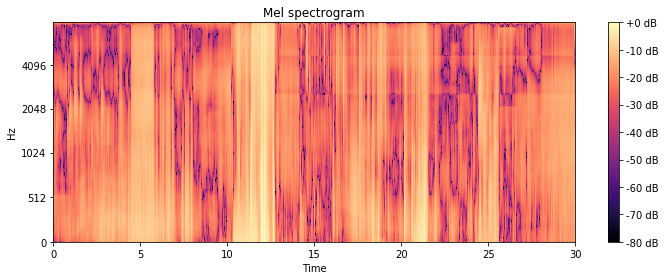

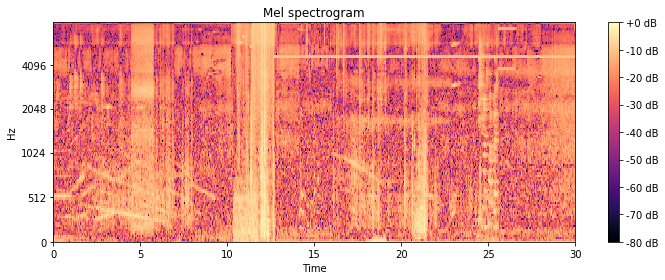

In [5]:
import numpy as np
print(np.sum(featVecMat[0,:,0]))
print(np.sum(featVecMat[0,:,1]))

print('scene')
print(featVecMat[:,:,0].shape)
visualiseLogMelSpec(featVecMat[:,:,0])

print('event')
print(featVecMat[:,:,1].shape)
visualiseLogMelSpec(featVecMat[:,:,1])


In [9]:
import pickle, glob, numpy as np
#Once stacked, split into 1 second examples!
#each file is 30 seconds long
#each feature is 1292 columns, thats 43.06 columns per second segment
audiofilelist=glob.glob('stacked_for_classification\\train\\**\\*.pckl')
print(len(audiofilelist))
for scene in audiofilelist:
    print(scene)
    with open(scene, "rb" ) as scenesample:
        (labels,featVecMat) = pickle.load(scenesample)
        r,c,chanel=featVecMat.shape
        segmentID=0
        for i in range(1,c-1,43):
            segmentFV=featVecMat[:,i:i+43]
            segmentLB=np.transpose(labels[i:i+43,:])
            lr,lc=segmentLB.shape
            newseglabels=np.zeros(lr)
            for j in range(0,lr):
                if np.sum(segmentLB[j,:])>0:
                    newseglabels[j]=1
            parts=scene.split('\\')
            s='_seg'+str(segmentID)+'.'
            savefilename='segmented_stacked\\'+'\\'.join(parts[1:-1])+'\\'+s.join(parts[-1].split('.')).replace('_2channel','')
            with open(savefilename, 'wb') as sf:
                pickle.dump((newseglabels, featVecMat), sf, protocol=pickle.HIGHEST_PROTOCOL)
            segmentID=segmentID+1
        del segmentFV, featVecMat
    
    

12000
stacked_for_classification\train\1\bus10_0_2channel.pckl
stacked_for_classification\train\1\bus10_1_2channel.pckl
stacked_for_classification\train\1\bus10_2_2channel.pckl
stacked_for_classification\train\1\bus10_3_2channel.pckl
stacked_for_classification\train\1\bus10_4_2channel.pckl
stacked_for_classification\train\1\bus10_5_2channel.pckl
stacked_for_classification\train\1\bus10_6_2channel.pckl
stacked_for_classification\train\1\bus10_7_2channel.pckl
stacked_for_classification\train\1\bus10_8_2channel.pckl
stacked_for_classification\train\1\bus10_9_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_0_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_1_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_2_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_3_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_4_2channel.pckl
stacked_for_classification\train\1\bus10_downshift_5_2channel.pckl
stacked_for_classifica

stacked_for_classification\train\1\bus5_downshift_3_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_4_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_5_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_6_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_7_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_8_2channel.pckl
stacked_for_classification\train\1\bus5_downshift_9_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_0_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_1_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_2_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_3_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_4_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_5_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_6_2channel.pckl
stacked_for_classification\train\1\bus5_upshift_7_2channel.pckl
stacked_for_classification

stacked_for_classification\train\1\busystreet10_upshift_2_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_3_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_4_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_5_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_6_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_7_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_8_2channel.pckl
stacked_for_classification\train\1\busystreet10_upshift_9_2channel.pckl
stacked_for_classification\train\1\busystreet2_0_2channel.pckl
stacked_for_classification\train\1\busystreet2_1_2channel.pckl
stacked_for_classification\train\1\busystreet2_2_2channel.pckl
stacked_for_classification\train\1\busystreet2_3_2channel.pckl
stacked_for_classification\train\1\busystreet2_4_2channel.pckl
stacked_for_classification\train\1\busystreet2_5_2channel.pckl
stacked_for_classification\train\1\busystreet2

stacked_for_classification\train\1\busystreet5_upshift_1_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_2_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_3_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_4_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_5_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_6_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_7_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_8_2channel.pckl
stacked_for_classification\train\1\busystreet5_upshift_9_2channel.pckl
stacked_for_classification\train\1\busystreet7_0_2channel.pckl
stacked_for_classification\train\1\busystreet7_1_2channel.pckl
stacked_for_classification\train\1\busystreet7_2_2channel.pckl
stacked_for_classification\train\1\busystreet7_3_2channel.pckl
stacked_for_classification\train\1\busystreet7_4_2channel.pckl
stacked_for_classification\train\1\busystreet7

stacked_for_classification\train\1\office10_upshift_1_2channel.pckl
stacked_for_classification\train\1\office10_upshift_2_2channel.pckl
stacked_for_classification\train\1\office10_upshift_3_2channel.pckl
stacked_for_classification\train\1\office10_upshift_4_2channel.pckl
stacked_for_classification\train\1\office10_upshift_5_2channel.pckl
stacked_for_classification\train\1\office10_upshift_6_2channel.pckl
stacked_for_classification\train\1\office10_upshift_7_2channel.pckl
stacked_for_classification\train\1\office10_upshift_8_2channel.pckl
stacked_for_classification\train\1\office10_upshift_9_2channel.pckl
stacked_for_classification\train\1\office2_0_2channel.pckl
stacked_for_classification\train\1\office2_1_2channel.pckl
stacked_for_classification\train\1\office2_2_2channel.pckl
stacked_for_classification\train\1\office2_3_2channel.pckl
stacked_for_classification\train\1\office2_4_2channel.pckl
stacked_for_classification\train\1\office2_5_2channel.pckl
stacked_for_classification\train\1

stacked_for_classification\train\1\office5_upshift_7_2channel.pckl
stacked_for_classification\train\1\office5_upshift_8_2channel.pckl
stacked_for_classification\train\1\office5_upshift_9_2channel.pckl
stacked_for_classification\train\1\office7_0_2channel.pckl
stacked_for_classification\train\1\office7_1_2channel.pckl
stacked_for_classification\train\1\office7_2_2channel.pckl
stacked_for_classification\train\1\office7_3_2channel.pckl
stacked_for_classification\train\1\office7_4_2channel.pckl
stacked_for_classification\train\1\office7_5_2channel.pckl
stacked_for_classification\train\1\office7_6_2channel.pckl
stacked_for_classification\train\1\office7_7_2channel.pckl
stacked_for_classification\train\1\office7_8_2channel.pckl
stacked_for_classification\train\1\office7_9_2channel.pckl
stacked_for_classification\train\1\office7_downshift_0_2channel.pckl
stacked_for_classification\train\1\office7_downshift_1_2channel.pckl
stacked_for_classification\train\1\office7_downshift_2_2channel.pckl
st

stacked_for_classification\train\1\openairmarket2_0_2channel.pckl
stacked_for_classification\train\1\openairmarket2_1_2channel.pckl
stacked_for_classification\train\1\openairmarket2_2_2channel.pckl
stacked_for_classification\train\1\openairmarket2_3_2channel.pckl
stacked_for_classification\train\1\openairmarket2_4_2channel.pckl
stacked_for_classification\train\1\openairmarket2_5_2channel.pckl
stacked_for_classification\train\1\openairmarket2_6_2channel.pckl
stacked_for_classification\train\1\openairmarket2_7_2channel.pckl
stacked_for_classification\train\1\openairmarket2_8_2channel.pckl
stacked_for_classification\train\1\openairmarket2_9_2channel.pckl
stacked_for_classification\train\1\openairmarket2_downshift_0_2channel.pckl
stacked_for_classification\train\1\openairmarket2_downshift_1_2channel.pckl
stacked_for_classification\train\1\openairmarket2_downshift_2_2channel.pckl
stacked_for_classification\train\1\openairmarket2_downshift_3_2channel.pckl
stacked_for_classification\train\1\o

stacked_for_classification\train\1\openairmarket5_upshift_4_2channel.pckl
stacked_for_classification\train\1\openairmarket5_upshift_5_2channel.pckl
stacked_for_classification\train\1\openairmarket5_upshift_6_2channel.pckl
stacked_for_classification\train\1\openairmarket5_upshift_7_2channel.pckl
stacked_for_classification\train\1\openairmarket5_upshift_8_2channel.pckl
stacked_for_classification\train\1\openairmarket5_upshift_9_2channel.pckl
stacked_for_classification\train\1\openairmarket7_0_2channel.pckl
stacked_for_classification\train\1\openairmarket7_1_2channel.pckl
stacked_for_classification\train\1\openairmarket7_2_2channel.pckl
stacked_for_classification\train\1\openairmarket7_3_2channel.pckl
stacked_for_classification\train\1\openairmarket7_4_2channel.pckl
stacked_for_classification\train\1\openairmarket7_5_2channel.pckl
stacked_for_classification\train\1\openairmarket7_6_2channel.pckl
stacked_for_classification\train\1\openairmarket7_7_2channel.pckl
stacked_for_classification\t

stacked_for_classification\train\1\park10_upshift_1_2channel.pckl
stacked_for_classification\train\1\park10_upshift_2_2channel.pckl
stacked_for_classification\train\1\park10_upshift_3_2channel.pckl
stacked_for_classification\train\1\park10_upshift_4_2channel.pckl
stacked_for_classification\train\1\park10_upshift_5_2channel.pckl
stacked_for_classification\train\1\park10_upshift_6_2channel.pckl
stacked_for_classification\train\1\park10_upshift_7_2channel.pckl
stacked_for_classification\train\1\park10_upshift_8_2channel.pckl
stacked_for_classification\train\1\park10_upshift_9_2channel.pckl
stacked_for_classification\train\1\park2_0_2channel.pckl
stacked_for_classification\train\1\park2_1_2channel.pckl
stacked_for_classification\train\1\park2_2_2channel.pckl
stacked_for_classification\train\1\park2_3_2channel.pckl
stacked_for_classification\train\1\park2_4_2channel.pckl
stacked_for_classification\train\1\park2_5_2channel.pckl
stacked_for_classification\train\1\park2_6_2channel.pckl
stacked

stacked_for_classification\train\1\park7_1_2channel.pckl
stacked_for_classification\train\1\park7_2_2channel.pckl
stacked_for_classification\train\1\park7_3_2channel.pckl
stacked_for_classification\train\1\park7_4_2channel.pckl
stacked_for_classification\train\1\park7_5_2channel.pckl
stacked_for_classification\train\1\park7_6_2channel.pckl
stacked_for_classification\train\1\park7_7_2channel.pckl
stacked_for_classification\train\1\park7_8_2channel.pckl
stacked_for_classification\train\1\park7_9_2channel.pckl
stacked_for_classification\train\1\park7_downshift_0_2channel.pckl
stacked_for_classification\train\1\park7_downshift_1_2channel.pckl
stacked_for_classification\train\1\park7_downshift_2_2channel.pckl
stacked_for_classification\train\1\park7_downshift_3_2channel.pckl
stacked_for_classification\train\1\park7_downshift_4_2channel.pckl
stacked_for_classification\train\1\park7_downshift_5_2channel.pckl
stacked_for_classification\train\1\park7_downshift_6_2channel.pckl
stacked_for_classi

stacked_for_classification\train\1\quietstreet2_8_2channel.pckl
stacked_for_classification\train\1\quietstreet2_9_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_0_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_1_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_2_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_3_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_4_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_5_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_6_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_7_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_8_2channel.pckl
stacked_for_classification\train\1\quietstreet2_downshift_9_2channel.pckl
stacked_for_classification\train\1\quietstreet2_upshift_0_2channel.pckl
stacked_for_classification\train\1\quietstreet2_upshift_1_2c

stacked_for_classification\train\1\quietstreet7_5_2channel.pckl
stacked_for_classification\train\1\quietstreet7_6_2channel.pckl
stacked_for_classification\train\1\quietstreet7_7_2channel.pckl
stacked_for_classification\train\1\quietstreet7_8_2channel.pckl
stacked_for_classification\train\1\quietstreet7_9_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_0_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_1_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_2_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_3_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_4_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_5_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_6_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_7_2channel.pckl
stacked_for_classification\train\1\quietstreet7_downshift_8_2channel.pckl
stacked_for_cl

stacked_for_classification\train\1\restaurant2_2_2channel.pckl
stacked_for_classification\train\1\restaurant2_3_2channel.pckl
stacked_for_classification\train\1\restaurant2_4_2channel.pckl
stacked_for_classification\train\1\restaurant2_5_2channel.pckl
stacked_for_classification\train\1\restaurant2_6_2channel.pckl
stacked_for_classification\train\1\restaurant2_7_2channel.pckl
stacked_for_classification\train\1\restaurant2_8_2channel.pckl
stacked_for_classification\train\1\restaurant2_9_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_0_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_1_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_2_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_3_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_4_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_5_2channel.pckl
stacked_for_classification\train\1\restaurant2_downshift_6

stacked_for_classification\train\1\restaurant7_1_2channel.pckl
stacked_for_classification\train\1\restaurant7_2_2channel.pckl
stacked_for_classification\train\1\restaurant7_3_2channel.pckl
stacked_for_classification\train\1\restaurant7_4_2channel.pckl
stacked_for_classification\train\1\restaurant7_5_2channel.pckl
stacked_for_classification\train\1\restaurant7_6_2channel.pckl
stacked_for_classification\train\1\restaurant7_7_2channel.pckl
stacked_for_classification\train\1\restaurant7_8_2channel.pckl
stacked_for_classification\train\1\restaurant7_9_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_0_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_1_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_2_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_3_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_4_2channel.pckl
stacked_for_classification\train\1\restaurant7_downshift_5_2channel.

stacked_for_classification\train\1\supermarket10_upshift_9_2channel.pckl
stacked_for_classification\train\1\supermarket2_0_2channel.pckl
stacked_for_classification\train\1\supermarket2_1_2channel.pckl
stacked_for_classification\train\1\supermarket2_2_2channel.pckl
stacked_for_classification\train\1\supermarket2_3_2channel.pckl
stacked_for_classification\train\1\supermarket2_4_2channel.pckl
stacked_for_classification\train\1\supermarket2_5_2channel.pckl
stacked_for_classification\train\1\supermarket2_6_2channel.pckl
stacked_for_classification\train\1\supermarket2_7_2channel.pckl
stacked_for_classification\train\1\supermarket2_8_2channel.pckl
stacked_for_classification\train\1\supermarket2_9_2channel.pckl
stacked_for_classification\train\1\supermarket2_downshift_0_2channel.pckl
stacked_for_classification\train\1\supermarket2_downshift_1_2channel.pckl
stacked_for_classification\train\1\supermarket2_downshift_2_2channel.pckl
stacked_for_classification\train\1\supermarket2_downshift_3_2chan

stacked_for_classification\train\1\supermarket5_upshift_7_2channel.pckl
stacked_for_classification\train\1\supermarket5_upshift_8_2channel.pckl
stacked_for_classification\train\1\supermarket5_upshift_9_2channel.pckl
stacked_for_classification\train\1\supermarket7_0_2channel.pckl
stacked_for_classification\train\1\supermarket7_1_2channel.pckl
stacked_for_classification\train\1\supermarket7_2_2channel.pckl
stacked_for_classification\train\1\supermarket7_3_2channel.pckl
stacked_for_classification\train\1\supermarket7_4_2channel.pckl
stacked_for_classification\train\1\supermarket7_5_2channel.pckl
stacked_for_classification\train\1\supermarket7_6_2channel.pckl
stacked_for_classification\train\1\supermarket7_7_2channel.pckl
stacked_for_classification\train\1\supermarket7_8_2channel.pckl
stacked_for_classification\train\1\supermarket7_9_2channel.pckl
stacked_for_classification\train\1\supermarket7_downshift_0_2channel.pckl
stacked_for_classification\train\1\supermarket7_downshift_1_2channel.p

stacked_for_classification\train\1\tube10_upshift_7_2channel.pckl
stacked_for_classification\train\1\tube10_upshift_8_2channel.pckl
stacked_for_classification\train\1\tube10_upshift_9_2channel.pckl
stacked_for_classification\train\1\tube2_0_2channel.pckl
stacked_for_classification\train\1\tube2_1_2channel.pckl
stacked_for_classification\train\1\tube2_2_2channel.pckl
stacked_for_classification\train\1\tube2_3_2channel.pckl
stacked_for_classification\train\1\tube2_4_2channel.pckl
stacked_for_classification\train\1\tube2_5_2channel.pckl
stacked_for_classification\train\1\tube2_6_2channel.pckl
stacked_for_classification\train\1\tube2_7_2channel.pckl
stacked_for_classification\train\1\tube2_8_2channel.pckl
stacked_for_classification\train\1\tube2_9_2channel.pckl
stacked_for_classification\train\1\tube2_downshift_0_2channel.pckl
stacked_for_classification\train\1\tube2_downshift_1_2channel.pckl
stacked_for_classification\train\1\tube2_downshift_2_2channel.pckl
stacked_for_classification\trai

stacked_for_classification\train\1\tube7_8_2channel.pckl
stacked_for_classification\train\1\tube7_9_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_0_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_1_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_2_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_3_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_4_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_5_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_6_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_7_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_8_2channel.pckl
stacked_for_classification\train\1\tube7_downshift_9_2channel.pckl
stacked_for_classification\train\1\tube7_upshift_0_2channel.pckl
stacked_for_classification\train\1\tube7_upshift_1_2channel.pckl
stacked_for_classification\train\1\tube7_upshift_2_2channel.pckl
stacked_for_classific

stacked_for_classification\train\1\tubestation2_downshift_3_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_4_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_5_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_6_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_7_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_8_2channel.pckl
stacked_for_classification\train\1\tubestation2_downshift_9_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_0_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_1_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_2_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_3_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_4_2channel.pckl
stacked_for_classification\train\1\tubestation2_upshift_5_2channel.pckl
stacked_for_classification\train\1\tubestation2_up

stacked_for_classification\train\1\tubestation7_downshift_1_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_2_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_3_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_4_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_5_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_6_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_7_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_8_2channel.pckl
stacked_for_classification\train\1\tubestation7_downshift_9_2channel.pckl
stacked_for_classification\train\1\tubestation7_upshift_0_2channel.pckl
stacked_for_classification\train\1\tubestation7_upshift_1_2channel.pckl
stacked_for_classification\train\1\tubestation7_upshift_2_2channel.pckl
stacked_for_classification\train\1\tubestation7_upshift_3_2channel.pckl
stacked_for_classification\train\1\tubestation

stacked_for_classification\train\2\bus1_downshift_3_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_4_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_5_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_6_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_7_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_8_2channel.pckl
stacked_for_classification\train\2\bus1_downshift_9_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_0_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_1_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_2_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_3_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_4_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_5_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_6_2channel.pckl
stacked_for_classification\train\2\bus1_upshift_7_2channel.pckl
stacked_for_classification

stacked_for_classification\train\2\bus6_upshift_5_2channel.pckl
stacked_for_classification\train\2\bus6_upshift_6_2channel.pckl
stacked_for_classification\train\2\bus6_upshift_7_2channel.pckl
stacked_for_classification\train\2\bus6_upshift_8_2channel.pckl
stacked_for_classification\train\2\bus6_upshift_9_2channel.pckl
stacked_for_classification\train\2\bus8_0_2channel.pckl
stacked_for_classification\train\2\bus8_1_2channel.pckl
stacked_for_classification\train\2\bus8_2_2channel.pckl
stacked_for_classification\train\2\bus8_3_2channel.pckl
stacked_for_classification\train\2\bus8_4_2channel.pckl
stacked_for_classification\train\2\bus8_5_2channel.pckl
stacked_for_classification\train\2\bus8_6_2channel.pckl
stacked_for_classification\train\2\bus8_7_2channel.pckl
stacked_for_classification\train\2\bus8_8_2channel.pckl
stacked_for_classification\train\2\bus8_9_2channel.pckl
stacked_for_classification\train\2\bus8_downshift_0_2channel.pckl
stacked_for_classification\train\2\bus8_downshift_1_2c

stacked_for_classification\train\2\busystreet3_0_2channel.pckl
stacked_for_classification\train\2\busystreet3_1_2channel.pckl
stacked_for_classification\train\2\busystreet3_2_2channel.pckl
stacked_for_classification\train\2\busystreet3_3_2channel.pckl
stacked_for_classification\train\2\busystreet3_4_2channel.pckl
stacked_for_classification\train\2\busystreet3_5_2channel.pckl
stacked_for_classification\train\2\busystreet3_6_2channel.pckl
stacked_for_classification\train\2\busystreet3_7_2channel.pckl
stacked_for_classification\train\2\busystreet3_8_2channel.pckl
stacked_for_classification\train\2\busystreet3_9_2channel.pckl
stacked_for_classification\train\2\busystreet3_downshift_0_2channel.pckl
stacked_for_classification\train\2\busystreet3_downshift_1_2channel.pckl
stacked_for_classification\train\2\busystreet3_downshift_2_2channel.pckl
stacked_for_classification\train\2\busystreet3_downshift_3_2channel.pckl
stacked_for_classification\train\2\busystreet3_downshift_4_2channel.pckl
stack

stacked_for_classification\train\2\busystreet6_upshift_9_2channel.pckl
stacked_for_classification\train\2\busystreet8_0_2channel.pckl
stacked_for_classification\train\2\busystreet8_1_2channel.pckl
stacked_for_classification\train\2\busystreet8_2_2channel.pckl
stacked_for_classification\train\2\busystreet8_3_2channel.pckl
stacked_for_classification\train\2\busystreet8_4_2channel.pckl
stacked_for_classification\train\2\busystreet8_5_2channel.pckl
stacked_for_classification\train\2\busystreet8_6_2channel.pckl
stacked_for_classification\train\2\busystreet8_7_2channel.pckl
stacked_for_classification\train\2\busystreet8_8_2channel.pckl
stacked_for_classification\train\2\busystreet8_9_2channel.pckl
stacked_for_classification\train\2\busystreet8_downshift_0_2channel.pckl
stacked_for_classification\train\2\busystreet8_downshift_1_2channel.pckl
stacked_for_classification\train\2\busystreet8_downshift_2_2channel.pckl
stacked_for_classification\train\2\busystreet8_downshift_3_2channel.pckl
stacked

stacked_for_classification\train\2\office3_1_2channel.pckl
stacked_for_classification\train\2\office3_2_2channel.pckl
stacked_for_classification\train\2\office3_3_2channel.pckl
stacked_for_classification\train\2\office3_4_2channel.pckl
stacked_for_classification\train\2\office3_5_2channel.pckl
stacked_for_classification\train\2\office3_6_2channel.pckl
stacked_for_classification\train\2\office3_7_2channel.pckl
stacked_for_classification\train\2\office3_8_2channel.pckl
stacked_for_classification\train\2\office3_9_2channel.pckl
stacked_for_classification\train\2\office3_downshift_0_2channel.pckl
stacked_for_classification\train\2\office3_downshift_1_2channel.pckl
stacked_for_classification\train\2\office3_downshift_2_2channel.pckl
stacked_for_classification\train\2\office3_downshift_3_2channel.pckl
stacked_for_classification\train\2\office3_downshift_4_2channel.pckl
stacked_for_classification\train\2\office3_downshift_5_2channel.pckl
stacked_for_classification\train\2\office3_downshift_6_

stacked_for_classification\train\2\office8_8_2channel.pckl
stacked_for_classification\train\2\office8_9_2channel.pckl
stacked_for_classification\train\2\office8_downshift_0_2channel.pckl
stacked_for_classification\train\2\office8_downshift_1_2channel.pckl
stacked_for_classification\train\2\office8_downshift_2_2channel.pckl
stacked_for_classification\train\2\office8_downshift_3_2channel.pckl
stacked_for_classification\train\2\office8_downshift_4_2channel.pckl
stacked_for_classification\train\2\office8_downshift_5_2channel.pckl
stacked_for_classification\train\2\office8_downshift_6_2channel.pckl
stacked_for_classification\train\2\office8_downshift_7_2channel.pckl
stacked_for_classification\train\2\office8_downshift_8_2channel.pckl
stacked_for_classification\train\2\office8_downshift_9_2channel.pckl
stacked_for_classification\train\2\office8_upshift_0_2channel.pckl
stacked_for_classification\train\2\office8_upshift_1_2channel.pckl
stacked_for_classification\train\2\office8_upshift_2_2chan

stacked_for_classification\train\2\openairmarket3_7_2channel.pckl
stacked_for_classification\train\2\openairmarket3_8_2channel.pckl
stacked_for_classification\train\2\openairmarket3_9_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_0_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_1_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_2_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_3_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_4_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_5_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_6_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_7_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_8_2channel.pckl
stacked_for_classification\train\2\openairmarket3_downshift_9_2channel.pckl
stacked_for_classification\train\2\openair

stacked_for_classification\train\2\openairmarket8_1_2channel.pckl
stacked_for_classification\train\2\openairmarket8_2_2channel.pckl
stacked_for_classification\train\2\openairmarket8_3_2channel.pckl
stacked_for_classification\train\2\openairmarket8_4_2channel.pckl
stacked_for_classification\train\2\openairmarket8_5_2channel.pckl
stacked_for_classification\train\2\openairmarket8_6_2channel.pckl
stacked_for_classification\train\2\openairmarket8_7_2channel.pckl
stacked_for_classification\train\2\openairmarket8_8_2channel.pckl
stacked_for_classification\train\2\openairmarket8_9_2channel.pckl
stacked_for_classification\train\2\openairmarket8_downshift_0_2channel.pckl
stacked_for_classification\train\2\openairmarket8_downshift_1_2channel.pckl
stacked_for_classification\train\2\openairmarket8_downshift_2_2channel.pckl
stacked_for_classification\train\2\openairmarket8_downshift_3_2channel.pckl
stacked_for_classification\train\2\openairmarket8_downshift_4_2channel.pckl
stacked_for_classification

stacked_for_classification\train\2\park3_3_2channel.pckl
stacked_for_classification\train\2\park3_4_2channel.pckl
stacked_for_classification\train\2\park3_5_2channel.pckl
stacked_for_classification\train\2\park3_6_2channel.pckl
stacked_for_classification\train\2\park3_7_2channel.pckl
stacked_for_classification\train\2\park3_8_2channel.pckl
stacked_for_classification\train\2\park3_9_2channel.pckl
stacked_for_classification\train\2\park3_downshift_0_2channel.pckl
stacked_for_classification\train\2\park3_downshift_1_2channel.pckl
stacked_for_classification\train\2\park3_downshift_2_2channel.pckl
stacked_for_classification\train\2\park3_downshift_3_2channel.pckl
stacked_for_classification\train\2\park3_downshift_4_2channel.pckl
stacked_for_classification\train\2\park3_downshift_5_2channel.pckl
stacked_for_classification\train\2\park3_downshift_6_2channel.pckl
stacked_for_classification\train\2\park3_downshift_7_2channel.pckl
stacked_for_classification\train\2\park3_downshift_8_2channel.pck

stacked_for_classification\train\2\park8_downshift_4_2channel.pckl
stacked_for_classification\train\2\park8_downshift_5_2channel.pckl
stacked_for_classification\train\2\park8_downshift_6_2channel.pckl
stacked_for_classification\train\2\park8_downshift_7_2channel.pckl
stacked_for_classification\train\2\park8_downshift_8_2channel.pckl
stacked_for_classification\train\2\park8_downshift_9_2channel.pckl
stacked_for_classification\train\2\park8_upshift_0_2channel.pckl
stacked_for_classification\train\2\park8_upshift_1_2channel.pckl
stacked_for_classification\train\2\park8_upshift_2_2channel.pckl
stacked_for_classification\train\2\park8_upshift_3_2channel.pckl
stacked_for_classification\train\2\park8_upshift_4_2channel.pckl
stacked_for_classification\train\2\park8_upshift_5_2channel.pckl
stacked_for_classification\train\2\park8_upshift_6_2channel.pckl
stacked_for_classification\train\2\park8_upshift_7_2channel.pckl
stacked_for_classification\train\2\park8_upshift_8_2channel.pckl
stacked_for_c

stacked_for_classification\train\2\quietstreet3_downshift_6_2channel.pckl
stacked_for_classification\train\2\quietstreet3_downshift_7_2channel.pckl
stacked_for_classification\train\2\quietstreet3_downshift_8_2channel.pckl
stacked_for_classification\train\2\quietstreet3_downshift_9_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_0_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_1_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_2_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_3_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_4_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_5_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_6_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_7_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_8_2channel.pckl
stacked_for_classification\train\2\quietstreet3_upshift_

stacked_for_classification\train\2\quietstreet8_downshift_4_2channel.pckl
stacked_for_classification\train\2\quietstreet8_downshift_5_2channel.pckl
stacked_for_classification\train\2\quietstreet8_downshift_6_2channel.pckl
stacked_for_classification\train\2\quietstreet8_downshift_7_2channel.pckl
stacked_for_classification\train\2\quietstreet8_downshift_8_2channel.pckl
stacked_for_classification\train\2\quietstreet8_downshift_9_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_0_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_1_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_2_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_3_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_4_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_5_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upshift_6_2channel.pckl
stacked_for_classification\train\2\quietstreet8_upsh

stacked_for_classification\train\2\restaurant3_downshift_2_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_3_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_4_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_5_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_6_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_7_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_8_2channel.pckl
stacked_for_classification\train\2\restaurant3_downshift_9_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_0_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_1_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_2_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_3_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_4_2channel.pckl
stacked_for_classification\train\2\restaurant3_upshift_5_2cha

stacked_for_classification\train\2\restaurant8_downshift_1_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_2_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_3_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_4_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_5_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_6_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_7_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_8_2channel.pckl
stacked_for_classification\train\2\restaurant8_downshift_9_2channel.pckl
stacked_for_classification\train\2\restaurant8_upshift_0_2channel.pckl
stacked_for_classification\train\2\restaurant8_upshift_1_2channel.pckl
stacked_for_classification\train\2\restaurant8_upshift_2_2channel.pckl
stacked_for_classification\train\2\restaurant8_upshift_3_2channel.pckl
stacked_for_classification\train\2\restaurant8_upshift_4_2c

OSError: [Errno 28] No space left on device